In [1]:
!conda install pandas seaborn -y

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!pip install opencv-python torchsummary scikit-learn torchviz utils imageio

In [3]:
import os

DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
import time
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [6]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
import imageio
from torchvision import datasets, transforms

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Discriminator(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(Discriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4_1 = nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm4_1 = nn.BatchNorm2d(ndf * 4)
        self.conv4_2 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_2 = nn.BatchNorm2d(ndf * 8)
        self.conv4_3 = nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_3 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

#         x = self.conv4_1(x)
#         x = self.BatchNorm4_1(x)
#         x = self.LeakyReLU(x)
#         x = self.DropOut2(x)
        x = self.conv4_2(x)
        x = self.BatchNorm4_2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)
        x = self.conv4_3(x)
        x = self.BatchNorm4_3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s, c

class Generator(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(Generator, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        #self.DropOut = nn.Dropout(p=0.75)
        #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
        #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 4)

        self.conv4 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm5 = nn.BatchNorm2d(ngf * 1)

        self.conv6 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        #x = self.conv0(input)
        #x = self.BatchNorm0(x)
        #x = self.ReLU(x)
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

#         x = self.conv2(x)
#         x = self.BatchNorm2(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)
        
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv5(x)
        x = self.BatchNorm5(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv6(x)
        output = self.Tanh(x)
        return output

In [8]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_generate_animation_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot_unit(hist, path, model_name, index):
    x = range(len(hist[index[0]]))

    plt.plot(x, hist[index[0]], label=index[0])
    if len(index) >= 2:
        plt.plot(x, hist[index[1]], label=index[1])

    plt.xlabel('Iter')
    plt.ylabel(model_name)

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    now = datetime.datetime.now()
    path = os.path.join(path, now.strftime("%Y-%m-%d_%H-%M-%S_") + model_name + '.png')
    plt.savefig(path)
    plt.close()

def loss_plot(hist, path='Train_hist', model_name=''):
    loss_plot_unit(hist=hist, path=path, model_name='Total_Loss', index=['G_losses', 'D_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='G_C_S_Loss', index=['G_class_losses', 'G_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_R_F_Loss', index=['D_real_losses', 'D_fake_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_C_S_Loss', index=['D_class_losses', 'D_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='Overall_Loss', index=['Losses'])
    loss_plot_unit(hist=hist, path=path, model_name='Time', index=['Time_per_epoch'])
    loss_plot_unit(hist=hist, path=path, model_name='G_class_losses', index=['G_class_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='G_syn_losses', index=['G_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_real_losses', index=['D_real_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_fake_losses', index=['D_fake_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_class_losses', index=['D_class_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_syn_losses', index=['D_syn_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='G_losses', index=['G_losses'])
    loss_plot_unit(hist=hist, path=path, model_name='D_losses', index=['D_losses'])
    

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    print("image saved at ->", path)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [9]:
class CACGAN(object):
    def __init__(self):
        self.model_name = 'ACGAN'
        self.I_want_to_train_faster = 5
        self.num_epoch = round(5000/self.I_want_to_train_faster)
        self.base_path = './temp'
        self.base_folder = "YogaPoses"
#         self.classic_folder = 'Coivd-19_Classic'
#         self.synthetic_folder = 'Coivd-19_Synthetic'
        self.data_dir = os.path.join(self.base_path, self.base_folder)
        self.batch_size = 128
#         self.train_path = os.path.join(self.data_dir, "train")
#         self.test_path = os.path.join(self.data_dir, "test")
        self.labels = os.listdir(self.data_dir)
        self.no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
        self.label_dict = {
            i : self.labels[i]
            for i in range(len(self.labels))
        }
        self.img_size = 128
        self.num_of_ch = 3
        # size of z latent vector (i.e. size of generator input)
        self.size_of_z = self.img_size
        self.num_of_label = len(self.labels)
        self.sample_num = self.num_of_label ** 2
#         self.learning_rate_g = 0.00000002
#         self.learning_rate_d = 0.00000002
#         self.learning_rate_g = 0.0000001
#         self.learning_rate_d = 0.0000001
        self.learning_rate_g = 0.0000166 * self.I_want_to_train_faster
        self.learning_rate_d = 0.0000166 * self.I_want_to_train_faster
        # beta1 hyperparam for adam
        self.adam_beta_1 = 0.5
        # beta2 hyperparam for adam
        self.adam_beta_2 = 0.999
        self.real_label = 1.0
        self.fake_label = 0.0
        self.syn_criterion = nn.BCELoss().to(device) # synthesizing
        self.class_criterion = nn.CrossEntropyLoss().to(device) # classification
        
        self.train_loader, self.test_loader, self.train_data, self.test_data = self.load_dataset()
        self.generator = Generator(self.size_of_z, self.img_size, self.num_of_ch).to(device)
        self.discriminator = Discriminator(self.img_size, self.num_of_ch, self.num_of_label).to(device)

        self.optimizer_d = optim.Adam(self.discriminator.parameters(), 
                                      lr=self.learning_rate_d, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))
        self.optimizer_g = optim.Adam(self.generator.parameters(), 
                                      lr=self.learning_rate_g, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))

        # fixed noise & label
        self.sample_z_fixed = torch.zeros((self.sample_num, self.size_of_z))
        for i in range(self.num_of_label):
            self.sample_z_fixed[i*self.num_of_label] = torch.rand(1, self.size_of_z)
            for j in range(1, self.num_of_label):
                self.sample_z_fixed[i*self.num_of_label + j] = self.sample_z_fixed[i*self.num_of_label]

        temp = torch.zeros((self.num_of_label, 1))
        for i in range(self.num_of_label):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.num_of_label):
            temp_y[i*self.num_of_label: (i+1)*self.num_of_label] = temp

        self.sample_y_fixed = torch.zeros((self.sample_num, self.num_of_label)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        self.sample_z_fixed, self.sample_y_fixed = self.sample_z_fixed.to(device), self.sample_y_fixed.to(device)
        
    def load_dataset(self):
#         train_dir = self.train_path
#         test_dir = self.test_path
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        data = datasets.ImageFolder(self.data_dir, transform=transform)
        n = len(data)  # total number of examples
        n_test = int(0.1 * n)  # take ~25% for test
        print("total number ->", n)
        print("test number  ->", n_test)
        test_data = torch.utils.data.Subset(data, range(n_test))  # take first 25%
        train_data = torch.utils.data.Subset(data, range(n_test, n))  # take the rest  
        train_loader = DataLoader(train_data, self.batch_size, shuffle=True, num_workers=1)
        test_loader = DataLoader(test_data, self.batch_size, shuffle=True, num_workers=1)

        return train_loader, test_loader, train_data, test_data

    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 
    
    def visualize_results(self, epoch, fix=True):
        self.generator.eval()

        image_frame_dim = round(np.sqrt(self.sample_num))
        if fix:
            """ fixed noise """
            samples = self.generator(self.sample_z_fixed.resize_(self.sample_z_fixed.shape[0], self.sample_z_fixed.shape[1], 1, 1))
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            sample_z_, sample_y_ = sample_z_.to(device), sample_y_.to(device)
            samples = self.generator(sample_z_.resize_(self.sample_z_.shape[0], self.sample_z_.shape[1], 1, 1))

        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    os.path.join('.', 'GANAug/plots/Yoga') + "/" + self.model_name + '_generate_animation_epoch%03d' % epoch + '.png')
    
    def train(self):
        for func in [
            lambda: os.mkdir(os.path.join('.', 'GANAug')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model/Yoga')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots/Yoga')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Yoga')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Yoga/' + self.label_dict[0])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Yoga/' + self.label_dict[1])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Yoga/' + self.label_dict[2])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Yoga/' + self.label_dict[3])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/Yoga/' + self.label_dict[4]))]:
            try:
                func()
            except Exception as error:
                print(error)
                continue
        matrix_fields = [
            'G_losses',
            'G_class_losses',
            'G_syn_losses',
            'D_losses',
            'D_real_losses',
            'D_fake_losses',
            'D_class_losses',
            'D_syn_losses',
            'Losses',
            'Time_per_epoch',
            'Total_time'
        ]
        self.metrics = {field: list() for field in matrix_fields}
        early_stop_count = 0
        early_stop_patient = len(self.train_loader) * 4422 # A ha ha ha ha
        early_stop = False
        best_batch_loss = -1
        save_model = False
        number_of_model_saved = 10
        label_fixed_data = [i%self.num_of_label for i in range(self.sample_num)]
        
        def get_file_list(file_path, length):
            dir_list = os.listdir(file_path)
            dir_list = only_pth_file(dir_list)
            if not dir_list:
                return
            else:
                dir_list = sorted(dir_list,  key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
                print("files to be deleted < length =", length ,"> ->", dir_list[0:length])
                return dir_list[0:length]

        def only_pth_file(file_list):
            new_list = []
            for file in file_list:
                if file[-4:] == ".pth":
                    new_list.append(file)
            return new_list
            
        start_time = time.time()
        print("Start Testing ...")
        print(self.generator)
        print(self.discriminator)
        summary(self.generator, (self.size_of_z, 1, 1), batch_size=self.batch_size, device=device)
        summary(self.discriminator, (self.num_of_ch, self.img_size, self.img_size), batch_size=self.batch_size, device=device)
        g_output = self.generator(torch.rand((self.batch_size, self.size_of_z, 1, 1)).to(device))
        print(g_output.shape)
        s_output, c_output = self.discriminator(torch.rand(g_output.shape).to(device))
        print(s_output.shape)
        print(c_output.shape)
        del g_output, s_output, c_output
        print("Testing Done in ->", time.time() - start_time)
        start_time = time.time()
        print("Start Training ...")

        self.discriminator.train()
        for epoch in range(self.num_epoch):
            epoch += 1
            log_in_data_loader = []
            self.generator.train()
            epoch_start_time = time.time()
            for i, data in enumerate(tqdm(self.train_loader, 0)):
                x_, y_ = data
                batch_size_x_ = x_.size(0)
                z_ = torch.rand((batch_size_x_, self.size_of_z))
                y_vec_ = torch.zeros((batch_size_x_, self.num_of_label)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                x_, z_, y_vec_ = x_.to(device), z_.to(device), y_vec_.to(device)
                self.y_real_, self.y_fake_ = torch.ones(batch_size_x_, 1), torch.zeros(batch_size_x_, 1)
                self.y_real_, self.y_fake_ = self.y_real_.to(device), self.y_fake_.to(device)
        
                # update D network
                self.optimizer_d.zero_grad()

                D_real, C_real = self.discriminator(x_)
                D_real_loss = self.syn_criterion(D_real, self.y_real_)
                C_real_loss = self.class_criterion(C_real, torch.max(y_vec_, 1)[1])

                G_ = self.generator(z_.resize_(batch_size_x_, self.size_of_z, 1, 1))
                D_fake, C_fake = self.discriminator(G_)
                
                D_fake_loss = self.syn_criterion(D_fake, self.y_fake_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                D_loss = D_real_loss + C_real_loss + D_fake_loss + C_fake_loss
                self.metrics['D_losses'].append(D_loss.item())
                self.metrics['D_real_losses'].append((D_real_loss + C_real_loss).item())
                self.metrics['D_fake_losses'].append((D_fake_loss + C_fake_loss).item())
                self.metrics['D_class_losses'].append((C_real_loss + C_fake_loss).item())
                self.metrics['D_syn_losses'].append((D_real_loss + D_fake_loss).item())

                D_loss.backward()
                self.optimizer_d.step()

                # update G network
                self.optimizer_g.zero_grad()

                G_ = self.generator(z_.resize_(batch_size_x_, self.size_of_z, 1, 1))
                D_fake, C_fake = self.discriminator(G_)

                D_fake_loss = self.syn_criterion(D_fake, self.y_real_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                G_loss = D_fake_loss + C_fake_loss
                self.metrics['G_losses'].append(G_loss.item())
                self.metrics['G_syn_losses'].append(D_fake_loss.item())
                self.metrics['G_class_losses'].append(C_fake_loss.item())
                self.metrics['Losses'].append(self.metrics['G_losses'][-1] + self.metrics['D_losses'][-1])

                G_loss.backward()
                self.optimizer_g.step()

                if best_batch_loss < 0:
                    best_batch_loss = self.metrics['Losses'][-1]
                    early_stop_count = 0
                else:
                    if best_batch_loss >= self.metrics['Losses'][-1]:
                        best_batch_loss = self.metrics['Losses'][-1]
                        early_stop_count = 0
                        log_in_data_loader.append("---------------------<lowest loss update -> " + str(best_batch_loss) + " at -> " + str(i + 1) + ">---------------------")
                        save_model = True
                    else:
                        early_stop_count += 1
                        if early_stop_count >= early_stop_patient and early_stop == False:
                            log_in_data_loader.append("-----------------------------------< early stopping ... >-----------------------------------")
                            early_stop = True

                if i % round(len(self.train_loader)/5) == 0:
                    vutils.save_image(x_, './GANAug/output_images/Yoga/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)
                    fake = self.generator(self.sample_z_fixed.resize_(self.sample_z_fixed.shape[0], self.sample_z_fixed.shape[1], 1, 1))
                    for j in range(len(fake)):
                        vutils.save_image(fake[j].data,
                                '%s/fake_samples_epoch_%03d.jpg' % ('./GANAug/output_images/Yoga/' + self.label_dict[label_fixed_data[j]], epoch), 
                                          normalize=True)

            self.metrics['Time_per_epoch'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results(epoch)
    
            for message in log_in_data_loader:
                print(message)
            print('[%d/%d] ======================================================================== \nLoss_D: %.8f, Loss_G: %.8f\nLoss_S_D: %.8f, Loss_C_D: %.8f, Loss_R_D: %.8f, Loss_F_D: %.8f\nLoss_S_G: %.8f, Loss_C_G: %.8f'
                  % (epoch, self.num_epoch, 
                     np.mean(self.metrics['D_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['D_syn_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_class_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_real_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_fake_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_syn_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['G_class_losses'][-len(self.train_loader):])))

            # do checkpointing
            if save_model == True:
                save_model = False
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/Yoga'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/Yoga'), epoch))
            elif early_stop:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/Yoga'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/Yoga'), epoch))
                break
            elif epoch % round(self.num_epoch/10) == 0:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/Yoga'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/Yoga'), epoch))
            else:
                print("---------------------< no model saved at epoch:", epoch, ">---------------------")

            if len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/Yoga')))) > number_of_model_saved:
                delete_list = get_file_list(os.path.join('.', 'GANAug/model/Yoga'), 
                                            len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/Yoga')))) - number_of_model_saved)
                for file in delete_list:
                    if os.path.exists(os.path.join(os.path.join('.', 'GANAug/model/Yoga'), file)):
                        os.remove(os.path.join(os.path.join('.', 'GANAug/model/Yoga'), file))
                    else:
                        print("file ->", os.path.join(os.path.join('.', 'GANAug/model/Yoga'), file), "does not exist")

        self.metrics['Total_time'].append(time.time() - start_time)
        print("Average epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.metrics['Time_per_epoch']),
                                                                        self.num_epoch, self.metrics['Total_time'][0]))
        generate_animation(os.path.join('.', 'GANAug/plots/Yoga/') + self.model_name, self.num_epoch)
        loss_plot(self.metrics, os.path.join('.', 'GANAug/plots/Yoga/'))
        print("Training Done !")

In [10]:
acgan = CACGAN()

total number -> 988
test number  -> 98


In [11]:
acgan.train()

[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/model'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/plots'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/model/Yoga'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/plots/Yoga'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga/Downdog'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga/Goddess'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga/Plank'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga/Tree'
[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga/Warrior2'
Start Testing ...
Generator(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c

C:\Users\lebro\AppData\Local\Temp\ipykernel_14460\1081463272.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 128, 64, 64]           6,144
         LeakyReLU-2         [128, 128, 64, 64]               0
           Dropout-3         [128, 128, 64, 64]               0
            Conv2d-4         [128, 256, 32, 32]         524,288
       BatchNorm2d-5         [128, 256, 32, 32]             512
         LeakyReLU-6         [128, 256, 32, 32]               0
            Conv2d-7         [128, 512, 16, 16]       2,097,152
       BatchNorm2d-8         [128, 512, 16, 16]           1,024
         LeakyReLU-9         [128, 512, 16, 16]               0
          Dropout-10         [128, 512, 16, 16]               0
           Conv2d-11          [128, 1024, 8, 8]       8,388,608
      BatchNorm2d-12          [128, 1024, 8, 8]           2,048
        LeakyReLU-13          [128, 1024, 8, 8]               0
          Dropout-14          [128, 102

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.01s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch001.png
[1/1000] ======================================================================== 
Loss_D: 6.41282347, Loss_G: 4.32616840
Loss_S_D: 3.16116835, Loss_C_D: 3.25165507, Loss_R_D: 2.97383436, Loss_F_D: 3.43898913
Loss_S_G: 2.71328648, Loss_C_G: 1.61288192
---------------------< no model saved at epoch: 1 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.76s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch002.png
[2/1000] ======================================================================== 
Loss_D: 5.99971914, Loss_G: 5.61307771
Loss_S_D: 2.80051766, Loss_C_D: 3.19920128, Loss_R_D: 3.17543738, Loss_F_D: 2.82428152
Loss_S_G: 3.98945618, Loss_C_G: 1.62362153
---------------------< no model saved at epoch: 2 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch003.png
[3/1000] ======================================================================== 
Loss_D: 5.64372431, Loss_G: 6.16789613
Loss_S_D: 2.43983746, Loss_C_D: 3.20388685, Loss_R_D: 2.94192130, Loss_F_D: 2.70180293
Loss_S_G: 4.55813319, Loss_C_G: 1.60976289
---------------------< no model saved at epoch: 3 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch004.png
[4/1000] ======================================================================== 
Loss_D: 5.42309959, Loss_G: 6.27390664
Loss_S_D: 2.22595712, Loss_C_D: 3.19714243, Loss_R_D: 2.76072543, Loss_F_D: 2.66237409
Loss_S_G: 4.66776282, Loss_C_G: 1.60614392
---------------------< no model saved at epoch: 4 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch005.png
[5/1000] ======================================================================== 
Loss_D: 5.16815451, Loss_G: 6.14906045
Loss_S_D: 2.00945265, Loss_C_D: 3.15870183, Loss_R_D: 2.58905935, Loss_F_D: 2.57909519
Loss_S_G: 4.53689732, Loss_C_G: 1.61216312
---------------------< no model saved at epoch: 5 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch006.png
[6/1000] ======================================================================== 
Loss_D: 4.77502428, Loss_G: 5.84574495
Loss_S_D: 1.63826799, Loss_C_D: 3.13675628, Loss_R_D: 2.43379419, Loss_F_D: 2.34123010
Loss_S_G: 4.23221646, Loss_C_G: 1.61352840
---------------------< no model saved at epoch: 6 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch007.png
[7/1000] ======================================================================== 
Loss_D: 4.63432189, Loss_G: 7.56186526
Loss_S_D: 1.54705424, Loss_C_D: 3.08726760, Loss_R_D: 2.25120926, Loss_F_D: 2.38311267
Loss_S_G: 5.94519057, Loss_C_G: 1.61667449
---------------------< no model saved at epoch: 7 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch008.png
[8/1000] ======================================================================== 
Loss_D: 5.21883508, Loss_G: 9.61337662
Loss_S_D: 2.13054327, Loss_C_D: 3.08829188, Loss_R_D: 2.81867218, Loss_F_D: 2.40016295
Loss_S_G: 7.99448422, Loss_C_G: 1.61889248
---------------------< no model saved at epoch: 8 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch009.png
[9/1000] ======================================================================== 
Loss_D: 5.51883915, Loss_G: 9.56438943
Loss_S_D: 2.45248778, Loss_C_D: 3.06635118, Loss_R_D: 3.01650136, Loss_F_D: 2.50233761
Loss_S_G: 7.96023042, Loss_C_G: 1.60415888
---------------------< no model saved at epoch: 9 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch010.png
[10/1000] ======================================================================== 
Loss_D: 4.90050861, Loss_G: 10.64151396
Loss_S_D: 1.84410252, Loss_C_D: 3.05640609, Loss_R_D: 2.61185576, Loss_F_D: 2.28865285
Loss_S_G: 9.02649334, Loss_C_G: 1.61502055
---------------------< no model saved at epoch: 10 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch011.png
[11/1000] ======================================================================== 
Loss_D: 5.32331712, Loss_G: 10.26948438
Loss_S_D: 2.24523948, Loss_C_D: 3.07807762, Loss_R_D: 2.73670547, Loss_F_D: 2.58661158
Loss_S_G: 8.66167286, Loss_C_G: 1.60781159
---------------------< no model saved at epoch: 11 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch012.png
[12/1000] ======================================================================== 
Loss_D: 4.91590268, Loss_G: 8.02823271
Loss_S_D: 1.78994152, Loss_C_D: 3.12596117, Loss_R_D: 2.66118465, Loss_F_D: 2.25471801
Loss_S_G: 6.41295385, Loss_C_G: 1.61527886
---------------------< no model saved at epoch: 12 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch013.png
[13/1000] ======================================================================== 
Loss_D: 4.15475736, Loss_G: 5.72598982
Loss_S_D: 1.01334413, Loss_C_D: 3.14141328, Loss_R_D: 2.20480849, Loss_F_D: 1.94994894
Loss_S_G: 4.12946292, Loss_C_G: 1.59652695
---------------------< no model saved at epoch: 13 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch014.png
[14/1000] ======================================================================== 
Loss_D: 4.09618374, Loss_G: 6.55668688
Loss_S_D: 1.01720308, Loss_C_D: 3.07898065, Loss_R_D: 2.06004882, Loss_F_D: 2.03613496
Loss_S_G: 4.94118391, Loss_C_G: 1.61550309
---------------------< no model saved at epoch: 14 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch015.png
[15/1000] ======================================================================== 
Loss_D: 5.16473150, Loss_G: 8.74951853
Loss_S_D: 2.11346573, Loss_C_D: 3.05126578, Loss_R_D: 2.73563688, Loss_F_D: 2.42909455
Loss_S_G: 7.13353416, Loss_C_G: 1.61598452
---------------------< no model saved at epoch: 15 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch016.png
[16/1000] ======================================================================== 
Loss_D: 4.81915658, Loss_G: 10.01873861
Loss_S_D: 1.78500199, Loss_C_D: 3.03415459, Loss_R_D: 2.65411188, Loss_F_D: 2.16504477
Loss_S_G: 8.39471824, Loss_C_G: 1.62402039
---------------------< no model saved at epoch: 16 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch017.png
[17/1000] ======================================================================== 
Loss_D: 6.89373241, Loss_G: 11.50308023
Loss_S_D: 3.84619834, Loss_C_D: 3.04753402, Loss_R_D: 3.64151021, Loss_F_D: 3.25222230
Loss_S_G: 9.88631514, Loss_C_G: 1.61676506
---------------------< no model saved at epoch: 17 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch018.png
[18/1000] ======================================================================== 
Loss_D: 5.94145877, Loss_G: 9.02762284
Loss_S_D: 2.86149107, Loss_C_D: 3.07996791, Loss_R_D: 2.95553046, Loss_F_D: 2.98592848
Loss_S_G: 7.41001725, Loss_C_G: 1.61760557
---------------------< no model saved at epoch: 18 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch019.png
[19/1000] ======================================================================== 
Loss_D: 4.35398013, Loss_G: 8.30995539
Loss_S_D: 1.20398316, Loss_C_D: 3.14999700, Loss_R_D: 2.18014475, Loss_F_D: 2.17383538
Loss_S_G: 6.69516666, Loss_C_G: 1.61478858
---------------------< no model saved at epoch: 19 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch020.png
[20/1000] ======================================================================== 
Loss_D: 4.68501973, Loss_G: 8.59326812
Loss_S_D: 1.57309811, Loss_C_D: 3.11192172, Loss_R_D: 2.63166455, Loss_F_D: 2.05335523
Loss_S_G: 6.98586328, Loss_C_G: 1.60740478
---------------------< no model saved at epoch: 20 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch021.png
[21/1000] ======================================================================== 
Loss_D: 4.63638960, Loss_G: 10.39632525
Loss_S_D: 1.55508643, Loss_C_D: 3.08130309, Loss_R_D: 2.40403918, Loss_F_D: 2.23235040
Loss_S_G: 8.77909422, Loss_C_G: 1.61723103
---------------------< no model saved at epoch: 21 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch022.png
[22/1000] ======================================================================== 
Loss_D: 4.41940464, Loss_G: 8.65641362
Loss_S_D: 1.39259476, Loss_C_D: 3.02680973, Loss_R_D: 2.35865550, Loss_F_D: 2.06074897
Loss_S_G: 7.03328398, Loss_C_G: 1.62312979
---------------------< no model saved at epoch: 22 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch023.png
[23/1000] ======================================================================== 
Loss_D: 3.79581032, Loss_G: 6.94648239
Loss_S_D: 0.78414112, Loss_C_D: 3.01166919, Loss_R_D: 1.90858119, Loss_F_D: 1.88722908
Loss_S_G: 5.33607755, Loss_C_G: 1.61040487
---------------------< no model saved at epoch: 23 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch024.png
[24/1000] ======================================================================== 
Loss_D: 3.53401623, Loss_G: 6.60085671
Loss_S_D: 0.53146567, Loss_C_D: 3.00255064, Loss_R_D: 1.66133285, Loss_F_D: 1.87268342
Loss_S_G: 4.97435113, Loss_C_G: 1.62650544
---------------------< no model saved at epoch: 24 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch025.png
[25/1000] ======================================================================== 
Loss_D: 4.82451480, Loss_G: 9.78257738
Loss_S_D: 1.84831784, Loss_C_D: 2.97619694, Loss_R_D: 2.44499755, Loss_F_D: 2.37951727
Loss_S_G: 8.18239553, Loss_C_G: 1.60018163
---------------------< no model saved at epoch: 25 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch026.png
[26/1000] ======================================================================== 
Loss_D: 4.94948632, Loss_G: 9.38476079
Loss_S_D: 1.97432509, Loss_C_D: 2.97516114, Loss_R_D: 2.32085204, Loss_F_D: 2.62863423
Loss_S_G: 7.77533947, Loss_C_G: 1.60942117
---------------------< no model saved at epoch: 26 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch027.png
[27/1000] ======================================================================== 
Loss_D: 4.56964861, Loss_G: 11.74275085
Loss_S_D: 1.59638729, Loss_C_D: 2.97326132, Loss_R_D: 2.27361972, Loss_F_D: 2.29602894
Loss_S_G: 10.13735976, Loss_C_G: 1.60539111
---------------------< no model saved at epoch: 27 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch028.png
[28/1000] ======================================================================== 
Loss_D: 3.98896105, Loss_G: 9.06236594
Loss_S_D: 0.98311674, Loss_C_D: 3.00584435, Loss_R_D: 1.89225692, Loss_F_D: 2.09670414
Loss_S_G: 7.45423065, Loss_C_G: 1.60813531
---------------------< no model saved at epoch: 28 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch029.png
[29/1000] ======================================================================== 
Loss_D: 3.92895293, Loss_G: 12.05443914
Loss_S_D: 0.91397507, Loss_C_D: 3.01497783, Loss_R_D: 1.89150304, Loss_F_D: 2.03744989
Loss_S_G: 10.44763378, Loss_C_G: 1.60680522
---------------------< no model saved at epoch: 29 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch030.png
[30/1000] ======================================================================== 
Loss_D: 5.59954299, Loss_G: 9.13499928
Loss_S_D: 2.58671050, Loss_C_D: 3.01283244, Loss_R_D: 2.53106754, Loss_F_D: 3.06847547
Loss_S_G: 7.52483429, Loss_C_G: 1.61016491
---------------------< no model saved at epoch: 30 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch031.png
[31/1000] ======================================================================== 
Loss_D: 3.64604579, Loss_G: 6.42286709
Loss_S_D: 0.67029176, Loss_C_D: 2.97575402, Loss_R_D: 1.80305302, Loss_F_D: 1.84299275
Loss_S_G: 4.81312697, Loss_C_G: 1.60974009
---------------------< no model saved at epoch: 31 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch032.png
[32/1000] ======================================================================== 
Loss_D: 3.88349114, Loss_G: 7.55049460
Loss_S_D: 0.91892895, Loss_C_D: 2.96456218, Loss_R_D: 1.95394918, Loss_F_D: 1.92954196
Loss_S_G: 5.94015585, Loss_C_G: 1.61033881
---------------------< no model saved at epoch: 32 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch033.png
[33/1000] ======================================================================== 
Loss_D: 3.46124251, Loss_G: 6.90499728
Loss_S_D: 0.52354839, Loss_C_D: 2.93769407, Loss_R_D: 1.64796719, Loss_F_D: 1.81327530
Loss_S_G: 5.29620763, Loss_C_G: 1.60878967
---------------------< no model saved at epoch: 33 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch034.png
[34/1000] ======================================================================== 
Loss_D: 4.13186336, Loss_G: 8.75518949
Loss_S_D: 1.17618270, Loss_C_D: 2.95568064, Loss_R_D: 2.06718561, Loss_F_D: 2.06467773
Loss_S_G: 7.13925150, Loss_C_G: 1.61593817
---------------------< no model saved at epoch: 34 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch035.png
[35/1000] ======================================================================== 
Loss_D: 3.34585643, Loss_G: 6.87817287
Loss_S_D: 0.40621084, Loss_C_D: 2.93964553, Loss_R_D: 1.57796526, Loss_F_D: 1.76789112
Loss_S_G: 5.26016099, Loss_C_G: 1.61801195
---------------------< no model saved at epoch: 35 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch036.png
[36/1000] ======================================================================== 
Loss_D: 3.45160873, Loss_G: 6.86562129
Loss_S_D: 0.53058246, Loss_C_D: 2.92102633, Loss_R_D: 1.65178244, Loss_F_D: 1.79982635
Loss_S_G: 5.26096753, Loss_C_G: 1.60465389
---------------------< no model saved at epoch: 36 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch037.png
[37/1000] ======================================================================== 
Loss_D: 3.68150442, Loss_G: 7.94438158
Loss_S_D: 0.73827316, Loss_C_D: 2.94323134, Loss_R_D: 1.80386761, Loss_F_D: 1.87763689
Loss_S_G: 6.32349042, Loss_C_G: 1.62089115
---------------------< no model saved at epoch: 37 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch038.png
[38/1000] ======================================================================== 
Loss_D: 3.36601567, Loss_G: 6.95644685
Loss_S_D: 0.43402192, Loss_C_D: 2.93199372, Loss_R_D: 1.62584732, Loss_F_D: 1.74016837
Loss_S_G: 5.34609263, Loss_C_G: 1.61035417
---------------------< no model saved at epoch: 38 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch039.png
[39/1000] ======================================================================== 
Loss_D: 3.43262039, Loss_G: 7.36113214
Loss_S_D: 0.48534209, Loss_C_D: 2.94727823, Loss_R_D: 1.59543504, Loss_F_D: 1.83718531
Loss_S_G: 5.74868338, Loss_C_G: 1.61244879
---------------------< no model saved at epoch: 39 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch040.png
[40/1000] ======================================================================== 
Loss_D: 3.79293776, Loss_G: 7.80091994
Loss_S_D: 0.83836182, Loss_C_D: 2.95457598, Loss_R_D: 1.93673878, Loss_F_D: 1.85619898
Loss_S_G: 6.16707523, Loss_C_G: 1.63384475
---------------------< no model saved at epoch: 40 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch041.png
[41/1000] ======================================================================== 
Loss_D: 3.46508840, Loss_G: 7.20022603
Loss_S_D: 0.53740203, Loss_C_D: 2.92768635, Loss_R_D: 1.67087076, Loss_F_D: 1.79421762
Loss_S_G: 5.58875922, Loss_C_G: 1.61146683
---------------------< no model saved at epoch: 41 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch042.png
[42/1000] ======================================================================== 
Loss_D: 3.29486224, Loss_G: 6.21705961
Loss_S_D: 0.37372016, Loss_C_D: 2.92114210, Loss_R_D: 1.55287026, Loss_F_D: 1.74199198
Loss_S_G: 4.61102898, Loss_C_G: 1.60603058
---------------------< no model saved at epoch: 42 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch043.png
[43/1000] ======================================================================== 
Loss_D: 3.37080104, Loss_G: 7.23825489
Loss_S_D: 0.45562959, Loss_C_D: 2.91517149, Loss_R_D: 1.54306032, Loss_F_D: 1.82774077
Loss_S_G: 5.63290310, Loss_C_G: 1.60535182
---------------------< no model saved at epoch: 43 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch044.png
[44/1000] ======================================================================== 
Loss_D: 4.04057125, Loss_G: 12.00728852
Loss_S_D: 1.11359308, Loss_C_D: 2.92697815, Loss_R_D: 1.83619773, Loss_F_D: 2.20437353
Loss_S_G: 10.39877878, Loss_C_G: 1.60850998
---------------------< no model saved at epoch: 44 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch045.png
[45/1000] ======================================================================== 
Loss_D: 3.35225364, Loss_G: 9.18985639
Loss_S_D: 0.43289143, Loss_C_D: 2.91936217, Loss_R_D: 1.64327846, Loss_F_D: 1.70897514
Loss_S_G: 7.57656278, Loss_C_G: 1.61329372
---------------------< no model saved at epoch: 45 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch046.png
[46/1000] ======================================================================== 
Loss_D: 3.58663426, Loss_G: 8.99865947
Loss_S_D: 0.66616420, Loss_C_D: 2.92047010, Loss_R_D: 1.72873810, Loss_F_D: 1.85789621
Loss_S_G: 7.37948200, Loss_C_G: 1.61917736
---------------------< no model saved at epoch: 46 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch047.png
[47/1000] ======================================================================== 
Loss_D: 4.12965199, Loss_G: 10.10718741
Loss_S_D: 1.20768900, Loss_C_D: 2.92196294, Loss_R_D: 1.90303363, Loss_F_D: 2.22661839
Loss_S_G: 8.49955368, Loss_C_G: 1.60763368
---------------------< no model saved at epoch: 47 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch048.png
[48/1000] ======================================================================== 
Loss_D: 3.60963890, Loss_G: 7.71097013
Loss_S_D: 0.69058752, Loss_C_D: 2.91905137, Loss_R_D: 1.90610741, Loss_F_D: 1.70353150
Loss_S_G: 6.10673612, Loss_C_G: 1.60423393
---------------------< no model saved at epoch: 48 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch049.png
[49/1000] ======================================================================== 
Loss_D: 3.12743095, Loss_G: 7.27095597
Loss_S_D: 0.21316159, Loss_C_D: 2.91426941, Loss_R_D: 1.37864721, Loss_F_D: 1.74878379
Loss_S_G: 5.65480709, Loss_C_G: 1.61614876
---------------------< no model saved at epoch: 49 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch050.png
[50/1000] ======================================================================== 
Loss_D: 3.18718144, Loss_G: 8.18760613
Loss_S_D: 0.27237172, Loss_C_D: 2.91480967, Loss_R_D: 1.45827024, Loss_F_D: 1.72891116
Loss_S_G: 6.56233978, Loss_C_G: 1.62526631
---------------------< no model saved at epoch: 50 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch051.png
[51/1000] ======================================================================== 
Loss_D: 3.28811550, Loss_G: 8.10813325
Loss_S_D: 0.35134520, Loss_C_D: 2.93677027, Loss_R_D: 1.46071439, Loss_F_D: 1.82740106
Loss_S_G: 6.47743859, Loss_C_G: 1.63069461
---------------------< no model saved at epoch: 51 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch052.png
[52/1000] ======================================================================== 
Loss_D: 3.61187284, Loss_G: 7.32748992
Loss_S_D: 0.66761200, Loss_C_D: 2.94426080, Loss_R_D: 1.77439581, Loss_F_D: 1.83747705
Loss_S_G: 5.68811532, Loss_C_G: 1.63937461
---------------------< no model saved at epoch: 52 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch053.png
[53/1000] ======================================================================== 
Loss_D: 3.41266564, Loss_G: 7.99247347
Loss_S_D: 0.48738693, Loss_C_D: 2.92527873, Loss_R_D: 1.61227603, Loss_F_D: 1.80038961
Loss_S_G: 6.37100625, Loss_C_G: 1.62146742
---------------------< no model saved at epoch: 53 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch054.png
[54/1000] ======================================================================== 
Loss_D: 3.10854994, Loss_G: 7.48517663
Loss_S_D: 0.19644726, Loss_C_D: 2.91210267, Loss_R_D: 1.37719531, Loss_F_D: 1.73135465
Loss_S_G: 5.87888568, Loss_C_G: 1.60629100
---------------------< no model saved at epoch: 54 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch055.png
[55/1000] ======================================================================== 
Loss_D: 3.45172763, Loss_G: 7.86312117
Loss_S_D: 0.53725683, Loss_C_D: 2.91447081, Loss_R_D: 1.61627613, Loss_F_D: 1.83545153
Loss_S_G: 6.25939580, Loss_C_G: 1.60372547
---------------------< no model saved at epoch: 55 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch056.png
[56/1000] ======================================================================== 
Loss_D: 3.57047718, Loss_G: 7.48698160
Loss_S_D: 0.64898891, Loss_C_D: 2.92148829, Loss_R_D: 1.72302980, Loss_F_D: 1.84744736
Loss_S_G: 5.86447314, Loss_C_G: 1.62250841
---------------------< no model saved at epoch: 56 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch057.png
[57/1000] ======================================================================== 
Loss_D: 3.10468885, Loss_G: 6.39004408
Loss_S_D: 0.19795037, Loss_C_D: 2.90673842, Loss_R_D: 1.40447099, Loss_F_D: 1.70021783
Loss_S_G: 4.78470162, Loss_C_G: 1.60534249
---------------------< no model saved at epoch: 57 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch058.png
[58/1000] ======================================================================== 
Loss_D: 2.98729753, Loss_G: 6.29821253
Loss_S_D: 0.11271186, Loss_C_D: 2.87458563, Loss_R_D: 1.31682083, Loss_F_D: 1.67047671
Loss_S_G: 4.69353867, Loss_C_G: 1.60467383
---------------------< no model saved at epoch: 58 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch059.png
[59/1000] ======================================================================== 
Loss_D: 3.01772666, Loss_G: 6.92222439
Loss_S_D: 0.13583926, Loss_C_D: 2.88188744, Loss_R_D: 1.32127837, Loss_F_D: 1.69644828
Loss_S_G: 5.32064499, Loss_C_G: 1.60157939
---------------------< no model saved at epoch: 59 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch060.png
[60/1000] ======================================================================== 
Loss_D: 3.01860387, Loss_G: 6.94550283
Loss_S_D: 0.14266973, Loss_C_D: 2.87593412, Loss_R_D: 1.33536771, Loss_F_D: 1.68323614
Loss_S_G: 5.33952849, Loss_C_G: 1.60597435
---------------------< no model saved at epoch: 60 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch061.png
[61/1000] ======================================================================== 
Loss_D: 3.31574549, Loss_G: 8.02948257
Loss_S_D: 0.45457766, Loss_C_D: 2.86116787, Loss_R_D: 1.51802668, Loss_F_D: 1.79771888
Loss_S_G: 6.42193529, Loss_C_G: 1.60754722
---------------------< no model saved at epoch: 61 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch062.png
[62/1000] ======================================================================== 
Loss_D: 2.96681741, Loss_G: 6.36465277
Loss_S_D: 0.08284052, Loss_C_D: 2.88397694, Loss_R_D: 1.29664946, Loss_F_D: 1.67016797
Loss_S_G: 4.75229958, Loss_C_G: 1.61235314
---------------------< no model saved at epoch: 62 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch063.png
[63/1000] ======================================================================== 
Loss_D: 2.98676818, Loss_G: 6.13624048
Loss_S_D: 0.12382758, Loss_C_D: 2.86294055, Loss_R_D: 1.31921286, Loss_F_D: 1.66755526
Loss_S_G: 4.53698942, Loss_C_G: 1.59925110
---------------------< no model saved at epoch: 63 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch064.png
[64/1000] ======================================================================== 
Loss_D: 3.04792081, Loss_G: 6.95983083
Loss_S_D: 0.17957209, Loss_C_D: 2.86834873, Loss_R_D: 1.34551867, Loss_F_D: 1.70240215
Loss_S_G: 5.35804680, Loss_C_G: 1.60178399
---------------------< no model saved at epoch: 64 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch065.png
[65/1000] ======================================================================== 
Loss_D: 3.09126040, Loss_G: 6.76456485
Loss_S_D: 0.24069183, Loss_C_D: 2.85056857, Loss_R_D: 1.38922165, Loss_F_D: 1.70203873
Loss_S_G: 5.16599253, Loss_C_G: 1.59857231
---------------------< no model saved at epoch: 65 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch066.png
[66/1000] ======================================================================== 
Loss_D: 3.05761143, Loss_G: 6.36800957
Loss_S_D: 0.18584097, Loss_C_D: 2.87177042, Loss_R_D: 1.36442181, Loss_F_D: 1.69318957
Loss_S_G: 4.75194754, Loss_C_G: 1.61606208
---------------------< no model saved at epoch: 66 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch067.png
[67/1000] ======================================================================== 
Loss_D: 2.93994972, Loss_G: 6.30263349
Loss_S_D: 0.08186980, Loss_C_D: 2.85807984, Loss_R_D: 1.29784996, Loss_F_D: 1.64209972
Loss_S_G: 4.69026463, Loss_C_G: 1.61236882
---------------------< no model saved at epoch: 67 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch068.png
[68/1000] ======================================================================== 
Loss_D: 2.95187466, Loss_G: 6.33566339
Loss_S_D: 0.08246112, Loss_C_D: 2.86941348, Loss_R_D: 1.29227274, Loss_F_D: 1.65960186
Loss_S_G: 4.72241633, Loss_C_G: 1.61324700
---------------------< no model saved at epoch: 68 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch069.png
[69/1000] ======================================================================== 
Loss_D: 2.94216105, Loss_G: 6.20587008
Loss_S_D: 0.08264288, Loss_C_D: 2.85951815, Loss_R_D: 1.27859659, Loss_F_D: 1.66356443
Loss_S_G: 4.59500272, Loss_C_G: 1.61086724
---------------------< no model saved at epoch: 69 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch070.png
[70/1000] ======================================================================== 
Loss_D: 3.08491690, Loss_G: 7.36605842
Loss_S_D: 0.22525982, Loss_C_D: 2.85965695, Loss_R_D: 1.35928675, Loss_F_D: 1.72563008
Loss_S_G: 5.74324976, Loss_C_G: 1.62280866
---------------------< no model saved at epoch: 70 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch071.png
[71/1000] ======================================================================== 
Loss_D: 3.00525819, Loss_G: 7.03507744
Loss_S_D: 0.15780926, Loss_C_D: 2.84744893, Loss_R_D: 1.31455571, Loss_F_D: 1.69070249
Loss_S_G: 5.41553089, Loss_C_G: 1.61954655
---------------------< no model saved at epoch: 71 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch072.png
[72/1000] ======================================================================== 
Loss_D: 3.08030581, Loss_G: 6.96082674
Loss_S_D: 0.20802341, Loss_C_D: 2.87228240, Loss_R_D: 1.36631072, Loss_F_D: 1.71399508
Loss_S_G: 5.34304571, Loss_C_G: 1.61778103
---------------------< no model saved at epoch: 72 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch073.png
[73/1000] ======================================================================== 
Loss_D: 2.92341454, Loss_G: 6.46424484
Loss_S_D: 0.06082456, Loss_C_D: 2.86258994, Loss_R_D: 1.26957674, Loss_F_D: 1.65383778
Loss_S_G: 4.85303136, Loss_C_G: 1.61121339
---------------------< no model saved at epoch: 73 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch074.png
[74/1000] ======================================================================== 
Loss_D: 2.91752652, Loss_G: 6.40110854
Loss_S_D: 0.05727446, Loss_C_D: 2.86025204, Loss_R_D: 1.25643562, Loss_F_D: 1.66109085
Loss_S_G: 4.78752824, Loss_C_G: 1.61358018
---------------------< no model saved at epoch: 74 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch075.png
[75/1000] ======================================================================== 
Loss_D: 2.92828689, Loss_G: 6.45628159
Loss_S_D: 0.09034661, Loss_C_D: 2.83794032, Loss_R_D: 1.27378459, Loss_F_D: 1.65450234
Loss_S_G: 4.86184141, Loss_C_G: 1.59444024
---------------------< no model saved at epoch: 75 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch076.png
[76/1000] ======================================================================== 
Loss_D: 2.96965357, Loss_G: 6.55263158
Loss_S_D: 0.13853802, Loss_C_D: 2.83111555, Loss_R_D: 1.30706247, Loss_F_D: 1.66259115
Loss_S_G: 4.95990229, Loss_C_G: 1.59272926
---------------------< no model saved at epoch: 76 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch077.png
[77/1000] ======================================================================== 
Loss_D: 3.00268739, Loss_G: 6.33027049
Loss_S_D: 0.14072358, Loss_C_D: 2.86196382, Loss_R_D: 1.31738564, Loss_F_D: 1.68530173
Loss_S_G: 4.71862275, Loss_C_G: 1.61164776
---------------------< no model saved at epoch: 77 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch078.png
[78/1000] ======================================================================== 
Loss_D: 2.90009982, Loss_G: 6.28118910
Loss_S_D: 0.06319872, Loss_C_D: 2.83690112, Loss_R_D: 1.26521378, Loss_F_D: 1.63488606
Loss_S_G: 4.66570343, Loss_C_G: 1.61548567
---------------------< no model saved at epoch: 78 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch079.png
[79/1000] ======================================================================== 
Loss_D: 2.90140367, Loss_G: 6.24053008
Loss_S_D: 0.06384674, Loss_C_D: 2.83755691, Loss_R_D: 1.25241627, Loss_F_D: 1.64898738
Loss_S_G: 4.62635187, Loss_C_G: 1.61417818
---------------------< no model saved at epoch: 79 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch080.png
[80/1000] ======================================================================== 
Loss_D: 2.91771872, Loss_G: 6.61290870
Loss_S_D: 0.08778417, Loss_C_D: 2.82993460, Loss_R_D: 1.26420273, Loss_F_D: 1.65351602
Loss_S_G: 5.00123140, Loss_C_G: 1.61167729
---------------------< no model saved at epoch: 80 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch081.png
[81/1000] ======================================================================== 
Loss_D: 3.07536221, Loss_G: 7.70810904
Loss_S_D: 0.24775665, Loss_C_D: 2.82760545, Loss_R_D: 1.38545048, Loss_F_D: 1.68991166
Loss_S_G: 6.09919500, Loss_C_G: 1.60891410
---------------------< no model saved at epoch: 81 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch082.png
[82/1000] ======================================================================== 
Loss_D: 2.84726950, Loss_G: 7.07557787
Loss_S_D: 0.01603170, Loss_C_D: 2.83123772, Loss_R_D: 1.21198739, Loss_F_D: 1.63528204
Loss_S_G: 5.46038907, Loss_C_G: 1.61518882
---------------------< no model saved at epoch: 82 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch083.png
[83/1000] ======================================================================== 
Loss_D: 2.88347673, Loss_G: 7.16434070
Loss_S_D: 0.04625004, Loss_C_D: 2.83722670, Loss_R_D: 1.22121092, Loss_F_D: 1.66226585
Loss_S_G: 5.55694771, Loss_C_G: 1.60739303
---------------------< no model saved at epoch: 83 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch084.png
[84/1000] ======================================================================== 
Loss_D: 3.19973155, Loss_G: 12.48662124
Loss_S_D: 0.33481263, Loss_C_D: 2.86491895, Loss_R_D: 1.39992380, Loss_F_D: 1.79980784
Loss_S_G: 10.86704445, Loss_C_G: 1.61957693
---------------------< no model saved at epoch: 84 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch085.png
[85/1000] ======================================================================== 
Loss_D: 3.10448197, Loss_G: 9.66520316
Loss_S_D: 0.23486630, Loss_C_D: 2.86961562, Loss_R_D: 1.36278357, Loss_F_D: 1.74169838
Loss_S_G: 8.04670933, Loss_C_G: 1.61849386
---------------------< no model saved at epoch: 85 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch086.png
[86/1000] ======================================================================== 
Loss_D: 2.92326910, Loss_G: 6.61811434
Loss_S_D: 0.07920035, Loss_C_D: 2.84406877, Loss_R_D: 1.27196927, Loss_F_D: 1.65129985
Loss_S_G: 5.01191255, Loss_C_G: 1.60620175
---------------------< no model saved at epoch: 86 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch087.png
[87/1000] ======================================================================== 
Loss_D: 2.96550952, Loss_G: 6.51766212
Loss_S_D: 0.11489534, Loss_C_D: 2.85061424, Loss_R_D: 1.29840573, Loss_F_D: 1.66710378
Loss_S_G: 4.89728853, Loss_C_G: 1.62037367
---------------------< no model saved at epoch: 87 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch088.png
[88/1000] ======================================================================== 
Loss_D: 2.94760738, Loss_G: 6.62877410
Loss_S_D: 0.11689155, Loss_C_D: 2.83071579, Loss_R_D: 1.29181167, Loss_F_D: 1.65579569
Loss_S_G: 5.01357235, Loss_C_G: 1.61520169
---------------------< no model saved at epoch: 88 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch089.png
[89/1000] ======================================================================== 
Loss_D: 2.98533263, Loss_G: 7.63604934
Loss_S_D: 0.13209190, Loss_C_D: 2.85324069, Loss_R_D: 1.30031126, Loss_F_D: 1.68502135
Loss_S_G: 6.01962996, Loss_C_G: 1.61641949
---------------------< no model saved at epoch: 89 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch090.png
[90/1000] ======================================================================== 
Loss_D: 2.89229015, Loss_G: 6.90720224
Loss_S_D: 0.04052840, Loss_C_D: 2.85176175, Loss_R_D: 1.23950369, Loss_F_D: 1.65278648
Loss_S_G: 5.29935449, Loss_C_G: 1.60784771
---------------------< no model saved at epoch: 90 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch091.png
[91/1000] ======================================================================== 
Loss_D: 2.88804650, Loss_G: 6.90512541
Loss_S_D: 0.05682979, Loss_C_D: 2.83121668, Loss_R_D: 1.23768812, Loss_F_D: 1.65035837
Loss_S_G: 5.27507945, Loss_C_G: 1.63004587
---------------------< no model saved at epoch: 91 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch092.png
[92/1000] ======================================================================== 
Loss_D: 2.96068365, Loss_G: 7.17430592
Loss_S_D: 0.12075212, Loss_C_D: 2.83993149, Loss_R_D: 1.27354200, Loss_F_D: 1.68714161
Loss_S_G: 5.53803287, Loss_C_G: 1.63627298
---------------------< no model saved at epoch: 92 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch093.png
[93/1000] ======================================================================== 
Loss_D: 2.95278897, Loss_G: 7.11317880
Loss_S_D: 0.10026129, Loss_C_D: 2.85252769, Loss_R_D: 1.26324611, Loss_F_D: 1.68954284
Loss_S_G: 5.47780255, Loss_C_G: 1.63537625
---------------------< no model saved at epoch: 93 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch094.png
[94/1000] ======================================================================== 
Loss_D: 2.89423912, Loss_G: 6.92675734
Loss_S_D: 0.07419434, Loss_C_D: 2.82004479, Loss_R_D: 1.24289368, Loss_F_D: 1.65134542
Loss_S_G: 5.32599470, Loss_C_G: 1.60076254
---------------------< no model saved at epoch: 94 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch095.png
[95/1000] ======================================================================== 
Loss_D: 2.89894312, Loss_G: 6.86711836
Loss_S_D: 0.08272947, Loss_C_D: 2.81621371, Loss_R_D: 1.25038106, Loss_F_D: 1.64856211
Loss_S_G: 5.26770973, Loss_C_G: 1.59940868
---------------------< no model saved at epoch: 95 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch096.png
[96/1000] ======================================================================== 
Loss_D: 2.89214335, Loss_G: 6.43762956
Loss_S_D: 0.06944366, Loss_C_D: 2.82269972, Loss_R_D: 1.24632233, Loss_F_D: 1.64582108
Loss_S_G: 4.82482692, Loss_C_G: 1.61280259
---------------------< no model saved at epoch: 96 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch097.png
[97/1000] ======================================================================== 
Loss_D: 2.90860653, Loss_G: 6.32936512
Loss_S_D: 0.06847927, Loss_C_D: 2.84012726, Loss_R_D: 1.24692539, Loss_F_D: 1.66168119
Loss_S_G: 4.73062420, Loss_C_G: 1.59874097
---------------------< no model saved at epoch: 97 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch098.png
[98/1000] ======================================================================== 
Loss_D: 2.85600563, Loss_G: 6.65321214
Loss_S_D: 0.03835976, Loss_C_D: 2.81764592, Loss_R_D: 1.22211567, Loss_F_D: 1.63388998
Loss_S_G: 5.04146140, Loss_C_G: 1.61175064
---------------------< no model saved at epoch: 98 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch099.png
[99/1000] ======================================================================== 
Loss_D: 2.85565761, Loss_G: 6.57011870
Loss_S_D: 0.03894128, Loss_C_D: 2.81671626, Loss_R_D: 1.21623511, Loss_F_D: 1.63942245
Loss_S_G: 4.95525639, Loss_C_G: 1.61486237
---------------------< no model saved at epoch: 99 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch100.png
[100/1000] ======================================================================== 
Loss_D: 2.86050735, Loss_G: 6.88722297
Loss_S_D: 0.05260696, Loss_C_D: 2.80790046, Loss_R_D: 1.22070232, Loss_F_D: 1.63980503
Loss_S_G: 5.28752300, Loss_C_G: 1.59969999
files to be deleted < length = 2 > -> ['G_epoch_20.pth', 'D_epoch_20.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch101.png
[101/1000] ======================================================================== 
Loss_D: 2.90472484, Loss_G: 7.42803335
Loss_S_D: 0.07656557, Loss_C_D: 2.82815926, Loss_R_D: 1.23116151, Loss_F_D: 1.67356329
Loss_S_G: 5.79964856, Loss_C_G: 1.62838478
---------------------< no model saved at epoch: 101 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch102.png
[102/1000] ======================================================================== 
Loss_D: 2.91426267, Loss_G: 7.45662028
Loss_S_D: 0.07406165, Loss_C_D: 2.84020107, Loss_R_D: 1.22803625, Loss_F_D: 1.68622644
Loss_S_G: 5.81677873, Loss_C_G: 1.63984159
---------------------< no model saved at epoch: 102 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch103.png
[103/1000] ======================================================================== 
Loss_D: 2.89031778, Loss_G: 6.99779763
Loss_S_D: 0.07203018, Loss_C_D: 2.81828758, Loss_R_D: 1.23176450, Loss_F_D: 1.65855329
Loss_S_G: 5.37911660, Loss_C_G: 1.61868101
---------------------< no model saved at epoch: 103 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch104.png
[104/1000] ======================================================================== 
Loss_D: 2.97015262, Loss_G: 7.53621994
Loss_S_D: 0.17098921, Loss_C_D: 2.79916341, Loss_R_D: 1.27385000, Loss_F_D: 1.69630258
Loss_S_G: 5.92259509, Loss_C_G: 1.61362490
---------------------< no model saved at epoch: 104 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch105.png
---------------------<lowest loss update -> 6.025072336196899 at -> 2>---------------------
[105/1000] ======================================================================== 
Loss_D: 4.00613155, Loss_G: 13.27146847
Loss_S_D: 1.19312499, Loss_C_D: 2.81300654, Loss_R_D: 1.71658177, Loss_F_D: 2.28954971
Loss_S_G: 11.64590007, Loss_C_G: 1.62556802
files to be deleted < length = 2 > -> ['G_epoch_1_save_model.pth', 'D_epoch_1_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.52s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch106.png
[106/1000] ======================================================================== 
Loss_D: 3.13612846, Loss_G: 7.77205569
Loss_S_D: 0.30099702, Loss_C_D: 2.83513147, Loss_R_D: 1.30855886, Loss_F_D: 1.82756960
Loss_S_G: 6.15350764, Loss_C_G: 1.61854821
---------------------< no model saved at epoch: 106 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch107.png
[107/1000] ======================================================================== 
Loss_D: 3.33912798, Loss_G: 7.24584702
Loss_S_D: 0.51603969, Loss_C_D: 2.82308827, Loss_R_D: 1.56048082, Loss_F_D: 1.77864717
Loss_S_G: 5.61531762, Loss_C_G: 1.63052935
---------------------< no model saved at epoch: 107 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch108.png
[108/1000] ======================================================================== 
Loss_D: 4.58997604, Loss_G: 7.31645536
Loss_S_D: 1.75342963, Loss_C_D: 2.83654646, Loss_R_D: 1.93374538, Loss_F_D: 2.65623074
Loss_S_G: 5.68921621, Loss_C_G: 1.62723919
---------------------< no model saved at epoch: 108 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch109.png
[109/1000] ======================================================================== 
Loss_D: 5.04935816, Loss_G: 5.35906029
Loss_S_D: 2.21147769, Loss_C_D: 2.83788065, Loss_R_D: 2.59512893, Loss_F_D: 2.45422929
Loss_S_G: 3.73865747, Loss_C_G: 1.62040271
---------------------< no model saved at epoch: 109 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch110.png
[110/1000] ======================================================================== 
Loss_D: 4.59560043, Loss_G: 5.99992592
Loss_S_D: 1.71566759, Loss_C_D: 2.87993281, Loss_R_D: 2.21317068, Loss_F_D: 2.38242977
Loss_S_G: 4.37361283, Loss_C_G: 1.62631309
---------------------< no model saved at epoch: 110 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch111.png
[111/1000] ======================================================================== 
Loss_D: 4.38285276, Loss_G: 6.10710410
Loss_S_D: 1.51603586, Loss_C_D: 2.86681683, Loss_R_D: 2.11293590, Loss_F_D: 2.26991676
Loss_S_G: 4.48045833, Loss_C_G: 1.62664591
---------------------< no model saved at epoch: 111 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch112.png
[112/1000] ======================================================================== 
Loss_D: 4.35650975, Loss_G: 6.16002699
Loss_S_D: 1.48197488, Loss_C_D: 2.87453491, Loss_R_D: 2.11702553, Loss_F_D: 2.23948429
Loss_S_G: 4.53980439, Loss_C_G: 1.62022253
---------------------< no model saved at epoch: 112 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch113.png
[113/1000] ======================================================================== 
Loss_D: 3.52531280, Loss_G: 6.28664643
Loss_S_D: 0.64423865, Loss_C_D: 2.88107412, Loss_R_D: 1.60278494, Loss_F_D: 1.92252786
Loss_S_G: 4.66915853, Loss_C_G: 1.61748798
---------------------< no model saved at epoch: 113 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch114.png
[114/1000] ======================================================================== 
Loss_D: 3.47200520, Loss_G: 7.88981434
Loss_S_D: 0.59324287, Loss_C_D: 2.87876238, Loss_R_D: 1.60469328, Loss_F_D: 1.86731195
Loss_S_G: 6.27004910, Loss_C_G: 1.61976525
---------------------< no model saved at epoch: 114 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch115.png
[115/1000] ======================================================================== 
Loss_D: 4.19813098, Loss_G: 12.23271050
Loss_S_D: 1.32967658, Loss_C_D: 2.86845442, Loss_R_D: 1.85637462, Loss_F_D: 2.34175634
Loss_S_G: 10.63818032, Loss_C_G: 1.59453034
---------------------< no model saved at epoch: 115 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch116.png
[116/1000] ======================================================================== 
Loss_D: 3.33601448, Loss_G: 12.13555963
Loss_S_D: 0.50525751, Loss_C_D: 2.83075707, Loss_R_D: 1.58453965, Loss_F_D: 1.75147487
Loss_S_G: 10.53052746, Loss_C_G: 1.60503195
---------------------< no model saved at epoch: 116 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch117.png
[117/1000] ======================================================================== 
Loss_D: 3.29554381, Loss_G: 10.69463451
Loss_S_D: 0.45262994, Loss_C_D: 2.84291387, Loss_R_D: 1.43449295, Loss_F_D: 1.86105083
Loss_S_G: 9.07958078, Loss_C_G: 1.61505353
---------------------< no model saved at epoch: 117 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch118.png
[118/1000] ======================================================================== 
Loss_D: 3.29259981, Loss_G: 6.74272517
Loss_S_D: 0.47170949, Loss_C_D: 2.82089032, Loss_R_D: 1.50091331, Loss_F_D: 1.79168647
Loss_S_G: 5.13957248, Loss_C_G: 1.60315275
---------------------< no model saved at epoch: 118 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch119.png
[119/1000] ======================================================================== 
Loss_D: 4.57913940, Loss_G: 6.05126057
Loss_S_D: 1.74079654, Loss_C_D: 2.83834273, Loss_R_D: 2.25764276, Loss_F_D: 2.32149661
Loss_S_G: 4.44856126, Loss_C_G: 1.60269938
---------------------< no model saved at epoch: 119 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch120.png
[120/1000] ======================================================================== 
Loss_D: 4.12227447, Loss_G: 5.13035062
Loss_S_D: 1.29437406, Loss_C_D: 2.82790055, Loss_R_D: 1.87693928, Loss_F_D: 2.24533529
Loss_S_G: 3.52853080, Loss_C_G: 1.60181977
---------------------< no model saved at epoch: 120 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch121.png
[121/1000] ======================================================================== 
Loss_D: 3.96869367, Loss_G: 5.61690099
Loss_S_D: 1.10869411, Loss_C_D: 2.85999952, Loss_R_D: 1.94839386, Loss_F_D: 2.02029972
Loss_S_G: 4.01288159, Loss_C_G: 1.60401942
---------------------< no model saved at epoch: 121 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch122.png
[122/1000] ======================================================================== 
Loss_D: 4.10497982, Loss_G: 6.75409218
Loss_S_D: 1.23339924, Loss_C_D: 2.87158050, Loss_R_D: 1.81502909, Loss_F_D: 2.28995075
Loss_S_G: 5.14272867, Loss_C_G: 1.61136360
---------------------< no model saved at epoch: 122 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch123.png
[123/1000] ======================================================================== 
Loss_D: 4.11294494, Loss_G: 6.69967256
Loss_S_D: 1.22925792, Loss_C_D: 2.88368692, Loss_R_D: 2.11987717, Loss_F_D: 1.99306769
Loss_S_G: 5.09401553, Loss_C_G: 1.60565703
---------------------< no model saved at epoch: 123 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch124.png
[124/1000] ======================================================================== 
Loss_D: 3.46436017, Loss_G: 7.50644289
Loss_S_D: 0.60184443, Loss_C_D: 2.86251569, Loss_R_D: 1.49468252, Loss_F_D: 1.96967762
Loss_S_G: 5.90086985, Loss_C_G: 1.60557309
---------------------< no model saved at epoch: 124 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch125.png
[125/1000] ======================================================================== 
Loss_D: 3.27314908, Loss_G: 6.55585480
Loss_S_D: 0.38836700, Loss_C_D: 2.88478204, Loss_R_D: 1.48960931, Loss_F_D: 1.78353976
Loss_S_G: 4.93941798, Loss_C_G: 1.61643679
---------------------< no model saved at epoch: 125 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch126.png
[126/1000] ======================================================================== 
Loss_D: 3.08406166, Loss_G: 6.20184680
Loss_S_D: 0.20350030, Loss_C_D: 2.88056142, Loss_R_D: 1.34731581, Loss_F_D: 1.73674589
Loss_S_G: 4.58350522, Loss_C_G: 1.61834162
---------------------< no model saved at epoch: 126 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch127.png
[127/1000] ======================================================================== 
Loss_D: 3.18518853, Loss_G: 5.41668047
Loss_S_D: 0.32805793, Loss_C_D: 2.85713056, Loss_R_D: 1.43463630, Loss_F_D: 1.75055223
Loss_S_G: 3.80867079, Loss_C_G: 1.60800968
---------------------< no model saved at epoch: 127 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch128.png
[128/1000] ======================================================================== 
Loss_D: 3.19382358, Loss_G: 6.04566308
Loss_S_D: 0.33292703, Loss_C_D: 2.86089652, Loss_R_D: 1.39848397, Loss_F_D: 1.79533957
Loss_S_G: 4.43635212, Loss_C_G: 1.60931100
---------------------< no model saved at epoch: 128 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch129.png
[129/1000] ======================================================================== 
Loss_D: 3.89934853, Loss_G: 5.92834180
Loss_S_D: 1.03908904, Loss_C_D: 2.86025940, Loss_R_D: 1.93898628, Loss_F_D: 1.96036216
Loss_S_G: 4.32372144, Loss_C_G: 1.60462042
---------------------< no model saved at epoch: 129 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch130.png
[130/1000] ======================================================================== 
Loss_D: 3.40076906, Loss_G: 5.90305424
Loss_S_D: 0.53906361, Loss_C_D: 2.86170541, Loss_R_D: 1.54155610, Loss_F_D: 1.85921293
Loss_S_G: 4.28324301, Loss_C_G: 1.61981125
---------------------< no model saved at epoch: 130 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch131.png
[131/1000] ======================================================================== 
Loss_D: 3.27188536, Loss_G: 5.83690303
Loss_S_D: 0.41838337, Loss_C_D: 2.85350190, Loss_R_D: 1.49825392, Loss_F_D: 1.77363140
Loss_S_G: 4.22177393, Loss_C_G: 1.61512923
---------------------< no model saved at epoch: 131 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch132.png
[132/1000] ======================================================================== 
Loss_D: 3.10916281, Loss_G: 6.01715211
Loss_S_D: 0.26009039, Loss_C_D: 2.84907239, Loss_R_D: 1.37485439, Loss_F_D: 1.73430840
Loss_S_G: 4.41555684, Loss_C_G: 1.60159521
---------------------< no model saved at epoch: 132 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch133.png
[133/1000] ======================================================================== 
Loss_D: 3.71602253, Loss_G: 6.84335358
Loss_S_D: 0.88193429, Loss_C_D: 2.83408822, Loss_R_D: 1.79449625, Loss_F_D: 1.92152626
Loss_S_G: 5.22713018, Loss_C_G: 1.61622340
---------------------< no model saved at epoch: 133 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch134.png
[134/1000] ======================================================================== 
Loss_D: 4.26707990, Loss_G: 5.55731266
Loss_S_D: 1.44370116, Loss_C_D: 2.82337870, Loss_R_D: 1.70017263, Loss_F_D: 2.56690724
Loss_S_G: 3.95674283, Loss_C_G: 1.60056990
---------------------< no model saved at epoch: 134 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch135.png
[135/1000] ======================================================================== 
Loss_D: 3.41124964, Loss_G: 5.13533599
Loss_S_D: 0.58416173, Loss_C_D: 2.82708791, Loss_R_D: 1.54669242, Loss_F_D: 1.86455723
Loss_S_G: 3.52881585, Loss_C_G: 1.60652004
---------------------< no model saved at epoch: 135 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch136.png
[136/1000] ======================================================================== 
Loss_D: 3.14660951, Loss_G: 5.64444637
Loss_S_D: 0.31840251, Loss_C_D: 2.82820708, Loss_R_D: 1.37348339, Loss_F_D: 1.77312613
Loss_S_G: 4.03269104, Loss_C_G: 1.61175541
---------------------< no model saved at epoch: 136 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch137.png
[137/1000] ======================================================================== 
Loss_D: 3.54176841, Loss_G: 7.11332893
Loss_S_D: 0.72987375, Loss_C_D: 2.81189469, Loss_R_D: 1.52991067, Loss_F_D: 2.01185773
Loss_S_G: 5.50434875, Loss_C_G: 1.60898016
---------------------< no model saved at epoch: 137 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch138.png
[138/1000] ======================================================================== 
Loss_D: 3.77230167, Loss_G: 6.76834376
Loss_S_D: 0.94368589, Loss_C_D: 2.82861573, Loss_R_D: 1.86822094, Loss_F_D: 1.90408065
Loss_S_G: 5.16466325, Loss_C_G: 1.60368059
---------------------< no model saved at epoch: 138 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch139.png
[139/1000] ======================================================================== 
Loss_D: 3.26453451, Loss_G: 6.65417406
Loss_S_D: 0.44663886, Loss_C_D: 2.81789568, Loss_R_D: 1.43972942, Loss_F_D: 1.82480511
Loss_S_G: 5.02899429, Loss_C_G: 1.62517989
---------------------< no model saved at epoch: 139 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch140.png
[140/1000] ======================================================================== 
Loss_D: 3.51415859, Loss_G: 7.38358634
Loss_S_D: 0.69750924, Loss_C_D: 2.81664933, Loss_R_D: 1.61533524, Loss_F_D: 1.89882338
Loss_S_G: 5.77557227, Loss_C_G: 1.60801421
---------------------< no model saved at epoch: 140 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch141.png
[141/1000] ======================================================================== 
Loss_D: 2.99205034, Loss_G: 6.48170750
Loss_S_D: 0.17743883, Loss_C_D: 2.81461157, Loss_R_D: 1.26036598, Loss_F_D: 1.73168438
Loss_S_G: 4.88070611, Loss_C_G: 1.60100140
---------------------< no model saved at epoch: 141 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch142.png
[142/1000] ======================================================================== 
Loss_D: 3.07822112, Loss_G: 6.32704517
Loss_S_D: 0.25014173, Loss_C_D: 2.82807946, Loss_R_D: 1.32330089, Loss_F_D: 1.75492026
Loss_S_G: 4.70156404, Loss_C_G: 1.62548121
---------------------< no model saved at epoch: 142 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch143.png
[143/1000] ======================================================================== 
Loss_D: 3.34428113, Loss_G: 6.28365667
Loss_S_D: 0.53904731, Loss_C_D: 2.80523375, Loss_R_D: 1.55267019, Loss_F_D: 1.79161087
Loss_S_G: 4.67469222, Loss_C_G: 1.60896448
---------------------< no model saved at epoch: 143 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch144.png
[144/1000] ======================================================================== 
Loss_D: 3.51393911, Loss_G: 7.90483379
Loss_S_D: 0.70425865, Loss_C_D: 2.80968033, Loss_R_D: 1.51731322, Loss_F_D: 1.99662582
Loss_S_G: 6.28651881, Loss_C_G: 1.61831502
---------------------< no model saved at epoch: 144 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch145.png
[145/1000] ======================================================================== 
Loss_D: 3.55515208, Loss_G: 7.95426416
Loss_S_D: 0.74014073, Loss_C_D: 2.81501140, Loss_R_D: 1.57140083, Loss_F_D: 1.98375121
Loss_S_G: 6.34170079, Loss_C_G: 1.61256346
---------------------< no model saved at epoch: 145 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch146.png
[146/1000] ======================================================================== 
Loss_D: 3.37683763, Loss_G: 6.00402887
Loss_S_D: 0.59167019, Loss_C_D: 2.78516735, Loss_R_D: 1.50742369, Loss_F_D: 1.86941389
Loss_S_G: 4.39492416, Loss_C_G: 1.60910467
---------------------< no model saved at epoch: 146 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch147.png
[147/1000] ======================================================================== 
Loss_D: 3.41885287, Loss_G: 5.06598227
Loss_S_D: 0.61989204, Loss_C_D: 2.79896086, Loss_R_D: 1.43515291, Loss_F_D: 1.98370002
Loss_S_G: 3.45540595, Loss_C_G: 1.61057641
---------------------< no model saved at epoch: 147 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch148.png
[148/1000] ======================================================================== 
Loss_D: 3.15915874, Loss_G: 4.62023776
Loss_S_D: 0.36950518, Loss_C_D: 2.78965354, Loss_R_D: 1.37134440, Loss_F_D: 1.78781433
Loss_S_G: 3.01674080, Loss_C_G: 1.60349696
---------------------< no model saved at epoch: 148 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch149.png
[149/1000] ======================================================================== 
Loss_D: 3.10809800, Loss_G: 5.28441940
Loss_S_D: 0.31201118, Loss_C_D: 2.79608679, Loss_R_D: 1.31863911, Loss_F_D: 1.78945890
Loss_S_G: 3.68345424, Loss_C_G: 1.60096519
---------------------< no model saved at epoch: 149 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch150.png
[150/1000] ======================================================================== 
Loss_D: 3.14194073, Loss_G: 5.65200751
Loss_S_D: 0.31894137, Loss_C_D: 2.82299941, Loss_R_D: 1.34553424, Loss_F_D: 1.79640654
Loss_S_G: 4.01673576, Loss_C_G: 1.63527174
---------------------< no model saved at epoch: 150 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch151.png
[151/1000] ======================================================================== 
Loss_D: 3.29278452, Loss_G: 6.37622118
Loss_S_D: 0.51923863, Loss_C_D: 2.77354588, Loss_R_D: 1.41913298, Loss_F_D: 1.87365154
Loss_S_G: 4.77444223, Loss_C_G: 1.60177883
---------------------< no model saved at epoch: 151 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch152.png
[152/1000] ======================================================================== 
Loss_D: 3.28794687, Loss_G: 6.15680763
Loss_S_D: 0.48365585, Loss_C_D: 2.80429098, Loss_R_D: 1.44337811, Loss_F_D: 1.84456871
Loss_S_G: 4.53241168, Loss_C_G: 1.62439592
---------------------< no model saved at epoch: 152 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch153.png
[153/1000] ======================================================================== 
Loss_D: 3.60999652, Loss_G: 6.38336079
Loss_S_D: 0.80402705, Loss_C_D: 2.80596954, Loss_R_D: 1.57737374, Loss_F_D: 2.03262281
Loss_S_G: 4.76074226, Loss_C_G: 1.62261862
---------------------< no model saved at epoch: 153 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch154.png
[154/1000] ======================================================================== 
Loss_D: 3.28168191, Loss_G: 6.33147935
Loss_S_D: 0.48246098, Loss_C_D: 2.79922087, Loss_R_D: 1.44614622, Loss_F_D: 1.83553566
Loss_S_G: 4.70659256, Loss_C_G: 1.62488675
---------------------< no model saved at epoch: 154 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch155.png
[155/1000] ======================================================================== 
Loss_D: 3.43688900, Loss_G: 5.55582622
Loss_S_D: 0.66626734, Loss_C_D: 2.77062164, Loss_R_D: 1.57335002, Loss_F_D: 1.86353898
Loss_S_G: 3.93799141, Loss_C_G: 1.61783486
---------------------< no model saved at epoch: 155 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch156.png
[156/1000] ======================================================================== 
Loss_D: 3.48174586, Loss_G: 6.58572653
Loss_S_D: 0.69132824, Loss_C_D: 2.79041767, Loss_R_D: 1.55956081, Loss_F_D: 1.92218505
Loss_S_G: 4.95534536, Loss_C_G: 1.63038116
---------------------< no model saved at epoch: 156 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch157.png
[157/1000] ======================================================================== 
Loss_D: 4.35995528, Loss_G: 8.24604709
Loss_S_D: 1.55351536, Loss_C_D: 2.80643991, Loss_R_D: 1.99313274, Loss_F_D: 2.36682241
Loss_S_G: 6.61352955, Loss_C_G: 1.63251753
---------------------< no model saved at epoch: 157 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch158.png
[158/1000] ======================================================================== 
Loss_D: 3.16251121, Loss_G: 6.15830721
Loss_S_D: 0.38178417, Loss_C_D: 2.78072708, Loss_R_D: 1.38228260, Loss_F_D: 1.78022863
Loss_S_G: 4.53790419, Loss_C_G: 1.62040309
---------------------< no model saved at epoch: 158 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch159.png
[159/1000] ======================================================================== 
Loss_D: 3.61186951, Loss_G: 6.44317498
Loss_S_D: 0.83425626, Loss_C_D: 2.77761327, Loss_R_D: 1.53598317, Loss_F_D: 2.07588632
Loss_S_G: 4.82727558, Loss_C_G: 1.61589938
---------------------< no model saved at epoch: 159 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch160.png
[160/1000] ======================================================================== 
Loss_D: 3.51565388, Loss_G: 6.55931241
Loss_S_D: 0.72192482, Loss_C_D: 2.79372907, Loss_R_D: 1.59648032, Loss_F_D: 1.91917353
Loss_S_G: 4.93472436, Loss_C_G: 1.62458794
---------------------< no model saved at epoch: 160 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch161.png
[161/1000] ======================================================================== 
Loss_D: 3.36545042, Loss_G: 6.11662163
Loss_S_D: 0.57200726, Loss_C_D: 2.79344313, Loss_R_D: 1.52649260, Loss_F_D: 1.83895782
Loss_S_G: 4.50703781, Loss_C_G: 1.60958387
---------------------< no model saved at epoch: 161 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch162.png
[162/1000] ======================================================================== 
Loss_D: 4.25194120, Loss_G: 7.29834747
Loss_S_D: 1.46317244, Loss_C_D: 2.78876867, Loss_R_D: 2.05371482, Loss_F_D: 2.19822633
Loss_S_G: 5.68517831, Loss_C_G: 1.61316913
---------------------< no model saved at epoch: 162 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch163.png
[163/1000] ======================================================================== 
Loss_D: 4.09421284, Loss_G: 7.88364751
Loss_S_D: 1.28322661, Loss_C_D: 2.81098621, Loss_R_D: 1.74184408, Loss_F_D: 2.35236875
Loss_S_G: 6.26144321, Loss_C_G: 1.62220444
---------------------< no model saved at epoch: 163 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch164.png
[164/1000] ======================================================================== 
Loss_D: 3.32311419, Loss_G: 9.20390490
Loss_S_D: 0.52789228, Loss_C_D: 2.79522191, Loss_R_D: 1.36875943, Loss_F_D: 1.95435476
Loss_S_G: 7.59766933, Loss_C_G: 1.60623556
---------------------< no model saved at epoch: 164 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch165.png
[165/1000] ======================================================================== 
Loss_D: 4.48596764, Loss_G: 10.09638677
Loss_S_D: 1.68192238, Loss_C_D: 2.80404527, Loss_R_D: 2.23762216, Loss_F_D: 2.24834553
Loss_S_G: 8.47547606, Loss_C_G: 1.62091097
---------------------< no model saved at epoch: 165 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch166.png
[166/1000] ======================================================================== 
Loss_D: 3.68535560, Loss_G: 6.46204758
Loss_S_D: 0.89355058, Loss_C_D: 2.79180510, Loss_R_D: 1.67627874, Loss_F_D: 2.00907697
Loss_S_G: 4.83584458, Loss_C_G: 1.62620294
---------------------< no model saved at epoch: 166 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch167.png
[167/1000] ======================================================================== 
Loss_D: 3.66785952, Loss_G: 5.87493801
Loss_S_D: 0.88720773, Loss_C_D: 2.78065167, Loss_R_D: 1.56077402, Loss_F_D: 2.10708547
Loss_S_G: 4.25539133, Loss_C_G: 1.61954657
---------------------< no model saved at epoch: 167 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch168.png
[168/1000] ======================================================================== 
Loss_D: 3.71303831, Loss_G: 6.36924144
Loss_S_D: 0.91462382, Loss_C_D: 2.79841443, Loss_R_D: 1.73653087, Loss_F_D: 1.97650743
Loss_S_G: 4.74222677, Loss_C_G: 1.62701477
---------------------< no model saved at epoch: 168 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch169.png
[169/1000] ======================================================================== 
Loss_D: 3.54481207, Loss_G: 6.13154650
Loss_S_D: 0.74841756, Loss_C_D: 2.79639459, Loss_R_D: 1.51260955, Loss_F_D: 2.03220258
Loss_S_G: 4.52145611, Loss_C_G: 1.61009037
---------------------< no model saved at epoch: 169 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch170.png
[170/1000] ======================================================================== 
Loss_D: 3.54928500, Loss_G: 7.83685528
Loss_S_D: 0.74967863, Loss_C_D: 2.79960632, Loss_R_D: 1.56399320, Loss_F_D: 1.98529179
Loss_S_G: 6.22667919, Loss_C_G: 1.61017610
---------------------< no model saved at epoch: 170 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch171.png
[171/1000] ======================================================================== 
Loss_D: 4.05597734, Loss_G: 7.81246008
Loss_S_D: 1.23447305, Loss_C_D: 2.82150422, Loss_R_D: 1.95670322, Loss_F_D: 2.09927404
Loss_S_G: 6.18812633, Loss_C_G: 1.62433386
---------------------< no model saved at epoch: 171 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch172.png
[172/1000] ======================================================================== 
Loss_D: 3.26077734, Loss_G: 6.23047801
Loss_S_D: 0.41049605, Loss_C_D: 2.85028127, Loss_R_D: 1.44999863, Loss_F_D: 1.81077869
Loss_S_G: 4.59754290, Loss_C_G: 1.63293513
---------------------< no model saved at epoch: 172 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch173.png
[173/1000] ======================================================================== 
Loss_D: 3.03599109, Loss_G: 5.96856478
Loss_S_D: 0.22234343, Loss_C_D: 2.81364758, Loss_R_D: 1.30376681, Loss_F_D: 1.73222419
Loss_S_G: 4.34003084, Loss_C_G: 1.62853394
---------------------< no model saved at epoch: 173 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch174.png
[174/1000] ======================================================================== 
Loss_D: 3.21913665, Loss_G: 6.65714196
Loss_S_D: 0.41786985, Loss_C_D: 2.80126674, Loss_R_D: 1.42339473, Loss_F_D: 1.79574186
Loss_S_G: 5.03300783, Loss_C_G: 1.62413413
---------------------< no model saved at epoch: 174 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch175.png
[175/1000] ======================================================================== 
Loss_D: 3.27128070, Loss_G: 6.99413804
Loss_S_D: 0.48596389, Loss_C_D: 2.78531681, Loss_R_D: 1.45005737, Loss_F_D: 1.82122324
Loss_S_G: 5.37866146, Loss_C_G: 1.61547663
---------------------< no model saved at epoch: 175 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch176.png
[176/1000] ======================================================================== 
Loss_D: 3.60854694, Loss_G: 7.68288449
Loss_S_D: 0.81491015, Loss_C_D: 2.79363680, Loss_R_D: 1.57561558, Loss_F_D: 2.03293138
Loss_S_G: 6.07089755, Loss_C_G: 1.61198699
---------------------< no model saved at epoch: 176 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch177.png
[177/1000] ======================================================================== 
Loss_D: 3.67112044, Loss_G: 5.39016008
Loss_S_D: 0.88100726, Loss_C_D: 2.79011307, Loss_R_D: 1.59057065, Loss_F_D: 2.08054972
Loss_S_G: 3.76563406, Loss_C_G: 1.62452606
---------------------< no model saved at epoch: 177 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch178.png
[178/1000] ======================================================================== 
Loss_D: 3.76105823, Loss_G: 5.53455717
Loss_S_D: 0.97424482, Loss_C_D: 2.78681340, Loss_R_D: 1.65942081, Loss_F_D: 2.10163736
Loss_S_G: 3.93141842, Loss_C_G: 1.60313869
---------------------< no model saved at epoch: 178 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch179.png
[179/1000] ======================================================================== 
Loss_D: 4.29566748, Loss_G: 7.50074380
Loss_S_D: 1.49127789, Loss_C_D: 2.80438961, Loss_R_D: 1.83598823, Loss_F_D: 2.45967930
Loss_S_G: 5.88228244, Loss_C_G: 1.61846135
---------------------< no model saved at epoch: 179 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch180.png
[180/1000] ======================================================================== 
Loss_D: 3.64267121, Loss_G: 7.25961270
Loss_S_D: 0.85198265, Loss_C_D: 2.79068858, Loss_R_D: 1.66791507, Loss_F_D: 1.97475617
Loss_S_G: 5.62555262, Loss_C_G: 1.63406014
---------------------< no model saved at epoch: 180 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch181.png
[181/1000] ======================================================================== 
Loss_D: 3.64205960, Loss_G: 5.92571115
Loss_S_D: 0.85535816, Loss_C_D: 2.78670137, Loss_R_D: 1.63880590, Loss_F_D: 2.00325368
Loss_S_G: 4.30926708, Loss_C_G: 1.61644404
---------------------< no model saved at epoch: 181 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch182.png
[182/1000] ======================================================================== 
Loss_D: 3.39587072, Loss_G: 7.40981374
Loss_S_D: 0.61370810, Loss_C_D: 2.78216267, Loss_R_D: 1.47466969, Loss_F_D: 1.92120106
Loss_S_G: 5.78780999, Loss_C_G: 1.62200371
---------------------< no model saved at epoch: 182 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch183.png
[183/1000] ======================================================================== 
Loss_D: 3.97050626, Loss_G: 7.28428503
Loss_S_D: 1.17953877, Loss_C_D: 2.79096746, Loss_R_D: 1.88188476, Loss_F_D: 2.08862146
Loss_S_G: 5.67005554, Loss_C_G: 1.61422947
---------------------< no model saved at epoch: 183 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch184.png
[184/1000] ======================================================================== 
Loss_D: 3.43849771, Loss_G: 6.65378632
Loss_S_D: 0.67790761, Loss_C_D: 2.76059011, Loss_R_D: 1.48359331, Loss_F_D: 1.95490442
Loss_S_G: 5.04124665, Loss_C_G: 1.61253972
---------------------< no model saved at epoch: 184 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch185.png
[185/1000] ======================================================================== 
Loss_D: 3.24570612, Loss_G: 7.21493728
Loss_S_D: 0.47034016, Loss_C_D: 2.77536597, Loss_R_D: 1.41331935, Loss_F_D: 1.83238680
Loss_S_G: 5.59346036, Loss_C_G: 1.62147684
---------------------< no model saved at epoch: 185 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch186.png
[186/1000] ======================================================================== 
Loss_D: 3.37944981, Loss_G: 7.07403231
Loss_S_D: 0.58746288, Loss_C_D: 2.79198687, Loss_R_D: 1.50878790, Loss_F_D: 1.87066185
Loss_S_G: 5.45182565, Loss_C_G: 1.62220655
---------------------< no model saved at epoch: 186 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch187.png
[187/1000] ======================================================================== 
Loss_D: 4.11838773, Loss_G: 8.29043668
Loss_S_D: 1.32429176, Loss_C_D: 2.79409599, Loss_R_D: 1.83812996, Loss_F_D: 2.28025772
Loss_S_G: 6.66623228, Loss_C_G: 1.62420447
---------------------< no model saved at epoch: 187 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch188.png
[188/1000] ======================================================================== 
Loss_D: 3.27802260, Loss_G: 7.20347118
Loss_S_D: 0.49811811, Loss_C_D: 2.77990457, Loss_R_D: 1.44687416, Loss_F_D: 1.83114844
Loss_S_G: 5.58801559, Loss_C_G: 1.61545558
---------------------< no model saved at epoch: 188 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch189.png
[189/1000] ======================================================================== 
Loss_D: 3.22659458, Loss_G: 9.57548577
Loss_S_D: 0.46525154, Loss_C_D: 2.76134300, Loss_R_D: 1.31708017, Loss_F_D: 1.90951441
Loss_S_G: 7.95933642, Loss_C_G: 1.61614931
---------------------< no model saved at epoch: 189 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch190.png
[190/1000] ======================================================================== 
Loss_D: 3.07398629, Loss_G: 6.37739168
Loss_S_D: 0.31740056, Loss_C_D: 2.75658570, Loss_R_D: 1.30760123, Loss_F_D: 1.76638503
Loss_S_G: 4.75969958, Loss_C_G: 1.61769220
---------------------< no model saved at epoch: 190 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch191.png
[191/1000] ======================================================================== 
Loss_D: 3.11897230, Loss_G: 6.85796302
Loss_S_D: 0.37812674, Loss_C_D: 2.74084554, Loss_R_D: 1.33036246, Loss_F_D: 1.78860981
Loss_S_G: 5.26087414, Loss_C_G: 1.59708888
---------------------< no model saved at epoch: 191 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch192.png
[192/1000] ======================================================================== 
Loss_D: 3.25910674, Loss_G: 8.55992740
Loss_S_D: 0.50056939, Loss_C_D: 2.75853733, Loss_R_D: 1.42091012, Loss_F_D: 1.83819664
Loss_S_G: 6.95256785, Loss_C_G: 1.60735960
---------------------< no model saved at epoch: 192 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch193.png
[193/1000] ======================================================================== 
Loss_D: 2.99048986, Loss_G: 7.27514097
Loss_S_D: 0.23955532, Loss_C_D: 2.75093457, Loss_R_D: 1.25525180, Loss_F_D: 1.73523811
Loss_S_G: 5.66385072, Loss_C_G: 1.61129020
---------------------< no model saved at epoch: 193 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch194.png
[194/1000] ======================================================================== 
Loss_D: 2.99403650, Loss_G: 6.97551148
Loss_S_D: 0.22665626, Loss_C_D: 2.76738024, Loss_R_D: 1.22804115, Loss_F_D: 1.76599538
Loss_S_G: 5.36125244, Loss_C_G: 1.61425904
---------------------< no model saved at epoch: 194 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch195.png
[195/1000] ======================================================================== 
Loss_D: 3.45849695, Loss_G: 7.58719676
Loss_S_D: 0.68956705, Loss_C_D: 2.76892989, Loss_R_D: 1.49071085, Loss_F_D: 1.96778607
Loss_S_G: 5.98485715, Loss_C_G: 1.60233961
---------------------< no model saved at epoch: 195 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch196.png
[196/1000] ======================================================================== 
Loss_D: 3.15034267, Loss_G: 6.96566445
Loss_S_D: 0.39131883, Loss_C_D: 2.75902387, Loss_R_D: 1.36472101, Loss_F_D: 1.78562168
Loss_S_G: 5.35665781, Loss_C_G: 1.60900656
---------------------< no model saved at epoch: 196 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch197.png
[197/1000] ======================================================================== 
Loss_D: 3.72128865, Loss_G: 8.00666986
Loss_S_D: 0.96084493, Loss_C_D: 2.76044382, Loss_R_D: 1.74030302, Loss_F_D: 1.98098568
Loss_S_G: 6.39190238, Loss_C_G: 1.61476745
---------------------< no model saved at epoch: 197 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch198.png
[198/1000] ======================================================================== 
Loss_D: 3.13663006, Loss_G: 9.37276806
Loss_S_D: 0.38987400, Loss_C_D: 2.74675614, Loss_R_D: 1.35785108, Loss_F_D: 1.77877901
Loss_S_G: 7.75911917, Loss_C_G: 1.61364893
---------------------< no model saved at epoch: 198 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch199.png
[199/1000] ======================================================================== 
Loss_D: 4.21122408, Loss_G: 7.34035884
Loss_S_D: 1.44389034, Loss_C_D: 2.76733371, Loss_R_D: 1.94195904, Loss_F_D: 2.26926504
Loss_S_G: 5.71801383, Loss_C_G: 1.62234502
---------------------< no model saved at epoch: 199 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch200.png
[200/1000] ======================================================================== 
Loss_D: 4.03912738, Loss_G: 6.69799985
Loss_S_D: 1.26763153, Loss_C_D: 2.77149596, Loss_R_D: 1.90140552, Loss_F_D: 2.13772190
Loss_S_G: 5.06236240, Loss_C_G: 1.63563749
files to be deleted < length = 2 > -> ['G_epoch_15_save_model.pth', 'D_epoch_15_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch201.png
[201/1000] ======================================================================== 
Loss_D: 3.80808670, Loss_G: 4.93839581
Loss_S_D: 1.04569487, Loss_C_D: 2.76239174, Loss_R_D: 1.79876355, Loss_F_D: 2.00932319
Loss_S_G: 3.32724377, Loss_C_G: 1.61115193
---------------------< no model saved at epoch: 201 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch202.png
[202/1000] ======================================================================== 
Loss_D: 4.70565489, Loss_G: 5.77820958
Loss_S_D: 1.92401949, Loss_C_D: 2.78163545, Loss_R_D: 2.07006574, Loss_F_D: 2.63558928
Loss_S_G: 4.16038016, Loss_C_G: 1.61782942
---------------------< no model saved at epoch: 202 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch203.png
[203/1000] ======================================================================== 
Loss_D: 3.63926118, Loss_G: 5.30250597
Loss_S_D: 0.87212066, Loss_C_D: 2.76714059, Loss_R_D: 1.63222718, Loss_F_D: 2.00703408
Loss_S_G: 3.68988899, Loss_C_G: 1.61261690
---------------------< no model saved at epoch: 203 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch204.png
[204/1000] ======================================================================== 
Loss_D: 3.41655687, Loss_G: 4.95778676
Loss_S_D: 0.63529709, Loss_C_D: 2.78125988, Loss_R_D: 1.47966170, Loss_F_D: 1.93689522
Loss_S_G: 3.32815409, Loss_C_G: 1.62963275
---------------------< no model saved at epoch: 204 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch205.png
[205/1000] ======================================================================== 
Loss_D: 3.51733058, Loss_G: 6.01045404
Loss_S_D: 0.74556226, Loss_C_D: 2.77176837, Loss_R_D: 1.57977380, Loss_F_D: 1.93755676
Loss_S_G: 4.37761801, Loss_C_G: 1.63283610
---------------------< no model saved at epoch: 205 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch206.png
[206/1000] ======================================================================== 
Loss_D: 3.27542830, Loss_G: 5.63048840
Loss_S_D: 0.49996385, Loss_C_D: 2.77546440, Loss_R_D: 1.39080846, Loss_F_D: 1.88461982
Loss_S_G: 4.01429122, Loss_C_G: 1.61619716
---------------------< no model saved at epoch: 206 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch207.png
[207/1000] ======================================================================== 
Loss_D: 3.42166240, Loss_G: 6.67670373
Loss_S_D: 0.65958324, Loss_C_D: 2.76207914, Loss_R_D: 1.51163874, Loss_F_D: 1.91002367
Loss_S_G: 5.05244987, Loss_C_G: 1.62425385
---------------------< no model saved at epoch: 207 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch208.png
[208/1000] ======================================================================== 
Loss_D: 3.07315336, Loss_G: 6.40556710
Loss_S_D: 0.30586347, Loss_C_D: 2.76728995, Loss_R_D: 1.29393205, Loss_F_D: 1.77922130
Loss_S_G: 4.78176689, Loss_C_G: 1.62380021
---------------------< no model saved at epoch: 208 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch209.png
[209/1000] ======================================================================== 
Loss_D: 3.08497024, Loss_G: 5.61867060
Loss_S_D: 0.32916207, Loss_C_D: 2.75580818, Loss_R_D: 1.30376918, Loss_F_D: 1.78120107
Loss_S_G: 4.00036825, Loss_C_G: 1.61830238
---------------------< no model saved at epoch: 209 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch210.png
[210/1000] ======================================================================== 
Loss_D: 3.74136366, Loss_G: 5.82762378
Loss_S_D: 0.98025072, Loss_C_D: 2.76111296, Loss_R_D: 1.68418532, Loss_F_D: 2.05717840
Loss_S_G: 4.20690032, Loss_C_G: 1.62072342
---------------------< no model saved at epoch: 210 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch211.png
[211/1000] ======================================================================== 
Loss_D: 4.17483405, Loss_G: 5.93239900
Loss_S_D: 1.43133238, Loss_C_D: 2.74350166, Loss_R_D: 1.84589480, Loss_F_D: 2.32893925
Loss_S_G: 4.31535218, Loss_C_G: 1.61704673
---------------------< no model saved at epoch: 211 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch212.png
[212/1000] ======================================================================== 
Loss_D: 3.65555620, Loss_G: 5.21954448
Loss_S_D: 0.91022641, Loss_C_D: 2.74532975, Loss_R_D: 1.57615680, Loss_F_D: 2.07939938
Loss_S_G: 3.60222689, Loss_C_G: 1.61731756
---------------------< no model saved at epoch: 212 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch213.png
[213/1000] ======================================================================== 
Loss_D: 3.58464694, Loss_G: 5.33200737
Loss_S_D: 0.83264668, Loss_C_D: 2.75200026, Loss_R_D: 1.64192382, Loss_F_D: 1.94272307
Loss_S_G: 3.71196927, Loss_C_G: 1.62003805
---------------------< no model saved at epoch: 213 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch214.png
[214/1000] ======================================================================== 
Loss_D: 3.23078697, Loss_G: 4.60426501
Loss_S_D: 0.48253000, Loss_C_D: 2.74825702, Loss_R_D: 1.40227686, Loss_F_D: 1.82851013
Loss_S_G: 2.99444059, Loss_C_G: 1.60982442
---------------------< no model saved at epoch: 214 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch215.png
[215/1000] ======================================================================== 
Loss_D: 3.27299179, Loss_G: 4.79992907
Loss_S_D: 0.51750958, Loss_C_D: 2.75548216, Loss_R_D: 1.40710814, Loss_F_D: 1.86588367
Loss_S_G: 3.18044380, Loss_C_G: 1.61948531
---------------------< no model saved at epoch: 215 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch216.png
[216/1000] ======================================================================== 
Loss_D: 3.82125095, Loss_G: 5.63134371
Loss_S_D: 1.06877463, Loss_C_D: 2.75247635, Loss_R_D: 1.74958227, Loss_F_D: 2.07166871
Loss_S_G: 4.00946682, Loss_C_G: 1.62187689
---------------------< no model saved at epoch: 216 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch217.png
[217/1000] ======================================================================== 
Loss_D: 3.37187260, Loss_G: 6.03859336
Loss_S_D: 0.63651419, Loss_C_D: 2.73535848, Loss_R_D: 1.41695779, Loss_F_D: 1.95491484
Loss_S_G: 4.42023468, Loss_C_G: 1.61835878
---------------------< no model saved at epoch: 217 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch218.png
[218/1000] ======================================================================== 
Loss_D: 3.90863337, Loss_G: 5.69697349
Loss_S_D: 1.16291906, Loss_C_D: 2.74571419, Loss_R_D: 1.74798092, Loss_F_D: 2.16065235
Loss_S_G: 4.06116186, Loss_C_G: 1.63581175
---------------------< no model saved at epoch: 218 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch219.png
[219/1000] ======================================================================== 
Loss_D: 3.70578606, Loss_G: 4.77555762
Loss_S_D: 0.97320281, Loss_C_D: 2.73258322, Loss_R_D: 1.62093988, Loss_F_D: 2.08484619
Loss_S_G: 3.17446903, Loss_C_G: 1.60108864
---------------------< no model saved at epoch: 219 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch220.png
[220/1000] ======================================================================== 
Loss_D: 3.37488396, Loss_G: 4.72231650
Loss_S_D: 0.61910725, Loss_C_D: 2.75577678, Loss_R_D: 1.50249529, Loss_F_D: 1.87238867
Loss_S_G: 3.09444504, Loss_C_G: 1.62787136
---------------------< no model saved at epoch: 220 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch221.png
[221/1000] ======================================================================== 
Loss_D: 3.34970954, Loss_G: 5.99188600
Loss_S_D: 0.60417329, Loss_C_D: 2.74553629, Loss_R_D: 1.41189752, Loss_F_D: 1.93781202
Loss_S_G: 4.36717340, Loss_C_G: 1.62471262
---------------------< no model saved at epoch: 221 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch222.png
[222/1000] ======================================================================== 
Loss_D: 3.32360278, Loss_G: 5.76986892
Loss_S_D: 0.57149434, Loss_C_D: 2.75210844, Loss_R_D: 1.39935357, Loss_F_D: 1.92424926
Loss_S_G: 4.14760927, Loss_C_G: 1.62225955
---------------------< no model saved at epoch: 222 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch223.png
[223/1000] ======================================================================== 
Loss_D: 3.46010716, Loss_G: 6.32940129
Loss_S_D: 0.73127546, Loss_C_D: 2.72883167, Loss_R_D: 1.53652600, Loss_F_D: 1.92358116
Loss_S_G: 4.71014363, Loss_C_G: 1.61925771
---------------------< no model saved at epoch: 223 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch224.png
[224/1000] ======================================================================== 
Loss_D: 3.68702027, Loss_G: 7.38064831
Loss_S_D: 0.91387583, Loss_C_D: 2.77314435, Loss_R_D: 1.60040484, Loss_F_D: 2.08661538
Loss_S_G: 5.72554183, Loss_C_G: 1.65510654
---------------------< no model saved at epoch: 224 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch225.png
[225/1000] ======================================================================== 
Loss_D: 4.10470680, Loss_G: 7.49999710
Loss_S_D: 1.33543986, Loss_C_D: 2.76926701, Loss_R_D: 1.82144737, Loss_F_D: 2.28325946
Loss_S_G: 5.85453606, Loss_C_G: 1.64546108
---------------------< no model saved at epoch: 225 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch226.png
[226/1000] ======================================================================== 
Loss_D: 3.35180279, Loss_G: 6.66753435
Loss_S_D: 0.61269724, Loss_C_D: 2.73910560, Loss_R_D: 1.39974288, Loss_F_D: 1.95205993
Loss_S_G: 5.04048852, Loss_C_G: 1.62704584
---------------------< no model saved at epoch: 226 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch227.png
[227/1000] ======================================================================== 
Loss_D: 3.17378361, Loss_G: 6.23797226
Loss_S_D: 0.44951977, Loss_C_D: 2.72426387, Loss_R_D: 1.38440881, Loss_F_D: 1.78937478
Loss_S_G: 4.61775657, Loss_C_G: 1.62021567
---------------------< no model saved at epoch: 227 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch228.png
[228/1000] ======================================================================== 
Loss_D: 3.95578647, Loss_G: 8.75844710
Loss_S_D: 1.22470979, Loss_C_D: 2.73107672, Loss_R_D: 1.76019372, Loss_F_D: 2.19559278
Loss_S_G: 7.14625243, Loss_C_G: 1.61219464
---------------------< no model saved at epoch: 228 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch229.png
[229/1000] ======================================================================== 
Loss_D: 3.05229047, Loss_G: 7.52242688
Loss_S_D: 0.32975946, Loss_C_D: 2.72253105, Loss_R_D: 1.28665066, Loss_F_D: 1.76563982
Loss_S_G: 5.91547816, Loss_C_G: 1.60694875
---------------------< no model saved at epoch: 229 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch230.png
[230/1000] ======================================================================== 
Loss_D: 3.33355740, Loss_G: 8.35831540
Loss_S_D: 0.58707772, Loss_C_D: 2.74647972, Loss_R_D: 1.41333054, Loss_F_D: 1.92022688
Loss_S_G: 6.72169679, Loss_C_G: 1.63661865
---------------------< no model saved at epoch: 230 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch231.png
[231/1000] ======================================================================== 
Loss_D: 3.32723570, Loss_G: 6.81606000
Loss_S_D: 0.59798241, Loss_C_D: 2.72925322, Loss_R_D: 1.46182254, Loss_F_D: 1.86541314
Loss_S_G: 5.19701965, Loss_C_G: 1.61904046
---------------------< no model saved at epoch: 231 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch232.png
[232/1000] ======================================================================== 
Loss_D: 3.19116068, Loss_G: 5.99867930
Loss_S_D: 0.45960813, Loss_C_D: 2.73155250, Loss_R_D: 1.36738409, Loss_F_D: 1.82377655
Loss_S_G: 4.37559063, Loss_C_G: 1.62308872
---------------------< no model saved at epoch: 232 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch233.png
[233/1000] ======================================================================== 
Loss_D: 3.04932090, Loss_G: 6.49965266
Loss_S_D: 0.32502910, Loss_C_D: 2.72429177, Loss_R_D: 1.27515241, Loss_F_D: 1.77416851
Loss_S_G: 4.87498413, Loss_C_G: 1.62466844
---------------------< no model saved at epoch: 233 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch234.png
[234/1000] ======================================================================== 
Loss_D: 3.45443620, Loss_G: 7.23192801
Loss_S_D: 0.71003163, Loss_C_D: 2.74440459, Loss_R_D: 1.45353348, Loss_F_D: 2.00090275
Loss_S_G: 5.59890628, Loss_C_G: 1.63302180
---------------------< no model saved at epoch: 234 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch235.png
[235/1000] ======================================================================== 
Loss_D: 3.38002689, Loss_G: 6.00656455
Loss_S_D: 0.65161166, Loss_C_D: 2.72841532, Loss_R_D: 1.53622368, Loss_F_D: 1.84380320
Loss_S_G: 4.39322104, Loss_C_G: 1.61334356
---------------------< no model saved at epoch: 235 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch236.png
[236/1000] ======================================================================== 
Loss_D: 3.36819478, Loss_G: 6.54964965
Loss_S_D: 0.63108915, Loss_C_D: 2.73710571, Loss_R_D: 1.44571345, Loss_F_D: 1.92248140
Loss_S_G: 4.90646975, Loss_C_G: 1.64318000
---------------------< no model saved at epoch: 236 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch237.png
[237/1000] ======================================================================== 
Loss_D: 3.35216689, Loss_G: 6.94869927
Loss_S_D: 0.59730988, Loss_C_D: 2.75485703, Loss_R_D: 1.39224975, Loss_F_D: 1.95991715
Loss_S_G: 5.32130824, Loss_C_G: 1.62739108
---------------------< no model saved at epoch: 237 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch238.png
[238/1000] ======================================================================== 
Loss_D: 3.65185986, Loss_G: 7.08836746
Loss_S_D: 0.91735890, Loss_C_D: 2.73450099, Loss_R_D: 1.63321509, Loss_F_D: 2.01864478
Loss_S_G: 5.46753693, Loss_C_G: 1.62083045
---------------------< no model saved at epoch: 238 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch239.png
[239/1000] ======================================================================== 
Loss_D: 3.43163167, Loss_G: 7.92883226
Loss_S_D: 0.69103865, Loss_C_D: 2.74059299, Loss_R_D: 1.48418881, Loss_F_D: 1.94744286
Loss_S_G: 6.30568232, Loss_C_G: 1.62314999
---------------------< no model saved at epoch: 239 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch240.png
[240/1000] ======================================================================== 
Loss_D: 3.05038156, Loss_G: 6.48019041
Loss_S_D: 0.31276829, Loss_C_D: 2.73761330, Loss_R_D: 1.27643904, Loss_F_D: 1.77394252
Loss_S_G: 4.85515179, Loss_C_G: 1.62503866
---------------------< no model saved at epoch: 240 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch241.png
[241/1000] ======================================================================== 
Loss_D: 2.95665884, Loss_G: 7.90198565
Loss_S_D: 0.23441571, Loss_C_D: 2.72224317, Loss_R_D: 1.20691487, Loss_F_D: 1.74974401
Loss_S_G: 6.27807978, Loss_C_G: 1.62390579
---------------------< no model saved at epoch: 241 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch242.png
[242/1000] ======================================================================== 
Loss_D: 2.97977969, Loss_G: 6.14485965
Loss_S_D: 0.26816823, Loss_C_D: 2.71161137, Loss_R_D: 1.23810414, Loss_F_D: 1.74167550
Loss_S_G: 4.52959108, Loss_C_G: 1.61526862
---------------------< no model saved at epoch: 242 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch243.png
[243/1000] ======================================================================== 
Loss_D: 3.44166752, Loss_G: 6.83094195
Loss_S_D: 0.71792148, Loss_C_D: 2.72374610, Loss_R_D: 1.52019254, Loss_F_D: 1.92147498
Loss_S_G: 5.20962920, Loss_C_G: 1.62131270
---------------------< no model saved at epoch: 243 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch244.png
[244/1000] ======================================================================== 
Loss_D: 3.18828794, Loss_G: 7.10416262
Loss_S_D: 0.45124456, Loss_C_D: 2.73704348, Loss_R_D: 1.36810495, Loss_F_D: 1.82018304
Loss_S_G: 5.47064240, Loss_C_G: 1.63352019
---------------------< no model saved at epoch: 244 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch245.png
[245/1000] ======================================================================== 
Loss_D: 3.01027792, Loss_G: 7.32468060
Loss_S_D: 0.27812952, Loss_C_D: 2.73214841, Loss_R_D: 1.21557687, Loss_F_D: 1.79470115
Loss_S_G: 5.68173490, Loss_C_G: 1.64294573
---------------------< no model saved at epoch: 245 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch246.png
[246/1000] ======================================================================== 
Loss_D: 3.16701334, Loss_G: 8.13516412
Loss_S_D: 0.45016045, Loss_C_D: 2.71685287, Loss_R_D: 1.35658649, Loss_F_D: 1.81042687
Loss_S_G: 6.50868225, Loss_C_G: 1.62648196
---------------------< no model saved at epoch: 246 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch247.png
[247/1000] ======================================================================== 
Loss_D: 3.60071901, Loss_G: 7.98232671
Loss_S_D: 0.89966768, Loss_C_D: 2.70105130, Loss_R_D: 1.62376795, Loss_F_D: 1.97695102
Loss_S_G: 6.36299266, Loss_C_G: 1.61933400
---------------------< no model saved at epoch: 247 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch248.png
[248/1000] ======================================================================== 
Loss_D: 3.38068158, Loss_G: 6.93160779
Loss_S_D: 0.67005194, Loss_C_D: 2.71062950, Loss_R_D: 1.37523847, Loss_F_D: 2.00544305
Loss_S_G: 5.32952121, Loss_C_G: 1.60208642
---------------------< no model saved at epoch: 248 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch249.png
[249/1000] ======================================================================== 
Loss_D: 3.14902820, Loss_G: 6.13686814
Loss_S_D: 0.44447186, Loss_C_D: 2.70455636, Loss_R_D: 1.29544420, Loss_F_D: 1.85358402
Loss_S_G: 4.52379533, Loss_C_G: 1.61307275
---------------------< no model saved at epoch: 249 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch250.png
[250/1000] ======================================================================== 
Loss_D: 3.61922829, Loss_G: 7.45226230
Loss_S_D: 0.91059067, Loss_C_D: 2.70863761, Loss_R_D: 1.56901855, Loss_F_D: 2.05020973
Loss_S_G: 5.84024019, Loss_C_G: 1.61202225
---------------------< no model saved at epoch: 250 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch251.png
[251/1000] ======================================================================== 
Loss_D: 3.76275499, Loss_G: 7.51270703
Loss_S_D: 1.05000091, Loss_C_D: 2.71275415, Loss_R_D: 1.70349712, Loss_F_D: 2.05925788
Loss_S_G: 5.88741330, Loss_C_G: 1.62529382
---------------------< no model saved at epoch: 251 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch252.png
[252/1000] ======================================================================== 
Loss_D: 3.45956169, Loss_G: 7.30872508
Loss_S_D: 0.73586409, Loss_C_D: 2.72369763, Loss_R_D: 1.48150192, Loss_F_D: 1.97805982
Loss_S_G: 5.69473345, Loss_C_G: 1.61399172
---------------------< no model saved at epoch: 252 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch253.png
[253/1000] ======================================================================== 
Loss_D: 3.45229929, Loss_G: 7.03444747
Loss_S_D: 0.71078762, Loss_C_D: 2.74151155, Loss_R_D: 1.49748778, Loss_F_D: 1.95481140
Loss_S_G: 5.38260242, Loss_C_G: 1.65184500
---------------------< no model saved at epoch: 253 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch254.png
[254/1000] ======================================================================== 
Loss_D: 3.13856309, Loss_G: 5.94996132
Loss_S_D: 0.41369041, Loss_C_D: 2.72487262, Loss_R_D: 1.31740143, Loss_F_D: 1.82116163
Loss_S_G: 4.31702467, Loss_C_G: 1.63293672
---------------------< no model saved at epoch: 254 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch255.png
[255/1000] ======================================================================== 
Loss_D: 3.18474272, Loss_G: 6.94836950
Loss_S_D: 0.46475810, Loss_C_D: 2.71998457, Loss_R_D: 1.30649212, Loss_F_D: 1.87825056
Loss_S_G: 5.30626757, Loss_C_G: 1.64210192
---------------------< no model saved at epoch: 255 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch256.png
[256/1000] ======================================================================== 
Loss_D: 3.07323599, Loss_G: 6.32181713
Loss_S_D: 0.37865523, Loss_C_D: 2.69458073, Loss_R_D: 1.28326881, Loss_F_D: 1.78996720
Loss_S_G: 4.69947284, Loss_C_G: 1.62234427
---------------------< no model saved at epoch: 256 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch257.png
[257/1000] ======================================================================== 
Loss_D: 3.16021303, Loss_G: 6.43857091
Loss_S_D: 0.45514825, Loss_C_D: 2.70506474, Loss_R_D: 1.29039940, Loss_F_D: 1.86981361
Loss_S_G: 4.81319039, Loss_C_G: 1.62538055
---------------------< no model saved at epoch: 257 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch258.png
[258/1000] ======================================================================== 
Loss_D: 3.24042484, Loss_G: 6.26759693
Loss_S_D: 0.53258605, Loss_C_D: 2.70783874, Loss_R_D: 1.41809145, Loss_F_D: 1.82233334
Loss_S_G: 4.64110644, Loss_C_G: 1.62649042
---------------------< no model saved at epoch: 258 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch259.png
[259/1000] ======================================================================== 
Loss_D: 3.23695936, Loss_G: 6.54215864
Loss_S_D: 0.52573643, Loss_C_D: 2.71122299, Loss_R_D: 1.29817380, Loss_F_D: 1.93878557
Loss_S_G: 4.90668326, Loss_C_G: 1.63547535
---------------------< no model saved at epoch: 259 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch260.png
[260/1000] ======================================================================== 
Loss_D: 3.39664793, Loss_G: 7.16656072
Loss_S_D: 0.70797225, Loss_C_D: 2.68867564, Loss_R_D: 1.56757421, Loss_F_D: 1.82907365
Loss_S_G: 5.54596462, Loss_C_G: 1.62059614
---------------------< no model saved at epoch: 260 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch261.png
[261/1000] ======================================================================== 
Loss_D: 3.06806316, Loss_G: 6.40603965
Loss_S_D: 0.37518357, Loss_C_D: 2.69287961, Loss_R_D: 1.27516041, Loss_F_D: 1.79290274
Loss_S_G: 4.78612913, Loss_C_G: 1.61991055
---------------------< no model saved at epoch: 261 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch262.png
[262/1000] ======================================================================== 
Loss_D: 3.10475012, Loss_G: 6.36712013
Loss_S_D: 0.40526270, Loss_C_D: 2.69948738, Loss_R_D: 1.26800624, Loss_F_D: 1.83674390
Loss_S_G: 4.71635171, Loss_C_G: 1.65076843
---------------------< no model saved at epoch: 262 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch263.png
[263/1000] ======================================================================== 
Loss_D: 3.10538476, Loss_G: 7.19400474
Loss_S_D: 0.41950837, Loss_C_D: 2.68587644, Loss_R_D: 1.26768017, Loss_F_D: 1.83770456
Loss_S_G: 5.56472983, Loss_C_G: 1.62927490
---------------------< no model saved at epoch: 263 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch264.png
[264/1000] ======================================================================== 
Loss_D: 3.05267348, Loss_G: 6.59105178
Loss_S_D: 0.38902561, Loss_C_D: 2.66364796, Loss_R_D: 1.22396016, Loss_F_D: 1.82871338
Loss_S_G: 4.96672617, Loss_C_G: 1.62432563
---------------------< no model saved at epoch: 264 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch265.png
[265/1000] ======================================================================== 
Loss_D: 3.05806572, Loss_G: 6.29087721
Loss_S_D: 0.38429328, Loss_C_D: 2.67377240, Loss_R_D: 1.25502491, Loss_F_D: 1.80304081
Loss_S_G: 4.67127854, Loss_C_G: 1.61959871
---------------------< no model saved at epoch: 265 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch266.png
[266/1000] ======================================================================== 
Loss_D: 3.05665033, Loss_G: 7.26300730
Loss_S_D: 0.38429941, Loss_C_D: 2.67235095, Loss_R_D: 1.23504002, Loss_F_D: 1.82161025
Loss_S_G: 5.64028631, Loss_C_G: 1.62272101
---------------------< no model saved at epoch: 266 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch267.png
[267/1000] ======================================================================== 
Loss_D: 2.88447206, Loss_G: 7.09314237
Loss_S_D: 0.21380909, Loss_C_D: 2.67066302, Loss_R_D: 1.12814515, Loss_F_D: 1.75632691
Loss_S_G: 5.47266824, Loss_C_G: 1.62047422
---------------------< no model saved at epoch: 267 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch268.png
[268/1000] ======================================================================== 
Loss_D: 3.70315398, Loss_G: 7.44528287
Loss_S_D: 1.05651369, Loss_C_D: 2.64664027, Loss_R_D: 1.64238969, Loss_F_D: 2.06076428
Loss_S_G: 5.82094921, Loss_C_G: 1.62433367
---------------------< no model saved at epoch: 268 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch269.png
[269/1000] ======================================================================== 
Loss_D: 3.22406636, Loss_G: 6.34937477
Loss_S_D: 0.56147270, Loss_C_D: 2.66259364, Loss_R_D: 1.28745564, Loss_F_D: 1.93661072
Loss_S_G: 4.69719556, Loss_C_G: 1.65217916
---------------------< no model saved at epoch: 269 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch270.png
[270/1000] ======================================================================== 
Loss_D: 3.03426129, Loss_G: 5.89604024
Loss_S_D: 0.38777515, Loss_C_D: 2.64648618, Loss_R_D: 1.24750987, Loss_F_D: 1.78675147
Loss_S_G: 4.27225763, Loss_C_G: 1.62378263
---------------------< no model saved at epoch: 270 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch271.png
[271/1000] ======================================================================== 
Loss_D: 2.99586058, Loss_G: 7.04265458
Loss_S_D: 0.34203861, Loss_C_D: 2.65382205, Loss_R_D: 1.18992616, Loss_F_D: 1.80593446
Loss_S_G: 5.42560479, Loss_C_G: 1.61704975
---------------------< no model saved at epoch: 271 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch272.png
[272/1000] ======================================================================== 
Loss_D: 3.05366298, Loss_G: 7.78634807
Loss_S_D: 0.39279328, Loss_C_D: 2.66086970, Loss_R_D: 1.21900005, Loss_F_D: 1.83466295
Loss_S_G: 6.16090270, Loss_C_G: 1.62544538
---------------------< no model saved at epoch: 272 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch273.png
[273/1000] ======================================================================== 
Loss_D: 3.31212626, Loss_G: 7.17875160
Loss_S_D: 0.65015846, Loss_C_D: 2.66196775, Loss_R_D: 1.39440044, Loss_F_D: 1.91772584
Loss_S_G: 5.54755814, Loss_C_G: 1.63119352
---------------------< no model saved at epoch: 273 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch274.png
[274/1000] ======================================================================== 
Loss_D: 3.03512526, Loss_G: 6.83936671
Loss_S_D: 0.36663223, Loss_C_D: 2.66849303, Loss_R_D: 1.22795500, Loss_F_D: 1.80717025
Loss_S_G: 5.20798295, Loss_C_G: 1.63138376
---------------------< no model saved at epoch: 274 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch275.png
[275/1000] ======================================================================== 
Loss_D: 3.08158510, Loss_G: 6.29520832
Loss_S_D: 0.41894789, Loss_C_D: 2.66263717, Loss_R_D: 1.25093538, Loss_F_D: 1.83064972
Loss_S_G: 4.65755647, Loss_C_G: 1.63765190
---------------------< no model saved at epoch: 275 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch276.png
[276/1000] ======================================================================== 
Loss_D: 3.33013426, Loss_G: 7.60959727
Loss_S_D: 0.68676490, Loss_C_D: 2.64336944, Loss_R_D: 1.41185100, Loss_F_D: 1.91828336
Loss_S_G: 5.97669377, Loss_C_G: 1.63290359
---------------------< no model saved at epoch: 276 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch277.png
[277/1000] ======================================================================== 
Loss_D: 2.81464277, Loss_G: 7.41724096
Loss_S_D: 0.16957235, Loss_C_D: 2.64507045, Loss_R_D: 1.07976518, Loss_F_D: 1.73487759
Loss_S_G: 5.79433264, Loss_C_G: 1.62290832
---------------------< no model saved at epoch: 277 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch278.png
[278/1000] ======================================================================== 
Loss_D: 2.83684165, Loss_G: 7.09744876
Loss_S_D: 0.19689586, Loss_C_D: 2.63994575, Loss_R_D: 1.11814426, Loss_F_D: 1.71869741
Loss_S_G: 5.46531943, Loss_C_G: 1.63212923
---------------------< no model saved at epoch: 278 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch279.png
[279/1000] ======================================================================== 
Loss_D: 3.38671613, Loss_G: 8.51687561
Loss_S_D: 0.75062531, Loss_C_D: 2.63609079, Loss_R_D: 1.48490003, Loss_F_D: 1.90181610
Loss_S_G: 6.89137513, Loss_C_G: 1.62550053
---------------------< no model saved at epoch: 279 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch280.png
[280/1000] ======================================================================== 
Loss_D: 2.94064331, Loss_G: 7.94307545
Loss_S_D: 0.30612802, Loss_C_D: 2.63451529, Loss_R_D: 1.11653326, Loss_F_D: 1.82411008
Loss_S_G: 6.32759108, Loss_C_G: 1.61548424
---------------------< no model saved at epoch: 280 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch281.png
[281/1000] ======================================================================== 
Loss_D: 3.01092727, Loss_G: 6.77792842
Loss_S_D: 0.38261279, Loss_C_D: 2.62831446, Loss_R_D: 1.23045816, Loss_F_D: 1.78046909
Loss_S_G: 5.16162494, Loss_C_G: 1.61630356
---------------------< no model saved at epoch: 281 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch282.png
[282/1000] ======================================================================== 
Loss_D: 3.08509091, Loss_G: 7.33264623
Loss_S_D: 0.45746861, Loss_C_D: 2.62762233, Loss_R_D: 1.22552567, Loss_F_D: 1.85956522
Loss_S_G: 5.70343733, Loss_C_G: 1.62920896
---------------------< no model saved at epoch: 282 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch283.png
[283/1000] ======================================================================== 
Loss_D: 3.58830568, Loss_G: 10.92306893
Loss_S_D: 0.92660888, Loss_C_D: 2.66169681, Loss_R_D: 1.53651708, Loss_F_D: 2.05178864
Loss_S_G: 9.28095109, Loss_C_G: 1.64211796
---------------------< no model saved at epoch: 283 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch284.png
[284/1000] ======================================================================== 
Loss_D: 3.44508508, Loss_G: 8.58212301
Loss_S_D: 0.80036889, Loss_C_D: 2.64471626, Loss_R_D: 1.40710531, Loss_F_D: 2.03797981
Loss_S_G: 6.95461457, Loss_C_G: 1.62750844
---------------------< no model saved at epoch: 284 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch285.png
[285/1000] ======================================================================== 
Loss_D: 3.15183459, Loss_G: 6.48324394
Loss_S_D: 0.49902440, Loss_C_D: 2.65281016, Loss_R_D: 1.28855925, Loss_F_D: 1.86327532
Loss_S_G: 4.83184256, Loss_C_G: 1.65140142
---------------------< no model saved at epoch: 285 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch286.png
[286/1000] ======================================================================== 
Loss_D: 3.67667845, Loss_G: 7.17902844
Loss_S_D: 1.04543087, Loss_C_D: 2.63124759, Loss_R_D: 1.68896496, Loss_F_D: 1.98771347
Loss_S_G: 5.54149665, Loss_C_G: 1.63753172
---------------------< no model saved at epoch: 286 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch287.png
[287/1000] ======================================================================== 
Loss_D: 3.29456561, Loss_G: 7.57322890
Loss_S_D: 0.65645937, Loss_C_D: 2.63810624, Loss_R_D: 1.35109220, Loss_F_D: 1.94347339
Loss_S_G: 5.94926994, Loss_C_G: 1.62395893
---------------------< no model saved at epoch: 287 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch288.png
[288/1000] ======================================================================== 
Loss_D: 3.41800427, Loss_G: 7.91762216
Loss_S_D: 0.78149798, Loss_C_D: 2.63650632, Loss_R_D: 1.50142332, Loss_F_D: 1.91658097
Loss_S_G: 6.29532201, Loss_C_G: 1.62230020
---------------------< no model saved at epoch: 288 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch289.png
[289/1000] ======================================================================== 
Loss_D: 3.85746803, Loss_G: 7.48708868
Loss_S_D: 1.22149265, Loss_C_D: 2.63597533, Loss_R_D: 1.61332835, Loss_F_D: 2.24413962
Loss_S_G: 5.86562763, Loss_C_G: 1.62146091
---------------------< no model saved at epoch: 289 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch290.png
[290/1000] ======================================================================== 
Loss_D: 3.08267300, Loss_G: 6.20078932
Loss_S_D: 0.44453575, Loss_C_D: 2.63813727, Loss_R_D: 1.29124078, Loss_F_D: 1.79143223
Loss_S_G: 4.57537927, Loss_C_G: 1.62540998
---------------------< no model saved at epoch: 290 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch291.png
[291/1000] ======================================================================== 
Loss_D: 3.43694145, Loss_G: 8.18953889
Loss_S_D: 0.80153312, Loss_C_D: 2.63540837, Loss_R_D: 1.37682399, Loss_F_D: 2.06011753
Loss_S_G: 6.55238768, Loss_C_G: 1.63715131
---------------------< no model saved at epoch: 291 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch292.png
[292/1000] ======================================================================== 
Loss_D: 2.93848269, Loss_G: 6.51430123
Loss_S_D: 0.30081688, Loss_C_D: 2.63766585, Loss_R_D: 1.13673695, Loss_F_D: 1.80174581
Loss_S_G: 4.87835036, Loss_C_G: 1.63595089
---------------------< no model saved at epoch: 292 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch293.png
[293/1000] ======================================================================== 
Loss_D: 3.27304523, Loss_G: 6.77857998
Loss_S_D: 0.63035002, Loss_C_D: 2.64269526, Loss_R_D: 1.39276367, Loss_F_D: 1.88028158
Loss_S_G: 5.15271950, Loss_C_G: 1.62586042
---------------------< no model saved at epoch: 293 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch294.png
[294/1000] ======================================================================== 
Loss_D: 2.96354706, Loss_G: 7.88305405
Loss_S_D: 0.33949165, Loss_C_D: 2.62405539, Loss_R_D: 1.13356861, Loss_F_D: 1.82997845
Loss_S_G: 6.26033245, Loss_C_G: 1.62272166
---------------------< no model saved at epoch: 294 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch295.png
[295/1000] ======================================================================== 
Loss_D: 3.52923816, Loss_G: 8.38771963
Loss_S_D: 0.89221939, Loss_C_D: 2.63701882, Loss_R_D: 1.54502097, Loss_F_D: 1.98421720
Loss_S_G: 6.76824393, Loss_C_G: 1.61947564
---------------------< no model saved at epoch: 295 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch296.png
[296/1000] ======================================================================== 
Loss_D: 2.93999297, Loss_G: 6.18206276
Loss_S_D: 0.31928130, Loss_C_D: 2.62071174, Loss_R_D: 1.19992304, Loss_F_D: 1.74006999
Loss_S_G: 4.56100682, Loss_C_G: 1.62105601
---------------------< no model saved at epoch: 296 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch297.png
[297/1000] ======================================================================== 
Loss_D: 2.96151737, Loss_G: 7.04042775
Loss_S_D: 0.33487558, Loss_C_D: 2.62664182, Loss_R_D: 1.17266655, Loss_F_D: 1.78885087
Loss_S_G: 5.42011264, Loss_C_G: 1.62031514
---------------------< no model saved at epoch: 297 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch298.png
[298/1000] ======================================================================== 
Loss_D: 3.06805856, Loss_G: 6.76434428
Loss_S_D: 0.44136785, Loss_C_D: 2.62669073, Loss_R_D: 1.27179708, Loss_F_D: 1.79626150
Loss_S_G: 5.13946179, Loss_C_G: 1.62488254
---------------------< no model saved at epoch: 298 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch299.png
[299/1000] ======================================================================== 
Loss_D: 3.35083604, Loss_G: 9.18231746
Loss_S_D: 0.72847500, Loss_C_D: 2.62236108, Loss_R_D: 1.33263203, Loss_F_D: 2.01820406
Loss_S_G: 7.55803619, Loss_C_G: 1.62428134
---------------------< no model saved at epoch: 299 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch300.png
[300/1000] ======================================================================== 
Loss_D: 2.92085116, Loss_G: 6.97343091
Loss_S_D: 0.29231507, Loss_C_D: 2.62853619, Loss_R_D: 1.17222084, Loss_F_D: 1.74863035
Loss_S_G: 5.35430963, Loss_C_G: 1.61912130
files to be deleted < length = 2 > -> ['G_epoch_18_save_model.pth', 'D_epoch_18_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch301.png
[301/1000] ======================================================================== 
Loss_D: 2.94738105, Loss_G: 6.84982845
Loss_S_D: 0.29592265, Loss_C_D: 2.65145837, Loss_R_D: 1.14481073, Loss_F_D: 1.80257029
Loss_S_G: 5.21223055, Loss_C_G: 1.63759794
---------------------< no model saved at epoch: 301 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch302.png
[302/1000] ======================================================================== 
Loss_D: 2.96746939, Loss_G: 6.86973408
Loss_S_D: 0.33337527, Loss_C_D: 2.63409410, Loss_R_D: 1.16612268, Loss_F_D: 1.80134666
Loss_S_G: 5.24031339, Loss_C_G: 1.62942069
---------------------< no model saved at epoch: 302 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch303.png
[303/1000] ======================================================================== 
Loss_D: 2.79485018, Loss_G: 6.43474477
Loss_S_D: 0.16569826, Loss_C_D: 2.62915196, Loss_R_D: 1.07762359, Loss_F_D: 1.71722661
Loss_S_G: 4.80545735, Loss_C_G: 1.62928738
---------------------< no model saved at epoch: 303 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch304.png
[304/1000] ======================================================================== 
Loss_D: 2.80730619, Loss_G: 5.77100175
Loss_S_D: 0.18399449, Loss_C_D: 2.62331169, Loss_R_D: 1.07704544, Loss_F_D: 1.73026076
Loss_S_G: 4.13791132, Loss_C_G: 1.63309048
---------------------< no model saved at epoch: 304 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch305.png
[305/1000] ======================================================================== 
Loss_D: 2.77310773, Loss_G: 6.49019616
Loss_S_D: 0.14454522, Loss_C_D: 2.62856252, Loss_R_D: 1.05977128, Loss_F_D: 1.71333642
Loss_S_G: 4.86386483, Loss_C_G: 1.62633131
---------------------< no model saved at epoch: 305 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch306.png
[306/1000] ======================================================================== 
Loss_D: 2.87476366, Loss_G: 6.53315197
Loss_S_D: 0.22697615, Loss_C_D: 2.64778743, Loss_R_D: 1.09892816, Loss_F_D: 1.77583550
Loss_S_G: 4.88463627, Loss_C_G: 1.64851562
---------------------< no model saved at epoch: 306 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch307.png
[307/1000] ======================================================================== 
Loss_D: 3.29117727, Loss_G: 7.46510860
Loss_S_D: 0.67891626, Loss_C_D: 2.61226102, Loss_R_D: 1.32384832, Loss_F_D: 1.96732897
Loss_S_G: 5.84377902, Loss_C_G: 1.62132972
---------------------< no model saved at epoch: 307 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch308.png
[308/1000] ======================================================================== 
Loss_D: 2.95418027, Loss_G: 6.77770696
Loss_S_D: 0.32966791, Loss_C_D: 2.62451237, Loss_R_D: 1.13408705, Loss_F_D: 1.82009321
Loss_S_G: 5.16005720, Loss_C_G: 1.61764984
---------------------< no model saved at epoch: 308 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch309.png
[309/1000] ======================================================================== 
Loss_D: 3.05015400, Loss_G: 6.25315121
Loss_S_D: 0.43118325, Loss_C_D: 2.61897080, Loss_R_D: 1.22301059, Loss_F_D: 1.82714341
Loss_S_G: 4.63432155, Loss_C_G: 1.61882971
---------------------< no model saved at epoch: 309 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch310.png
[310/1000] ======================================================================== 
Loss_D: 2.87320256, Loss_G: 6.61094345
Loss_S_D: 0.26995056, Loss_C_D: 2.60325200, Loss_R_D: 1.13460735, Loss_F_D: 1.73859520
Loss_S_G: 4.98635857, Loss_C_G: 1.62458486
---------------------< no model saved at epoch: 310 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch311.png
[311/1000] ======================================================================== 
Loss_D: 3.40822411, Loss_G: 8.01285560
Loss_S_D: 0.79673457, Loss_C_D: 2.61148960, Loss_R_D: 1.50936332, Loss_F_D: 1.89886083
Loss_S_G: 6.38451515, Loss_C_G: 1.62834040
---------------------< no model saved at epoch: 311 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch312.png
[312/1000] ======================================================================== 
Loss_D: 3.30544536, Loss_G: 7.60325234
Loss_S_D: 0.66447161, Loss_C_D: 2.64097381, Loss_R_D: 1.35539533, Loss_F_D: 1.95005005
Loss_S_G: 5.97146334, Loss_C_G: 1.63178887
---------------------< no model saved at epoch: 312 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch313.png
[313/1000] ======================================================================== 
Loss_D: 3.88418746, Loss_G: 7.90668324
Loss_S_D: 1.25420217, Loss_C_D: 2.62998526, Loss_R_D: 1.66172772, Loss_F_D: 2.22245978
Loss_S_G: 6.28581234, Loss_C_G: 1.62087098
---------------------< no model saved at epoch: 313 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch314.png
[314/1000] ======================================================================== 
Loss_D: 3.17525165, Loss_G: 7.24931921
Loss_S_D: 0.56153368, Loss_C_D: 2.61371800, Loss_R_D: 1.35261023, Loss_F_D: 1.82264144
Loss_S_G: 5.62299834, Loss_C_G: 1.62632089
---------------------< no model saved at epoch: 314 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch315.png
[315/1000] ======================================================================== 
Loss_D: 3.13791227, Loss_G: 6.60507325
Loss_S_D: 0.51112214, Loss_C_D: 2.62679025, Loss_R_D: 1.29620532, Loss_F_D: 1.84170694
Loss_S_G: 4.97468093, Loss_C_G: 1.63039235
---------------------< no model saved at epoch: 315 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch316.png
[316/1000] ======================================================================== 
Loss_D: 2.96580410, Loss_G: 6.19159181
Loss_S_D: 0.35453414, Loss_C_D: 2.61126988, Loss_R_D: 1.17475583, Loss_F_D: 1.79104822
Loss_S_G: 4.56414492, Loss_C_G: 1.62744692
---------------------< no model saved at epoch: 316 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch317.png
[317/1000] ======================================================================== 
Loss_D: 2.95249391, Loss_G: 6.57923937
Loss_S_D: 0.37035629, Loss_C_D: 2.58213748, Loss_R_D: 1.13821243, Loss_F_D: 1.81428140
Loss_S_G: 4.97048845, Loss_C_G: 1.60875087
---------------------< no model saved at epoch: 317 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch318.png
[318/1000] ======================================================================== 
Loss_D: 3.07325803, Loss_G: 7.35715587
Loss_S_D: 0.45631328, Loss_C_D: 2.61694469, Loss_R_D: 1.24887974, Loss_F_D: 1.82437825
Loss_S_G: 5.72531605, Loss_C_G: 1.63183989
---------------------< no model saved at epoch: 318 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch319.png
[319/1000] ======================================================================== 
Loss_D: 3.01459636, Loss_G: 7.09349816
Loss_S_D: 0.39452206, Loss_C_D: 2.62007420, Loss_R_D: 1.18320382, Loss_F_D: 1.83139253
Loss_S_G: 5.45766984, Loss_C_G: 1.63582829
---------------------< no model saved at epoch: 319 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch320.png
[320/1000] ======================================================================== 
Loss_D: 2.98121984, Loss_G: 6.35563666
Loss_S_D: 0.37224107, Loss_C_D: 2.60897878, Loss_R_D: 1.17841354, Loss_F_D: 1.80280628
Loss_S_G: 4.71801788, Loss_C_G: 1.63761878
---------------------< no model saved at epoch: 320 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch321.png
[321/1000] ======================================================================== 
Loss_D: 3.14958620, Loss_G: 6.47793130
Loss_S_D: 0.53663225, Loss_C_D: 2.61295394, Loss_R_D: 1.25740124, Loss_F_D: 1.89218494
Loss_S_G: 4.82840695, Loss_C_G: 1.64952421
---------------------< no model saved at epoch: 321 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch322.png
[322/1000] ======================================================================== 
Loss_D: 2.95074184, Loss_G: 6.78308092
Loss_S_D: 0.33868411, Loss_C_D: 2.61205775, Loss_R_D: 1.15622483, Loss_F_D: 1.79451706
Loss_S_G: 5.14262230, Loss_C_G: 1.64045858
---------------------< no model saved at epoch: 322 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch323.png
[323/1000] ======================================================================== 
Loss_D: 3.06537873, Loss_G: 6.40577057
Loss_S_D: 0.44046110, Loss_C_D: 2.62491771, Loss_R_D: 1.23479172, Loss_F_D: 1.83058706
Loss_S_G: 4.76913895, Loss_C_G: 1.63663154
---------------------< no model saved at epoch: 323 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch324.png
[324/1000] ======================================================================== 
Loss_D: 3.00428588, Loss_G: 6.84040315
Loss_S_D: 0.40299562, Loss_C_D: 2.60129029, Loss_R_D: 1.16982782, Loss_F_D: 1.83445813
Loss_S_G: 5.22820861, Loss_C_G: 1.61219449
---------------------< no model saved at epoch: 324 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch325.png
[325/1000] ======================================================================== 
Loss_D: 3.08523791, Loss_G: 7.73669870
Loss_S_D: 0.47041232, Loss_C_D: 2.61482559, Loss_R_D: 1.26784889, Loss_F_D: 1.81738901
Loss_S_G: 6.11157111, Loss_C_G: 1.62512754
---------------------< no model saved at epoch: 325 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch326.png
[326/1000] ======================================================================== 
Loss_D: 3.19758064, Loss_G: 9.41679014
Loss_S_D: 0.58281828, Loss_C_D: 2.61476237, Loss_R_D: 1.24892541, Loss_F_D: 1.94865520
Loss_S_G: 7.79092486, Loss_C_G: 1.62586514
---------------------< no model saved at epoch: 326 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch327.png
[327/1000] ======================================================================== 
Loss_D: 2.99149823, Loss_G: 7.38159820
Loss_S_D: 0.35300791, Loss_C_D: 2.63849027, Loss_R_D: 1.18016575, Loss_F_D: 1.81133246
Loss_S_G: 5.72796788, Loss_C_G: 1.65363039
---------------------< no model saved at epoch: 327 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch328.png
[328/1000] ======================================================================== 
Loss_D: 3.16957872, Loss_G: 8.14920596
Loss_S_D: 0.56631091, Loss_C_D: 2.60326770, Loss_R_D: 1.29407224, Loss_F_D: 1.87550638
Loss_S_G: 6.51997093, Loss_C_G: 1.62923511
---------------------< no model saved at epoch: 328 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch329.png
[329/1000] ======================================================================== 
Loss_D: 2.93282046, Loss_G: 7.77154848
Loss_S_D: 0.33649033, Loss_C_D: 2.59633010, Loss_R_D: 1.12237700, Loss_F_D: 1.81044344
Loss_S_G: 6.14598717, Loss_C_G: 1.62556139
---------------------< no model saved at epoch: 329 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch330.png
[330/1000] ======================================================================== 
Loss_D: 2.97590722, Loss_G: 6.82378129
Loss_S_D: 0.35456325, Loss_C_D: 2.62134406, Loss_R_D: 1.16860381, Loss_F_D: 1.80730348
Loss_S_G: 5.17873437, Loss_C_G: 1.64504686
---------------------< no model saved at epoch: 330 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch331.png
[331/1000] ======================================================================== 
Loss_D: 3.06539733, Loss_G: 8.96946553
Loss_S_D: 0.44881817, Loss_C_D: 2.61657912, Loss_R_D: 1.21237234, Loss_F_D: 1.85302493
Loss_S_G: 7.33902775, Loss_C_G: 1.63043785
---------------------< no model saved at epoch: 331 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch332.png
[332/1000] ======================================================================== 
Loss_D: 3.16024613, Loss_G: 7.77829402
Loss_S_D: 0.53203170, Loss_C_D: 2.62821436, Loss_R_D: 1.29911309, Loss_F_D: 1.86113298
Loss_S_G: 6.13806983, Loss_C_G: 1.64022412
---------------------< no model saved at epoch: 332 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch333.png
[333/1000] ======================================================================== 
Loss_D: 2.95512179, Loss_G: 7.71091393
Loss_S_D: 0.34961682, Loss_C_D: 2.60550492, Loss_R_D: 1.17647210, Loss_F_D: 1.77864960
Loss_S_G: 6.07420799, Loss_C_G: 1.63670598
---------------------< no model saved at epoch: 333 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch334.png
[334/1000] ======================================================================== 
Loss_D: 2.96064905, Loss_G: 8.28959138
Loss_S_D: 0.34466813, Loss_C_D: 2.61598086, Loss_R_D: 1.16367549, Loss_F_D: 1.79697352
Loss_S_G: 6.64877278, Loss_C_G: 1.64081861
---------------------< no model saved at epoch: 334 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch335.png
[335/1000] ======================================================================== 
Loss_D: 3.49397060, Loss_G: 10.58882754
Loss_S_D: 0.89920028, Loss_C_D: 2.59477047, Loss_R_D: 1.46376070, Loss_F_D: 2.03021002
Loss_S_G: 8.97507526, Loss_C_G: 1.61375206
---------------------< no model saved at epoch: 335 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch336.png
[336/1000] ======================================================================== 
Loss_D: 3.03915221, Loss_G: 10.44473866
Loss_S_D: 0.40802592, Loss_C_D: 2.63112627, Loss_R_D: 1.18353130, Loss_F_D: 1.85562095
Loss_S_G: 8.80114351, Loss_C_G: 1.64359503
---------------------< no model saved at epoch: 336 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch337.png
[337/1000] ======================================================================== 
Loss_D: 3.09281203, Loss_G: 9.87141126
Loss_S_D: 0.47363931, Loss_C_D: 2.61917271, Loss_R_D: 1.22520381, Loss_F_D: 1.86760822
Loss_S_G: 8.23654236, Loss_C_G: 1.63486891
---------------------< no model saved at epoch: 337 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch338.png
[338/1000] ======================================================================== 
Loss_D: 2.79346173, Loss_G: 7.59937320
Loss_S_D: 0.18083016, Loss_C_D: 2.61263156, Loss_R_D: 1.06672454, Loss_F_D: 1.72673718
Loss_S_G: 5.95929589, Loss_C_G: 1.64007728
---------------------< no model saved at epoch: 338 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch339.png
[339/1000] ======================================================================== 
Loss_D: 2.86525777, Loss_G: 7.12885441
Loss_S_D: 0.26994529, Loss_C_D: 2.59531246, Loss_R_D: 1.11094918, Loss_F_D: 1.75430858
Loss_S_G: 5.50692449, Loss_C_G: 1.62192990
---------------------< no model saved at epoch: 339 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch340.png
[340/1000] ======================================================================== 
Loss_D: 2.90722408, Loss_G: 6.92237834
Loss_S_D: 0.30241141, Loss_C_D: 2.60481259, Loss_R_D: 1.13239963, Loss_F_D: 1.77482440
Loss_S_G: 5.29775749, Loss_C_G: 1.62462083
---------------------< no model saved at epoch: 340 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch341.png
[341/1000] ======================================================================== 
Loss_D: 3.09453974, Loss_G: 6.90675436
Loss_S_D: 0.48442814, Loss_C_D: 2.61011161, Loss_R_D: 1.20825424, Loss_F_D: 1.88628553
Loss_S_G: 5.27936469, Loss_C_G: 1.62738962
---------------------< no model saved at epoch: 341 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch342.png
[342/1000] ======================================================================== 
Loss_D: 3.00563540, Loss_G: 6.92580857
Loss_S_D: 0.39917862, Loss_C_D: 2.60645686, Loss_R_D: 1.21512083, Loss_F_D: 1.79051459
Loss_S_G: 5.30173230, Loss_C_G: 1.62407638
---------------------< no model saved at epoch: 342 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch343.png
[343/1000] ======================================================================== 
Loss_D: 2.94667125, Loss_G: 6.36106655
Loss_S_D: 0.35580874, Loss_C_D: 2.59086251, Loss_R_D: 1.13304836, Loss_F_D: 1.81362290
Loss_S_G: 4.74561354, Loss_C_G: 1.61545292
---------------------< no model saved at epoch: 343 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch344.png
[344/1000] ======================================================================== 
Loss_D: 3.89356416, Loss_G: 8.79685950
Loss_S_D: 1.28912242, Loss_C_D: 2.60444168, Loss_R_D: 1.73574150, Loss_F_D: 2.15782264
Loss_S_G: 7.17574327, Loss_C_G: 1.62111628
---------------------< no model saved at epoch: 344 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch345.png
[345/1000] ======================================================================== 
Loss_D: 2.81004167, Loss_G: 7.34665680
Loss_S_D: 0.19893668, Loss_C_D: 2.61110490, Loss_R_D: 1.05112760, Loss_F_D: 1.75891401
Loss_S_G: 5.71967234, Loss_C_G: 1.62698453
---------------------< no model saved at epoch: 345 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch346.png
[346/1000] ======================================================================== 
Loss_D: 3.30764478, Loss_G: 8.05068030
Loss_S_D: 0.68635221, Loss_C_D: 2.62129256, Loss_R_D: 1.31390471, Loss_F_D: 1.99374005
Loss_S_G: 6.40793467, Loss_C_G: 1.64274565
---------------------< no model saved at epoch: 346 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch347.png
[347/1000] ======================================================================== 
Loss_D: 2.91367463, Loss_G: 8.62687717
Loss_S_D: 0.27086506, Loss_C_D: 2.64280956, Loss_R_D: 1.14849404, Loss_F_D: 1.76518060
Loss_S_G: 6.97319569, Loss_C_G: 1.65368136
---------------------< no model saved at epoch: 347 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch348.png
[348/1000] ======================================================================== 
Loss_D: 2.87507653, Loss_G: 7.42272261
Loss_S_D: 0.27853815, Loss_C_D: 2.59653841, Loss_R_D: 1.12252552, Loss_F_D: 1.75255103
Loss_S_G: 5.78110068, Loss_C_G: 1.64162186
---------------------< no model saved at epoch: 348 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch349.png
[349/1000] ======================================================================== 
Loss_D: 2.92872596, Loss_G: 7.28528738
Loss_S_D: 0.33263260, Loss_C_D: 2.59609342, Loss_R_D: 1.17125872, Loss_F_D: 1.75746729
Loss_S_G: 5.65390372, Loss_C_G: 1.63138362
---------------------< no model saved at epoch: 349 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch350.png
[350/1000] ======================================================================== 
Loss_D: 3.01538137, Loss_G: 9.18480076
Loss_S_D: 0.41056510, Loss_C_D: 2.60481637, Loss_R_D: 1.18533637, Loss_F_D: 1.83004504
Loss_S_G: 7.56225899, Loss_C_G: 1.62254177
---------------------< no model saved at epoch: 350 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch351.png
[351/1000] ======================================================================== 
Loss_D: 2.87755254, Loss_G: 8.40740395
Loss_S_D: 0.28146281, Loss_C_D: 2.59608977, Loss_R_D: 1.10241522, Loss_F_D: 1.77513734
Loss_S_G: 6.77859974, Loss_C_G: 1.62880414
---------------------< no model saved at epoch: 351 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch352.png
[352/1000] ======================================================================== 
Loss_D: 2.90142155, Loss_G: 6.70690284
Loss_S_D: 0.30467394, Loss_C_D: 2.59674764, Loss_R_D: 1.13445626, Loss_F_D: 1.76696532
Loss_S_G: 5.07558615, Loss_C_G: 1.63131670
---------------------< no model saved at epoch: 352 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch353.png
[353/1000] ======================================================================== 
Loss_D: 2.76746038, Loss_G: 6.38672359
Loss_S_D: 0.15283024, Loss_C_D: 2.61463019, Loss_R_D: 1.04304332, Loss_F_D: 1.72441709
Loss_S_G: 4.76427926, Loss_C_G: 1.62244429
---------------------< no model saved at epoch: 353 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch354.png
[354/1000] ======================================================================== 
Loss_D: 2.86049611, Loss_G: 7.01538290
Loss_S_D: 0.27756596, Loss_C_D: 2.58293012, Loss_R_D: 1.10109638, Loss_F_D: 1.75939969
Loss_S_G: 5.39000763, Loss_C_G: 1.62537524
---------------------< no model saved at epoch: 354 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch355.png
[355/1000] ======================================================================== 
Loss_D: 2.90175506, Loss_G: 7.33309889
Loss_S_D: 0.31313926, Loss_C_D: 2.58861579, Loss_R_D: 1.18321869, Loss_F_D: 1.71853638
Loss_S_G: 5.71653782, Loss_C_G: 1.61656106
---------------------< no model saved at epoch: 355 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch356.png
[356/1000] ======================================================================== 
Loss_D: 3.09247548, Loss_G: 9.84072386
Loss_S_D: 0.50682242, Loss_C_D: 2.58565303, Loss_R_D: 1.21943521, Loss_F_D: 1.87304025
Loss_S_G: 8.22323503, Loss_C_G: 1.61748890
---------------------< no model saved at epoch: 356 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch357.png
[357/1000] ======================================================================== 
Loss_D: 2.80527977, Loss_G: 7.73156064
Loss_S_D: 0.19896064, Loss_C_D: 2.60631916, Loss_R_D: 1.03174752, Loss_F_D: 1.77353227
Loss_S_G: 6.10363797, Loss_C_G: 1.62792271
---------------------< no model saved at epoch: 357 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch358.png
[358/1000] ======================================================================== 
Loss_D: 2.85649191, Loss_G: 7.14356865
Loss_S_D: 0.24862132, Loss_C_D: 2.60787061, Loss_R_D: 1.09105176, Loss_F_D: 1.76544016
Loss_S_G: 5.50235319, Loss_C_G: 1.64121544
---------------------< no model saved at epoch: 358 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch359.png
[359/1000] ======================================================================== 
Loss_D: 2.84183564, Loss_G: 7.09563085
Loss_S_D: 0.22071853, Loss_C_D: 2.62111708, Loss_R_D: 1.08045724, Loss_F_D: 1.76137836
Loss_S_G: 5.46579702, Loss_C_G: 1.62983370
---------------------< no model saved at epoch: 359 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch360.png
[360/1000] ======================================================================== 
Loss_D: 2.76523740, Loss_G: 6.49976839
Loss_S_D: 0.16464057, Loss_C_D: 2.60059677, Loss_R_D: 1.05642108, Loss_F_D: 1.70881626
Loss_S_G: 4.86010231, Loss_C_G: 1.63966605
---------------------< no model saved at epoch: 360 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch361.png
[361/1000] ======================================================================== 
Loss_D: 2.76901395, Loss_G: 6.75944744
Loss_S_D: 0.14996210, Loss_C_D: 2.61905180, Loss_R_D: 1.03622403, Loss_F_D: 1.73278989
Loss_S_G: 5.08329180, Loss_C_G: 1.67615562
---------------------< no model saved at epoch: 361 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch362.png
[362/1000] ======================================================================== 
Loss_D: 3.65245485, Loss_G: 8.87588974
Loss_S_D: 1.03713624, Loss_C_D: 2.61531854, Loss_R_D: 1.74749393, Loss_F_D: 1.90496090
Loss_S_G: 7.21668434, Loss_C_G: 1.65920549
---------------------< no model saved at epoch: 362 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch363.png
[363/1000] ======================================================================== 
Loss_D: 2.89313858, Loss_G: 8.41644859
Loss_S_D: 0.28914677, Loss_C_D: 2.60399182, Loss_R_D: 1.06055115, Loss_F_D: 1.83258746
Loss_S_G: 6.78508670, Loss_C_G: 1.63136176
---------------------< no model saved at epoch: 363 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch364.png
[364/1000] ======================================================================== 
Loss_D: 2.90486394, Loss_G: 6.60056237
Loss_S_D: 0.30608145, Loss_C_D: 2.59878251, Loss_R_D: 1.13818138, Loss_F_D: 1.76668257
Loss_S_G: 4.97480134, Loss_C_G: 1.62576096
---------------------< no model saved at epoch: 364 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch365.png
[365/1000] ======================================================================== 
Loss_D: 2.97715010, Loss_G: 7.75615862
Loss_S_D: 0.37073474, Loss_C_D: 2.60641544, Loss_R_D: 1.18487734, Loss_F_D: 1.79227277
Loss_S_G: 6.12290713, Loss_C_G: 1.63325155
---------------------< no model saved at epoch: 365 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch366.png
[366/1000] ======================================================================== 
Loss_D: 2.93944233, Loss_G: 7.80960526
Loss_S_D: 0.33236918, Loss_C_D: 2.60707314, Loss_R_D: 1.11744581, Loss_F_D: 1.82199648
Loss_S_G: 6.16491754, Loss_C_G: 1.64468772
---------------------< no model saved at epoch: 366 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch367.png
[367/1000] ======================================================================== 
Loss_D: 3.30708085, Loss_G: 9.36491946
Loss_S_D: 0.72917908, Loss_C_D: 2.57790184, Loss_R_D: 1.35514068, Loss_F_D: 1.95194016
Loss_S_G: 7.73526961, Loss_C_G: 1.62964988
---------------------< no model saved at epoch: 367 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch368.png
[368/1000] ======================================================================== 
Loss_D: 2.91134763, Loss_G: 8.00293241
Loss_S_D: 0.32247872, Loss_C_D: 2.58886899, Loss_R_D: 1.08861715, Loss_F_D: 1.82273051
Loss_S_G: 6.39580590, Loss_C_G: 1.60712654
---------------------< no model saved at epoch: 368 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch369.png
[369/1000] ======================================================================== 
Loss_D: 2.81720969, Loss_G: 7.58041586
Loss_S_D: 0.23577241, Loss_C_D: 2.58143725, Loss_R_D: 1.10673970, Loss_F_D: 1.71046996
Loss_S_G: 5.95904132, Loss_C_G: 1.62137454
---------------------< no model saved at epoch: 369 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch370.png
[370/1000] ======================================================================== 
Loss_D: 2.87216953, Loss_G: 7.64589718
Loss_S_D: 0.28273666, Loss_C_D: 2.58943285, Loss_R_D: 1.10048624, Loss_F_D: 1.77168335
Loss_S_G: 6.02265440, Loss_C_G: 1.62324282
---------------------< no model saved at epoch: 370 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch371.png
[371/1000] ======================================================================== 
Loss_D: 2.85097017, Loss_G: 6.75193780
Loss_S_D: 0.26309906, Loss_C_D: 2.58787114, Loss_R_D: 1.08314619, Loss_F_D: 1.76782399
Loss_S_G: 5.12183966, Loss_C_G: 1.63009810
---------------------< no model saved at epoch: 371 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch372.png
[372/1000] ======================================================================== 
Loss_D: 2.70477959, Loss_G: 7.27430766
Loss_S_D: 0.12501961, Loss_C_D: 2.57976001, Loss_R_D: 1.01777889, Loss_F_D: 1.68700068
Loss_S_G: 5.66014665, Loss_C_G: 1.61416100
---------------------< no model saved at epoch: 372 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch373.png
[373/1000] ======================================================================== 
Loss_D: 2.90329099, Loss_G: 7.46693533
Loss_S_D: 0.29199547, Loss_C_D: 2.61129550, Loss_R_D: 1.07239978, Loss_F_D: 1.83089122
Loss_S_G: 5.81939023, Loss_C_G: 1.64754505
---------------------< no model saved at epoch: 373 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch374.png
[374/1000] ======================================================================== 
Loss_D: 2.74737150, Loss_G: 8.37773425
Loss_S_D: 0.16179318, Loss_C_D: 2.58557820, Loss_R_D: 1.07279910, Loss_F_D: 1.67457233
Loss_S_G: 6.76959303, Loss_C_G: 1.60814125
---------------------< no model saved at epoch: 374 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch375.png
[375/1000] ======================================================================== 
Loss_D: 2.77868373, Loss_G: 6.67908035
Loss_S_D: 0.17415554, Loss_C_D: 2.60452819, Loss_R_D: 1.03659234, Loss_F_D: 1.74209140
Loss_S_G: 5.05476413, Loss_C_G: 1.62431622
---------------------< no model saved at epoch: 375 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch376.png
[376/1000] ======================================================================== 
Loss_D: 2.81340493, Loss_G: 7.73814739
Loss_S_D: 0.22950122, Loss_C_D: 2.58390382, Loss_R_D: 1.08481907, Loss_F_D: 1.72858596
Loss_S_G: 6.13465697, Loss_C_G: 1.60349051
---------------------< no model saved at epoch: 376 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch377.png
[377/1000] ======================================================================== 
Loss_D: 2.68477866, Loss_G: 7.65031406
Loss_S_D: 0.11477170, Loss_C_D: 2.57000695, Loss_R_D: 0.97352407, Loss_F_D: 1.71125456
Loss_S_G: 6.03345885, Loss_C_G: 1.61685521
---------------------< no model saved at epoch: 377 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch378.png
[378/1000] ======================================================================== 
Loss_D: 2.92579504, Loss_G: 8.22752939
Loss_S_D: 0.35891610, Loss_C_D: 2.56687903, Loss_R_D: 1.16705379, Loss_F_D: 1.75874131
Loss_S_G: 6.61104046, Loss_C_G: 1.61648900
---------------------< no model saved at epoch: 378 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch379.png
[379/1000] ======================================================================== 
Loss_D: 2.71799837, Loss_G: 7.30688477
Loss_S_D: 0.13010993, Loss_C_D: 2.58788848, Loss_R_D: 1.00803679, Loss_F_D: 1.70996162
Loss_S_G: 5.66712809, Loss_C_G: 1.63975671
---------------------< no model saved at epoch: 379 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch380.png
[380/1000] ======================================================================== 
Loss_D: 3.13144047, Loss_G: 9.12013926
Loss_S_D: 0.54938741, Loss_C_D: 2.58205298, Loss_R_D: 1.28129795, Loss_F_D: 1.85014244
Loss_S_G: 7.49980368, Loss_C_G: 1.62033551
---------------------< no model saved at epoch: 380 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch381.png
[381/1000] ======================================================================== 
Loss_D: 2.70790345, Loss_G: 7.29153613
Loss_S_D: 0.12406429, Loss_C_D: 2.58383914, Loss_R_D: 1.01546110, Loss_F_D: 1.69244235
Loss_S_G: 5.66304922, Loss_C_G: 1.62848682
---------------------< no model saved at epoch: 381 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch382.png
[382/1000] ======================================================================== 
Loss_D: 3.15582476, Loss_G: 10.17439556
Loss_S_D: 0.57167420, Loss_C_D: 2.58415052, Loss_R_D: 1.22051560, Loss_F_D: 1.93530914
Loss_S_G: 8.55731351, Loss_C_G: 1.61708207
---------------------< no model saved at epoch: 382 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch383.png
[383/1000] ======================================================================== 
Loss_D: 2.91036071, Loss_G: 8.63825301
Loss_S_D: 0.31508848, Loss_C_D: 2.59527227, Loss_R_D: 1.17315946, Loss_F_D: 1.73720128
Loss_S_G: 7.00523417, Loss_C_G: 1.63301887
---------------------< no model saved at epoch: 383 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch384.png
[384/1000] ======================================================================== 
Loss_D: 3.19112161, Loss_G: 11.79758760
Loss_S_D: 0.57751828, Loss_C_D: 2.61360329, Loss_R_D: 1.31084271, Loss_F_D: 1.88027884
Loss_S_G: 10.13720339, Loss_C_G: 1.66038402
---------------------< no model saved at epoch: 384 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch385.png
[385/1000] ======================================================================== 
Loss_D: 2.76575828, Loss_G: 8.21798188
Loss_S_D: 0.16854499, Loss_C_D: 2.59721334, Loss_R_D: 1.01681339, Loss_F_D: 1.74894493
Loss_S_G: 6.57585417, Loss_C_G: 1.64212765
---------------------< no model saved at epoch: 385 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch386.png
[386/1000] ======================================================================== 
Loss_D: 2.94029341, Loss_G: 7.97204392
Loss_S_D: 0.35312644, Loss_C_D: 2.58716696, Loss_R_D: 1.15867249, Loss_F_D: 1.78162093
Loss_S_G: 6.34709849, Loss_C_G: 1.62494544
---------------------< no model saved at epoch: 386 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch387.png
[387/1000] ======================================================================== 
Loss_D: 2.81026462, Loss_G: 7.46663584
Loss_S_D: 0.21808171, Loss_C_D: 2.59218291, Loss_R_D: 1.06774658, Loss_F_D: 1.74251810
Loss_S_G: 5.82248892, Loss_C_G: 1.64414689
---------------------< no model saved at epoch: 387 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch388.png
[388/1000] ======================================================================== 
Loss_D: 2.92734759, Loss_G: 7.08099999
Loss_S_D: 0.32545966, Loss_C_D: 2.60188784, Loss_R_D: 1.13440015, Loss_F_D: 1.79294741
Loss_S_G: 5.46704354, Loss_C_G: 1.61395642
---------------------< no model saved at epoch: 388 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch389.png
[389/1000] ======================================================================== 
Loss_D: 3.01195005, Loss_G: 8.78709718
Loss_S_D: 0.41721020, Loss_C_D: 2.59473988, Loss_R_D: 1.17574455, Loss_F_D: 1.83620553
Loss_S_G: 7.16471488, Loss_C_G: 1.62238230
---------------------< no model saved at epoch: 389 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch390.png
[390/1000] ======================================================================== 
Loss_D: 2.91203938, Loss_G: 9.34313100
Loss_S_D: 0.31028138, Loss_C_D: 2.60175800, Loss_R_D: 1.06827218, Loss_F_D: 1.84376718
Loss_S_G: 7.71598877, Loss_C_G: 1.62714236
---------------------< no model saved at epoch: 390 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch391.png
[391/1000] ======================================================================== 
Loss_D: 3.14500049, Loss_G: 11.88086496
Loss_S_D: 0.55218578, Loss_C_D: 2.59281472, Loss_R_D: 1.23501853, Loss_F_D: 1.90998198
Loss_S_G: 10.26335090, Loss_C_G: 1.61751408
---------------------< no model saved at epoch: 391 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch392.png
---------------------<lowest loss update -> 5.954023599624634 at -> 6>---------------------
[392/1000] ======================================================================== 
Loss_D: 3.77602928, Loss_G: 11.18456176
Loss_S_D: 1.15049503, Loss_C_D: 2.62553416, Loss_R_D: 1.40431172, Loss_F_D: 2.37171747
Loss_S_G: 9.52816415, Loss_C_G: 1.65639748
files to be deleted < length = 2 > -> ['G_epoch_19_save_model.pth', 'D_epoch_19_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch393.png
[393/1000] ======================================================================== 
Loss_D: 2.97827806, Loss_G: 10.19048807
Loss_S_D: 0.35154830, Loss_C_D: 2.62672973, Loss_R_D: 1.24228874, Loss_F_D: 1.73598928
Loss_S_G: 8.56877048, Loss_C_G: 1.62171769
---------------------< no model saved at epoch: 393 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch394.png
[394/1000] ======================================================================== 
Loss_D: 3.20278634, Loss_G: 8.15284273
Loss_S_D: 0.59963539, Loss_C_D: 2.60315095, Loss_R_D: 1.34525958, Loss_F_D: 1.85752673
Loss_S_G: 6.51508307, Loss_C_G: 1.63775967
---------------------< no model saved at epoch: 394 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch395.png
[395/1000] ======================================================================== 
Loss_D: 2.92115368, Loss_G: 8.49977950
Loss_S_D: 0.34011965, Loss_C_D: 2.58103401, Loss_R_D: 1.12007619, Loss_F_D: 1.80107747
Loss_S_G: 6.87417058, Loss_C_G: 1.62560894
---------------------< no model saved at epoch: 395 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch396.png
[396/1000] ======================================================================== 
Loss_D: 2.79470280, Loss_G: 6.40871232
Loss_S_D: 0.20680724, Loss_C_D: 2.58789560, Loss_R_D: 1.05080188, Loss_F_D: 1.74390093
Loss_S_G: 4.79601894, Loss_C_G: 1.61269324
---------------------< no model saved at epoch: 396 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch397.png
[397/1000] ======================================================================== 
Loss_D: 2.84989313, Loss_G: 6.81971802
Loss_S_D: 0.25599211, Loss_C_D: 2.59390102, Loss_R_D: 1.09797887, Loss_F_D: 1.75191425
Loss_S_G: 5.19452405, Loss_C_G: 1.62519395
---------------------< no model saved at epoch: 397 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch398.png
[398/1000] ======================================================================== 
Loss_D: 2.82265397, Loss_G: 6.89275551
Loss_S_D: 0.23731283, Loss_C_D: 2.58534104, Loss_R_D: 1.05991116, Loss_F_D: 1.76274274
Loss_S_G: 5.26919358, Loss_C_G: 1.62356189
---------------------< no model saved at epoch: 398 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch399.png
[399/1000] ======================================================================== 
Loss_D: 2.72967826, Loss_G: 6.65735197
Loss_S_D: 0.14936010, Loss_C_D: 2.58031811, Loss_R_D: 1.02642402, Loss_F_D: 1.70325424
Loss_S_G: 5.04140520, Loss_C_G: 1.61594677
---------------------< no model saved at epoch: 399 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch400.png
[400/1000] ======================================================================== 
Loss_D: 3.01185700, Loss_G: 7.41137457
Loss_S_D: 0.42509928, Loss_C_D: 2.58675769, Loss_R_D: 1.20026313, Loss_F_D: 1.81159386
Loss_S_G: 5.79410839, Loss_C_G: 1.61726625
files to be deleted < length = 2 > -> ['G_epoch_100.pth', 'D_epoch_100.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch401.png
[401/1000] ======================================================================== 
Loss_D: 2.76407324, Loss_G: 7.49308641
Loss_S_D: 0.17203185, Loss_C_D: 2.59204142, Loss_R_D: 1.04699802, Loss_F_D: 1.71707525
Loss_S_G: 5.84632577, Loss_C_G: 1.64676057
---------------------< no model saved at epoch: 401 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch402.png
[402/1000] ======================================================================== 
Loss_D: 2.74318719, Loss_G: 7.67875515
Loss_S_D: 0.15097406, Loss_C_D: 2.59221315, Loss_R_D: 1.01291123, Loss_F_D: 1.73027602
Loss_S_G: 6.04354034, Loss_C_G: 1.63521481
---------------------< no model saved at epoch: 402 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch403.png
[403/1000] ======================================================================== 
Loss_D: 2.76109961, Loss_G: 6.63080461
Loss_S_D: 0.16072503, Loss_C_D: 2.60037460, Loss_R_D: 1.03451128, Loss_F_D: 1.72658832
Loss_S_G: 5.00705651, Loss_C_G: 1.62374801
---------------------< no model saved at epoch: 403 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch404.png
[404/1000] ======================================================================== 
Loss_D: 2.77369802, Loss_G: 6.81059844
Loss_S_D: 0.19919771, Loss_C_D: 2.57450025, Loss_R_D: 1.05797773, Loss_F_D: 1.71572026
Loss_S_G: 5.18929325, Loss_C_G: 1.62130530
---------------------< no model saved at epoch: 404 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch405.png
[405/1000] ======================================================================== 
Loss_D: 2.69621767, Loss_G: 6.66169180
Loss_S_D: 0.11939591, Loss_C_D: 2.57682174, Loss_R_D: 1.00634296, Loss_F_D: 1.68987472
Loss_S_G: 5.04489200, Loss_C_G: 1.61679975
---------------------< no model saved at epoch: 405 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch406.png
[406/1000] ======================================================================== 
Loss_D: 2.88451678, Loss_G: 6.92497069
Loss_S_D: 0.29688646, Loss_C_D: 2.58763034, Loss_R_D: 1.10668823, Loss_F_D: 1.77782856
Loss_S_G: 5.30953050, Loss_C_G: 1.61544025
---------------------< no model saved at epoch: 406 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch407.png
[407/1000] ======================================================================== 
Loss_D: 3.35320313, Loss_G: 7.85638721
Loss_S_D: 0.77002733, Loss_C_D: 2.58317586, Loss_R_D: 1.44245671, Loss_F_D: 1.91074646
Loss_S_G: 6.24116203, Loss_C_G: 1.61522496
---------------------< no model saved at epoch: 407 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch408.png
[408/1000] ======================================================================== 
Loss_D: 2.82604408, Loss_G: 7.57950742
Loss_S_D: 0.24041288, Loss_C_D: 2.58563123, Loss_R_D: 1.08134340, Loss_F_D: 1.74470072
Loss_S_G: 5.96031060, Loss_C_G: 1.61919682
---------------------< no model saved at epoch: 408 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch409.png
[409/1000] ======================================================================== 
Loss_D: 3.02572731, Loss_G: 8.10672535
Loss_S_D: 0.44719928, Loss_C_D: 2.57852806, Loss_R_D: 1.21520516, Loss_F_D: 1.81052218
Loss_S_G: 6.45683663, Loss_C_G: 1.64988874
---------------------< no model saved at epoch: 409 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch410.png
[410/1000] ======================================================================== 
Loss_D: 3.03762514, Loss_G: 8.01331479
Loss_S_D: 0.43253458, Loss_C_D: 2.60509055, Loss_R_D: 1.10581268, Loss_F_D: 1.93181247
Loss_S_G: 6.37740316, Loss_C_G: 1.63591165
---------------------< no model saved at epoch: 410 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch411.png
[411/1000] ======================================================================== 
Loss_D: 2.77377224, Loss_G: 8.46656861
Loss_S_D: 0.18689823, Loss_C_D: 2.58687404, Loss_R_D: 1.07001340, Loss_F_D: 1.70375884
Loss_S_G: 6.83077894, Loss_C_G: 1.63578979
---------------------< no model saved at epoch: 411 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch412.png
[412/1000] ======================================================================== 
Loss_D: 2.72435907, Loss_G: 6.89873770
Loss_S_D: 0.13627389, Loss_C_D: 2.58808517, Loss_R_D: 1.02576365, Loss_F_D: 1.69859540
Loss_S_G: 5.28284304, Loss_C_G: 1.61589450
---------------------< no model saved at epoch: 412 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch413.png
[413/1000] ======================================================================== 
Loss_D: 3.37490392, Loss_G: 9.86449603
Loss_S_D: 0.79928106, Loss_C_D: 2.57562287, Loss_R_D: 1.41644793, Loss_F_D: 1.95845601
Loss_S_G: 8.24382755, Loss_C_G: 1.62066843
---------------------< no model saved at epoch: 413 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch414.png
[414/1000] ======================================================================== 
Loss_D: 2.89465400, Loss_G: 8.03707634
Loss_S_D: 0.30024806, Loss_C_D: 2.59440596, Loss_R_D: 1.07920487, Loss_F_D: 1.81544914
Loss_S_G: 6.41639849, Loss_C_G: 1.62067773
---------------------< no model saved at epoch: 414 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch415.png
[415/1000] ======================================================================== 
Loss_D: 2.93912254, Loss_G: 8.76163006
Loss_S_D: 0.33640517, Loss_C_D: 2.60271740, Loss_R_D: 1.14104637, Loss_F_D: 1.79807615
Loss_S_G: 7.11640276, Loss_C_G: 1.64522724
---------------------< no model saved at epoch: 415 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch416.png
[416/1000] ======================================================================== 
Loss_D: 2.81060117, Loss_G: 7.09964677
Loss_S_D: 0.22783337, Loss_C_D: 2.58276776, Loss_R_D: 1.07839920, Loss_F_D: 1.73220197
Loss_S_G: 5.47520004, Loss_C_G: 1.62444682
---------------------< no model saved at epoch: 416 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch417.png
[417/1000] ======================================================================== 
Loss_D: 2.86499405, Loss_G: 7.08272730
Loss_S_D: 0.27902146, Loss_C_D: 2.58597258, Loss_R_D: 1.07774376, Loss_F_D: 1.78725030
Loss_S_G: 5.45345746, Loss_C_G: 1.62926980
---------------------< no model saved at epoch: 417 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch418.png
[418/1000] ======================================================================== 
Loss_D: 2.84670891, Loss_G: 8.42333160
Loss_S_D: 0.24870230, Loss_C_D: 2.59800656, Loss_R_D: 1.09379703, Loss_F_D: 1.75291184
Loss_S_G: 6.79478884, Loss_C_G: 1.62854283
---------------------< no model saved at epoch: 418 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch419.png
[419/1000] ======================================================================== 
Loss_D: 2.76763640, Loss_G: 6.82706758
Loss_S_D: 0.18107466, Loss_C_D: 2.58656171, Loss_R_D: 1.04618285, Loss_F_D: 1.72145358
Loss_S_G: 5.20108298, Loss_C_G: 1.62598463
---------------------< no model saved at epoch: 419 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch420.png
[420/1000] ======================================================================== 
Loss_D: 2.73203189, Loss_G: 6.83700711
Loss_S_D: 0.14580010, Loss_C_D: 2.58623174, Loss_R_D: 1.02112491, Loss_F_D: 1.71090693
Loss_S_G: 5.20438855, Loss_C_G: 1.63261856
---------------------< no model saved at epoch: 420 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch421.png
[421/1000] ======================================================================== 
Loss_D: 2.71863869, Loss_G: 6.82123654
Loss_S_D: 0.12223089, Loss_C_D: 2.59640775, Loss_R_D: 1.00773712, Loss_F_D: 1.71090157
Loss_S_G: 5.17612192, Loss_C_G: 1.64511463
---------------------< no model saved at epoch: 421 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch422.png
[422/1000] ======================================================================== 
Loss_D: 3.03998978, Loss_G: 8.18059274
Loss_S_D: 0.45958812, Loss_C_D: 2.58040156, Loss_R_D: 1.22020957, Loss_F_D: 1.81978009
Loss_S_G: 6.55469642, Loss_C_G: 1.62589623
---------------------< no model saved at epoch: 422 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch423.png
[423/1000] ======================================================================== 
Loss_D: 2.67816285, Loss_G: 7.15761730
Loss_S_D: 0.11732065, Loss_C_D: 2.56084221, Loss_R_D: 1.00159861, Loss_F_D: 1.67656423
Loss_S_G: 5.54369034, Loss_C_G: 1.61392701
---------------------< no model saved at epoch: 423 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch424.png
[424/1000] ======================================================================== 
Loss_D: 2.89636200, Loss_G: 7.94809573
Loss_S_D: 0.28898530, Loss_C_D: 2.60737661, Loss_R_D: 1.07202155, Loss_F_D: 1.82434038
Loss_S_G: 6.30536706, Loss_C_G: 1.64272860
---------------------< no model saved at epoch: 424 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch425.png
[425/1000] ======================================================================== 
Loss_D: 2.73308543, Loss_G: 7.44300120
Loss_S_D: 0.15636188, Loss_C_D: 2.57672358, Loss_R_D: 1.03767133, Loss_F_D: 1.69541408
Loss_S_G: 5.82827602, Loss_C_G: 1.61472516
---------------------< no model saved at epoch: 425 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch426.png
[426/1000] ======================================================================== 
Loss_D: 2.98271707, Loss_G: 7.84984289
Loss_S_D: 0.38912037, Loss_C_D: 2.59359676, Loss_R_D: 1.15478805, Loss_F_D: 1.82792902
Loss_S_G: 6.22126045, Loss_C_G: 1.62858227
---------------------< no model saved at epoch: 426 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch427.png
[427/1000] ======================================================================== 
Loss_D: 2.82368881, Loss_G: 6.49498217
Loss_S_D: 0.22960642, Loss_C_D: 2.59408239, Loss_R_D: 1.08022635, Loss_F_D: 1.74346243
Loss_S_G: 4.85980875, Loss_C_G: 1.63517344
---------------------< no model saved at epoch: 427 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch428.png
[428/1000] ======================================================================== 
Loss_D: 3.78818621, Loss_G: 9.49271515
Loss_S_D: 1.20135086, Loss_C_D: 2.58683532, Loss_R_D: 1.67202881, Loss_F_D: 2.11615733
Loss_S_G: 7.86593880, Loss_C_G: 1.62677654
---------------------< no model saved at epoch: 428 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch429.png
[429/1000] ======================================================================== 
Loss_D: 3.05964732, Loss_G: 8.39415591
Loss_S_D: 0.47174793, Loss_C_D: 2.58789934, Loss_R_D: 1.20855886, Loss_F_D: 1.85108847
Loss_S_G: 6.77098972, Loss_C_G: 1.62316625
---------------------< no model saved at epoch: 429 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch430.png
[430/1000] ======================================================================== 
Loss_D: 3.17070426, Loss_G: 8.60696067
Loss_S_D: 0.57923831, Loss_C_D: 2.59146595, Loss_R_D: 1.22633169, Loss_F_D: 1.94437257
Loss_S_G: 6.97463257, Loss_C_G: 1.63232819
---------------------< no model saved at epoch: 430 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch431.png
[431/1000] ======================================================================== 
Loss_D: 3.25255217, Loss_G: 9.46252973
Loss_S_D: 0.67342343, Loss_C_D: 2.57912878, Loss_R_D: 1.31768275, Loss_F_D: 1.93486943
Loss_S_G: 7.83403465, Loss_C_G: 1.62849508
---------------------< no model saved at epoch: 431 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch432.png
[432/1000] ======================================================================== 
Loss_D: 2.85319328, Loss_G: 7.97529139
Loss_S_D: 0.27648077, Loss_C_D: 2.57671254, Loss_R_D: 1.09544426, Loss_F_D: 1.75774905
Loss_S_G: 6.36101811, Loss_C_G: 1.61427346
---------------------< no model saved at epoch: 432 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch433.png
[433/1000] ======================================================================== 
Loss_D: 2.81248093, Loss_G: 7.56211826
Loss_S_D: 0.21724411, Loss_C_D: 2.59523691, Loss_R_D: 1.05389876, Loss_F_D: 1.75858220
Loss_S_G: 5.92883689, Loss_C_G: 1.63328130
---------------------< no model saved at epoch: 433 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch434.png
[434/1000] ======================================================================== 
Loss_D: 2.73225178, Loss_G: 6.11692156
Loss_S_D: 0.14016748, Loss_C_D: 2.59208427, Loss_R_D: 1.01890999, Loss_F_D: 1.71334180
Loss_S_G: 4.47430393, Loss_C_G: 1.64261763
---------------------< no model saved at epoch: 434 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch435.png
[435/1000] ======================================================================== 
Loss_D: 2.72728661, Loss_G: 6.36716373
Loss_S_D: 0.14242432, Loss_C_D: 2.58486230, Loss_R_D: 1.00702226, Loss_F_D: 1.72026432
Loss_S_G: 4.72866392, Loss_C_G: 1.63849984
---------------------< no model saved at epoch: 435 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch436.png
[436/1000] ======================================================================== 
Loss_D: 2.98839457, Loss_G: 7.97815514
Loss_S_D: 0.39897165, Loss_C_D: 2.58942284, Loss_R_D: 1.16399564, Loss_F_D: 1.82439889
Loss_S_G: 6.35040740, Loss_C_G: 1.62774772
---------------------< no model saved at epoch: 436 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch437.png
[437/1000] ======================================================================== 
Loss_D: 2.77531644, Loss_G: 7.10735730
Loss_S_D: 0.19132202, Loss_C_D: 2.58399442, Loss_R_D: 1.04383107, Loss_F_D: 1.73148538
Loss_S_G: 5.46478224, Loss_C_G: 1.64257518
---------------------< no model saved at epoch: 437 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch438.png
[438/1000] ======================================================================== 
Loss_D: 3.29517807, Loss_G: 8.74262653
Loss_S_D: 0.70512033, Loss_C_D: 2.59005768, Loss_R_D: 1.33162067, Loss_F_D: 1.96355735
Loss_S_G: 7.12269943, Loss_C_G: 1.61992703
---------------------< no model saved at epoch: 438 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch439.png
[439/1000] ======================================================================== 
Loss_D: 3.82571408, Loss_G: 10.41702468
Loss_S_D: 1.22997390, Loss_C_D: 2.59574025, Loss_R_D: 1.72517292, Loss_F_D: 2.10054127
Loss_S_G: 8.80344772, Loss_C_G: 1.61357679
---------------------< no model saved at epoch: 439 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch440.png
[440/1000] ======================================================================== 
Loss_D: 3.43809135, Loss_G: 8.17896843
Loss_S_D: 0.84278024, Loss_C_D: 2.59531106, Loss_R_D: 1.48686872, Loss_F_D: 1.95122261
Loss_S_G: 6.53744125, Loss_C_G: 1.64152721
---------------------< no model saved at epoch: 440 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch441.png
[441/1000] ======================================================================== 
Loss_D: 3.04416977, Loss_G: 8.20693472
Loss_S_D: 0.42811407, Loss_C_D: 2.61605573, Loss_R_D: 1.20380343, Loss_F_D: 1.84036633
Loss_S_G: 6.54984174, Loss_C_G: 1.65709296
---------------------< no model saved at epoch: 441 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch442.png
[442/1000] ======================================================================== 
Loss_D: 2.84034160, Loss_G: 6.80840506
Loss_S_D: 0.23968560, Loss_C_D: 2.60065600, Loss_R_D: 1.07621462, Loss_F_D: 1.76412705
Loss_S_G: 5.16686392, Loss_C_G: 1.64154123
---------------------< no model saved at epoch: 442 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch443.png
[443/1000] ======================================================================== 
Loss_D: 2.93416592, Loss_G: 7.83547701
Loss_S_D: 0.34347389, Loss_C_D: 2.59069204, Loss_R_D: 1.12540414, Loss_F_D: 1.80876187
Loss_S_G: 6.21242922, Loss_C_G: 1.62304788
---------------------< no model saved at epoch: 443 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch444.png
[444/1000] ======================================================================== 
Loss_D: 3.02149946, Loss_G: 8.33301101
Loss_S_D: 0.43662485, Loss_C_D: 2.58487460, Loss_R_D: 1.20578583, Loss_F_D: 1.81571364
Loss_S_G: 6.71403919, Loss_C_G: 1.61897186
---------------------< no model saved at epoch: 444 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch445.png
[445/1000] ======================================================================== 
Loss_D: 2.99100178, Loss_G: 8.46634027
Loss_S_D: 0.41611013, Loss_C_D: 2.57489164, Loss_R_D: 1.17319020, Loss_F_D: 1.81781161
Loss_S_G: 6.84520912, Loss_C_G: 1.62113111
---------------------< no model saved at epoch: 445 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch446.png
[446/1000] ======================================================================== 
Loss_D: 2.88518786, Loss_G: 9.12506798
Loss_S_D: 0.31598648, Loss_C_D: 2.56920144, Loss_R_D: 1.13213081, Loss_F_D: 1.75305707
Loss_S_G: 7.51864590, Loss_C_G: 1.60642202
---------------------< no model saved at epoch: 446 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch447.png
[447/1000] ======================================================================== 
Loss_D: 2.75638253, Loss_G: 7.64545856
Loss_S_D: 0.17220178, Loss_C_D: 2.58418070, Loss_R_D: 1.02002914, Loss_F_D: 1.73635338
Loss_S_G: 6.02523960, Loss_C_G: 1.62021892
---------------------< no model saved at epoch: 447 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch448.png
[448/1000] ======================================================================== 
Loss_D: 2.84520333, Loss_G: 7.97543192
Loss_S_D: 0.23945186, Loss_C_D: 2.60575151, Loss_R_D: 1.09938088, Loss_F_D: 1.74582250
Loss_S_G: 6.31719412, Loss_C_G: 1.65823770
---------------------< no model saved at epoch: 448 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch449.png
[449/1000] ======================================================================== 
Loss_D: 2.77308886, Loss_G: 7.27574866
Loss_S_D: 0.15919964, Loss_C_D: 2.61388918, Loss_R_D: 1.01725069, Loss_F_D: 1.75583817
Loss_S_G: 5.61628246, Loss_C_G: 1.65946620
---------------------< no model saved at epoch: 449 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch450.png
[450/1000] ======================================================================== 
Loss_D: 2.76307304, Loss_G: 6.72870370
Loss_S_D: 0.17525757, Loss_C_D: 2.58781546, Loss_R_D: 1.04566893, Loss_F_D: 1.71740408
Loss_S_G: 5.08883647, Loss_C_G: 1.63986717
---------------------< no model saved at epoch: 450 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch451.png
[451/1000] ======================================================================== 
Loss_D: 2.83545869, Loss_G: 7.27067321
Loss_S_D: 0.24318670, Loss_C_D: 2.59227194, Loss_R_D: 1.08463613, Loss_F_D: 1.75082253
Loss_S_G: 5.63504764, Loss_C_G: 1.63562567
---------------------< no model saved at epoch: 451 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch452.png
[452/1000] ======================================================================== 
Loss_D: 2.75238027, Loss_G: 7.06252146
Loss_S_D: 0.15597900, Loss_C_D: 2.59640125, Loss_R_D: 1.02108903, Loss_F_D: 1.73129123
Loss_S_G: 5.43067230, Loss_C_G: 1.63184915
---------------------< no model saved at epoch: 452 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch453.png
[453/1000] ======================================================================== 
Loss_D: 2.78714160, Loss_G: 6.82028532
Loss_S_D: 0.18833799, Loss_C_D: 2.59880355, Loss_R_D: 1.05524684, Loss_F_D: 1.73189470
Loss_S_G: 5.18804172, Loss_C_G: 1.63224362
---------------------< no model saved at epoch: 453 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch454.png
[454/1000] ======================================================================== 
Loss_D: 2.93693369, Loss_G: 9.60799490
Loss_S_D: 0.34198366, Loss_C_D: 2.59495003, Loss_R_D: 1.07721072, Loss_F_D: 1.85972294
Loss_S_G: 7.97719683, Loss_C_G: 1.63079808
---------------------< no model saved at epoch: 454 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch455.png
[455/1000] ======================================================================== 
Loss_D: 2.93774724, Loss_G: 9.31075648
Loss_S_D: 0.37291150, Loss_C_D: 2.56483579, Loss_R_D: 1.20261186, Loss_F_D: 1.73513542
Loss_S_G: 7.68546299, Loss_C_G: 1.62529354
---------------------< no model saved at epoch: 455 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch456.png
[456/1000] ======================================================================== 
Loss_D: 2.97596107, Loss_G: 8.50478642
Loss_S_D: 0.40472065, Loss_C_D: 2.57124039, Loss_R_D: 1.16884702, Loss_F_D: 1.80711404
Loss_S_G: 6.88152790, Loss_C_G: 1.62325851
---------------------< no model saved at epoch: 456 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch457.png
[457/1000] ======================================================================== 
Loss_D: 3.01252719, Loss_G: 9.05212198
Loss_S_D: 0.43784040, Loss_C_D: 2.57468673, Loss_R_D: 1.23250322, Loss_F_D: 1.78002398
Loss_S_G: 7.42302247, Loss_C_G: 1.62909949
---------------------< no model saved at epoch: 457 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch458.png
[458/1000] ======================================================================== 
Loss_D: 2.88466273, Loss_G: 9.75317935
Loss_S_D: 0.31256496, Loss_C_D: 2.57209771, Loss_R_D: 1.11208950, Loss_F_D: 1.77257320
Loss_S_G: 8.15238142, Loss_C_G: 1.60079791
---------------------< no model saved at epoch: 458 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch459.png
[459/1000] ======================================================================== 
Loss_D: 3.61875210, Loss_G: 9.93002401
Loss_S_D: 1.03485066, Loss_C_D: 2.58390147, Loss_R_D: 1.61493996, Loss_F_D: 2.00381221
Loss_S_G: 8.29079815, Loss_C_G: 1.63922577
---------------------< no model saved at epoch: 459 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch460.png
[460/1000] ======================================================================== 
Loss_D: 2.95740611, Loss_G: 10.34132814
Loss_S_D: 0.37961824, Loss_C_D: 2.57778788, Loss_R_D: 1.12784502, Loss_F_D: 1.82956115
Loss_S_G: 8.72247798, Loss_C_G: 1.61885009
---------------------< no model saved at epoch: 460 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch461.png
[461/1000] ======================================================================== 
Loss_D: 2.81351164, Loss_G: 8.48511069
Loss_S_D: 0.25287219, Loss_C_D: 2.56063945, Loss_R_D: 1.05378929, Loss_F_D: 1.75972235
Loss_S_G: 6.87419203, Loss_C_G: 1.61091850
---------------------< no model saved at epoch: 461 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch462.png
[462/1000] ======================================================================== 
Loss_D: 2.92047235, Loss_G: 9.01732234
Loss_S_D: 0.31801767, Loss_C_D: 2.60245459, Loss_R_D: 1.12450246, Loss_F_D: 1.79596986
Loss_S_G: 7.36307567, Loss_C_G: 1.65424684
---------------------< no model saved at epoch: 462 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch463.png
[463/1000] ======================================================================== 
Loss_D: 2.75523325, Loss_G: 7.85518231
Loss_S_D: 0.15132519, Loss_C_D: 2.60390810, Loss_R_D: 1.02325902, Loss_F_D: 1.73197421
Loss_S_G: 6.19101954, Loss_C_G: 1.66416272
---------------------< no model saved at epoch: 463 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch464.png
[464/1000] ======================================================================== 
Loss_D: 2.78333620, Loss_G: 7.55759226
Loss_S_D: 0.16998810, Loss_C_D: 2.61334811, Loss_R_D: 1.03534343, Loss_F_D: 1.74799277
Loss_S_G: 5.88292933, Loss_C_G: 1.67466288
---------------------< no model saved at epoch: 464 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch465.png
[465/1000] ======================================================================== 
Loss_D: 2.94362082, Loss_G: 8.54667885
Loss_S_D: 0.37052380, Loss_C_D: 2.57309702, Loss_R_D: 1.08840696, Loss_F_D: 1.85521386
Loss_S_G: 6.92515932, Loss_C_G: 1.62151938
---------------------< no model saved at epoch: 465 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch466.png
[466/1000] ======================================================================== 
Loss_D: 2.73657445, Loss_G: 9.66278117
Loss_S_D: 0.17130840, Loss_C_D: 2.56526606, Loss_R_D: 1.06944971, Loss_F_D: 1.66712473
Loss_S_G: 8.05267715, Loss_C_G: 1.61010403
---------------------< no model saved at epoch: 466 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch467.png
[467/1000] ======================================================================== 
Loss_D: 2.84878448, Loss_G: 10.97046079
Loss_S_D: 0.26474408, Loss_C_D: 2.58404034, Loss_R_D: 1.08332016, Loss_F_D: 1.76546427
Loss_S_G: 9.34101459, Loss_C_G: 1.62944627
---------------------< no model saved at epoch: 467 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch468.png
[468/1000] ======================================================================== 
Loss_D: 2.71082418, Loss_G: 8.58935765
Loss_S_D: 0.12593053, Loss_C_D: 2.58489357, Loss_R_D: 0.99283665, Loss_F_D: 1.71798747
Loss_S_G: 6.97139447, Loss_C_G: 1.61796306
---------------------< no model saved at epoch: 468 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch469.png
[469/1000] ======================================================================== 
Loss_D: 2.74183369, Loss_G: 8.48123578
Loss_S_D: 0.16811899, Loss_C_D: 2.57371470, Loss_R_D: 1.02592192, Loss_F_D: 1.71591176
Loss_S_G: 6.85193835, Loss_C_G: 1.62929749
---------------------< no model saved at epoch: 469 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch470.png
[470/1000] ======================================================================== 
Loss_D: 2.69571328, Loss_G: 7.22699233
Loss_S_D: 0.10517898, Loss_C_D: 2.59053424, Loss_R_D: 0.98921926, Loss_F_D: 1.70649399
Loss_S_G: 5.60294213, Loss_C_G: 1.62405021
---------------------< no model saved at epoch: 470 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch471.png
[471/1000] ======================================================================== 
Loss_D: 2.74068734, Loss_G: 8.14549719
Loss_S_D: 0.15416697, Loss_C_D: 2.58652047, Loss_R_D: 1.01227324, Loss_F_D: 1.72841413
Loss_S_G: 6.49352724, Loss_C_G: 1.65196991
---------------------< no model saved at epoch: 471 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch472.png
[472/1000] ======================================================================== 
Loss_D: 2.71217612, Loss_G: 8.34278802
Loss_S_D: 0.14812622, Loss_C_D: 2.56404996, Loss_R_D: 1.02466958, Loss_F_D: 1.68750661
Loss_S_G: 6.72409463, Loss_C_G: 1.61869332
---------------------< no model saved at epoch: 472 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch473.png
[473/1000] ======================================================================== 
Loss_D: 2.74308940, Loss_G: 8.62198986
Loss_S_D: 0.15754486, Loss_C_D: 2.58554459, Loss_R_D: 0.99222939, Loss_F_D: 1.75086003
Loss_S_G: 6.97707374, Loss_C_G: 1.64491623
---------------------< no model saved at epoch: 473 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch474.png
[474/1000] ======================================================================== 
Loss_D: 2.91575537, Loss_G: 8.82436289
Loss_S_D: 0.32490796, Loss_C_D: 2.59084739, Loss_R_D: 1.10776464, Loss_F_D: 1.80799072
Loss_S_G: 7.18674912, Loss_C_G: 1.63761365
---------------------< no model saved at epoch: 474 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch475.png
[475/1000] ======================================================================== 
Loss_D: 3.15947512, Loss_G: 8.74426072
Loss_S_D: 0.57385226, Loss_C_D: 2.58562286, Loss_R_D: 1.30053730, Loss_F_D: 1.85893788
Loss_S_G: 7.10553646, Loss_C_G: 1.63872426
---------------------< no model saved at epoch: 475 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch476.png
[476/1000] ======================================================================== 
Loss_D: 2.95401342, Loss_G: 8.48463528
Loss_S_D: 0.38115710, Loss_C_D: 2.57285629, Loss_R_D: 1.15869057, Loss_F_D: 1.79532283
Loss_S_G: 6.84504121, Loss_C_G: 1.63959403
---------------------< no model saved at epoch: 476 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch477.png
[477/1000] ======================================================================== 
Loss_D: 2.82529507, Loss_G: 7.28478343
Loss_S_D: 0.23153336, Loss_C_D: 2.59376172, Loss_R_D: 1.08435202, Loss_F_D: 1.74094302
Loss_S_G: 5.64823307, Loss_C_G: 1.63655029
---------------------< no model saved at epoch: 477 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch478.png
[478/1000] ======================================================================== 
Loss_D: 3.10235098, Loss_G: 9.80907025
Loss_S_D: 0.52279379, Loss_C_D: 2.57955715, Loss_R_D: 1.27150844, Loss_F_D: 1.83084251
Loss_S_G: 8.18358387, Loss_C_G: 1.62548642
---------------------< no model saved at epoch: 478 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch479.png
[479/1000] ======================================================================== 
Loss_D: 2.74931540, Loss_G: 7.74087184
Loss_S_D: 0.17819698, Loss_C_D: 2.57111835, Loss_R_D: 1.03135661, Loss_F_D: 1.71795879
Loss_S_G: 6.11394957, Loss_C_G: 1.62692237
---------------------< no model saved at epoch: 479 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch480.png
[480/1000] ======================================================================== 
Loss_D: 3.02195174, Loss_G: 7.76464633
Loss_S_D: 0.45495488, Loss_C_D: 2.56699678, Loss_R_D: 1.26931638, Loss_F_D: 1.75263531
Loss_S_G: 6.15136140, Loss_C_G: 1.61328476
---------------------< no model saved at epoch: 480 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch481.png
[481/1000] ======================================================================== 
Loss_D: 3.02116840, Loss_G: 9.37363407
Loss_S_D: 0.44841639, Loss_C_D: 2.57275200, Loss_R_D: 1.15222066, Loss_F_D: 1.86894778
Loss_S_G: 7.74749953, Loss_C_G: 1.62613455
---------------------< no model saved at epoch: 481 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch482.png
[482/1000] ======================================================================== 
Loss_D: 3.11837486, Loss_G: 10.38180052
Loss_S_D: 0.52476907, Loss_C_D: 2.59360582, Loss_R_D: 1.25963085, Loss_F_D: 1.85874403
Loss_S_G: 8.74562352, Loss_C_G: 1.63617703
---------------------< no model saved at epoch: 482 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch483.png
[483/1000] ======================================================================== 
Loss_D: 2.71836056, Loss_G: 7.77080951
Loss_S_D: 0.13143053, Loss_C_D: 2.58692993, Loss_R_D: 1.01376193, Loss_F_D: 1.70459860
Loss_S_G: 6.14876904, Loss_C_G: 1.62204043
---------------------< no model saved at epoch: 483 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch484.png
[484/1000] ======================================================================== 
Loss_D: 2.83283666, Loss_G: 8.82143314
Loss_S_D: 0.24062903, Loss_C_D: 2.59220764, Loss_R_D: 1.06284152, Loss_F_D: 1.76999516
Loss_S_G: 7.18551677, Loss_C_G: 1.63591659
---------------------< no model saved at epoch: 484 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch485.png
[485/1000] ======================================================================== 
Loss_D: 2.81646517, Loss_G: 8.79594816
Loss_S_D: 0.22287829, Loss_C_D: 2.59358689, Loss_R_D: 1.06864439, Loss_F_D: 1.74782079
Loss_S_G: 7.16139896, Loss_C_G: 1.63454933
---------------------< no model saved at epoch: 485 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch486.png
[486/1000] ======================================================================== 
Loss_D: 2.81657818, Loss_G: 8.58084733
Loss_S_D: 0.22805089, Loss_C_D: 2.58852727, Loss_R_D: 1.05021041, Loss_F_D: 1.76636776
Loss_S_G: 6.95769671, Loss_C_G: 1.62315055
---------------------< no model saved at epoch: 486 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch487.png
[487/1000] ======================================================================== 
Loss_D: 2.73449458, Loss_G: 7.62129300
Loss_S_D: 0.15608611, Loss_C_D: 2.57840845, Loss_R_D: 1.03345503, Loss_F_D: 1.70103954
Loss_S_G: 5.99867105, Loss_C_G: 1.62262191
---------------------< no model saved at epoch: 487 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch488.png
[488/1000] ======================================================================== 
Loss_D: 2.75836314, Loss_G: 7.32812193
Loss_S_D: 0.17103149, Loss_C_D: 2.58733177, Loss_R_D: 1.04038846, Loss_F_D: 1.71797471
Loss_S_G: 5.68270387, Loss_C_G: 1.64541817
---------------------< no model saved at epoch: 488 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch489.png
[489/1000] ======================================================================== 
Loss_D: 2.85419886, Loss_G: 8.56007378
Loss_S_D: 0.27923583, Loss_C_D: 2.57496309, Loss_R_D: 1.06134768, Loss_F_D: 1.79285123
Loss_S_G: 6.93432004, Loss_C_G: 1.62575364
---------------------< no model saved at epoch: 489 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch490.png
[490/1000] ======================================================================== 
Loss_D: 3.05399905, Loss_G: 8.17523548
Loss_S_D: 0.46917720, Loss_C_D: 2.58482187, Loss_R_D: 1.23149838, Loss_F_D: 1.82250065
Loss_S_G: 6.54791546, Loss_C_G: 1.62732015
---------------------< no model saved at epoch: 490 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch491.png
[491/1000] ======================================================================== 
Loss_D: 3.03644524, Loss_G: 7.37008967
Loss_S_D: 0.45776032, Loss_C_D: 2.57868484, Loss_R_D: 1.25461177, Loss_F_D: 1.78183343
Loss_S_G: 5.73748301, Loss_C_G: 1.63260673
---------------------< no model saved at epoch: 491 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch492.png
[492/1000] ======================================================================== 
Loss_D: 3.12618092, Loss_G: 9.70248481
Loss_S_D: 0.54857139, Loss_C_D: 2.57760954, Loss_R_D: 1.16417829, Loss_F_D: 1.96200265
Loss_S_G: 8.07105296, Loss_C_G: 1.63143190
---------------------< no model saved at epoch: 492 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch493.png
[493/1000] ======================================================================== 
Loss_D: 3.64517709, Loss_G: 8.52215971
Loss_S_D: 1.06299348, Loss_C_D: 2.58218357, Loss_R_D: 1.73186742, Loss_F_D: 1.91330957
Loss_S_G: 6.87755622, Loss_C_G: 1.64460356
---------------------< no model saved at epoch: 493 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch494.png
[494/1000] ======================================================================== 
Loss_D: 3.25976184, Loss_G: 9.07848917
Loss_S_D: 0.68316928, Loss_C_D: 2.57659255, Loss_R_D: 1.27346344, Loss_F_D: 1.98629837
Loss_S_G: 7.46445503, Loss_C_G: 1.61403401
---------------------< no model saved at epoch: 494 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch495.png
[495/1000] ======================================================================== 
Loss_D: 2.80506553, Loss_G: 7.59008115
Loss_S_D: 0.23285043, Loss_C_D: 2.57221508, Loss_R_D: 1.06268122, Loss_F_D: 1.74238430
Loss_S_G: 5.95905365, Loss_C_G: 1.63102758
---------------------< no model saved at epoch: 495 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch496.png
[496/1000] ======================================================================== 
Loss_D: 2.83890186, Loss_G: 7.46515703
Loss_S_D: 0.24939201, Loss_C_D: 2.58950990, Loss_R_D: 1.05341012, Loss_F_D: 1.78549172
Loss_S_G: 5.83018296, Loss_C_G: 1.63497414
---------------------< no model saved at epoch: 496 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.27s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch497.png
[497/1000] ======================================================================== 
Loss_D: 2.84903642, Loss_G: 7.20062917
Loss_S_D: 0.26736756, Loss_C_D: 2.58166882, Loss_R_D: 1.09176526, Loss_F_D: 1.75727117
Loss_S_G: 5.55382337, Loss_C_G: 1.64680587
---------------------< no model saved at epoch: 497 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch498.png
[498/1000] ======================================================================== 
Loss_D: 2.82572559, Loss_G: 8.38457911
Loss_S_D: 0.24743027, Loss_C_D: 2.57829533, Loss_R_D: 1.06465882, Loss_F_D: 1.76106676
Loss_S_G: 6.74741166, Loss_C_G: 1.63716756
---------------------< no model saved at epoch: 498 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch499.png
[499/1000] ======================================================================== 
Loss_D: 2.72165016, Loss_G: 7.74682835
Loss_S_D: 0.16044372, Loss_C_D: 2.56120641, Loss_R_D: 1.01310475, Loss_F_D: 1.70854540
Loss_S_G: 6.13215433, Loss_C_G: 1.61467402
---------------------< no model saved at epoch: 499 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch500.png
[500/1000] ======================================================================== 
Loss_D: 2.70980259, Loss_G: 7.25829567
Loss_S_D: 0.13801839, Loss_C_D: 2.57178419, Loss_R_D: 1.01787437, Loss_F_D: 1.69192818
Loss_S_G: 5.63794919, Loss_C_G: 1.62034641
files to be deleted < length = 2 > -> ['G_epoch_105_save_model.pth', 'D_epoch_105_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch501.png
[501/1000] ======================================================================== 
Loss_D: 2.74313647, Loss_G: 7.87303400
Loss_S_D: 0.16786010, Loss_C_D: 2.57527641, Loss_R_D: 1.03943805, Loss_F_D: 1.70369850
Loss_S_G: 6.24909067, Loss_C_G: 1.62394345
---------------------< no model saved at epoch: 501 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch502.png
[502/1000] ======================================================================== 
Loss_D: 2.63972105, Loss_G: 7.70360797
Loss_S_D: 0.06068818, Loss_C_D: 2.57903283, Loss_R_D: 0.95597338, Loss_F_D: 1.68374765
Loss_S_G: 6.07529361, Loss_C_G: 1.62831432
---------------------< no model saved at epoch: 502 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch503.png
[503/1000] ======================================================================== 
Loss_D: 2.82798065, Loss_G: 8.05957903
Loss_S_D: 0.25104761, Loss_C_D: 2.57693298, Loss_R_D: 1.10662176, Loss_F_D: 1.72135884
Loss_S_G: 6.42389481, Loss_C_G: 1.63568422
---------------------< no model saved at epoch: 503 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch504.png
[504/1000] ======================================================================== 
Loss_D: 2.66167974, Loss_G: 8.18263599
Loss_S_D: 0.08388566, Loss_C_D: 2.57779411, Loss_R_D: 0.95217459, Loss_F_D: 1.70950518
Loss_S_G: 6.54187400, Loss_C_G: 1.64076197
---------------------< no model saved at epoch: 504 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch505.png
[505/1000] ======================================================================== 
Loss_D: 2.80364101, Loss_G: 9.07095623
Loss_S_D: 0.23015443, Loss_C_D: 2.57348657, Loss_R_D: 1.03336745, Loss_F_D: 1.77027360
Loss_S_G: 7.44445249, Loss_C_G: 1.62650374
---------------------< no model saved at epoch: 505 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch506.png
[506/1000] ======================================================================== 
Loss_D: 2.72565917, Loss_G: 8.30721760
Loss_S_D: 0.13117641, Loss_C_D: 2.59448280, Loss_R_D: 1.01989692, Loss_F_D: 1.70576225
Loss_S_G: 6.65321698, Loss_C_G: 1.65400067
---------------------< no model saved at epoch: 506 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch507.png
[507/1000] ======================================================================== 
Loss_D: 2.66493402, Loss_G: 7.94318819
Loss_S_D: 0.09365290, Loss_C_D: 2.57128109, Loss_R_D: 0.97879245, Loss_F_D: 1.68614156
Loss_S_G: 6.31184094, Loss_C_G: 1.63134732
---------------------< no model saved at epoch: 507 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch508.png
[508/1000] ======================================================================== 
Loss_D: 2.65171211, Loss_G: 7.63341611
Loss_S_D: 0.07089951, Loss_C_D: 2.58081262, Loss_R_D: 0.97309676, Loss_F_D: 1.67861533
Loss_S_G: 5.99418374, Loss_C_G: 1.63923231
---------------------< no model saved at epoch: 508 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch509.png
[509/1000] ======================================================================== 
Loss_D: 2.68590753, Loss_G: 7.67777048
Loss_S_D: 0.09344374, Loss_C_D: 2.59246383, Loss_R_D: 0.98406807, Loss_F_D: 1.70183953
Loss_S_G: 6.03578663, Loss_C_G: 1.64198383
---------------------< no model saved at epoch: 509 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch510.png
[510/1000] ======================================================================== 
Loss_D: 2.87422551, Loss_G: 10.85208007
Loss_S_D: 0.30958172, Loss_C_D: 2.56464383, Loss_R_D: 1.13204389, Loss_F_D: 1.74218162
Loss_S_G: 9.22325495, Loss_C_G: 1.62882524
---------------------< no model saved at epoch: 510 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch511.png
[511/1000] ======================================================================== 
Loss_D: 2.80095635, Loss_G: 9.46050331
Loss_S_D: 0.22718025, Loss_C_D: 2.57377607, Loss_R_D: 1.07238290, Loss_F_D: 1.72857344
Loss_S_G: 7.83372542, Loss_C_G: 1.62677780
---------------------< no model saved at epoch: 511 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch512.png
[512/1000] ======================================================================== 
Loss_D: 2.74490867, Loss_G: 9.94999599
Loss_S_D: 0.17736840, Loss_C_D: 2.56754027, Loss_R_D: 1.02461541, Loss_F_D: 1.72029325
Loss_S_G: 8.33303261, Loss_C_G: 1.61696330
---------------------< no model saved at epoch: 512 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch513.png
[513/1000] ======================================================================== 
Loss_D: 2.81783584, Loss_G: 9.85059466
Loss_S_D: 0.25898001, Loss_C_D: 2.55885574, Loss_R_D: 1.04804294, Loss_F_D: 1.76979286
Loss_S_G: 8.23858874, Loss_C_G: 1.61200588
---------------------< no model saved at epoch: 513 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch514.png
[514/1000] ======================================================================== 
Loss_D: 2.91223339, Loss_G: 9.26610933
Loss_S_D: 0.33263884, Loss_C_D: 2.57959444, Loss_R_D: 1.09966785, Loss_F_D: 1.81256546
Loss_S_G: 7.63427149, Loss_C_G: 1.63183783
---------------------< no model saved at epoch: 514 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch515.png
[515/1000] ======================================================================== 
Loss_D: 2.71640379, Loss_G: 10.32253660
Loss_S_D: 0.14242748, Loss_C_D: 2.57397624, Loss_R_D: 1.01559667, Loss_F_D: 1.70080709
Loss_S_G: 8.69299507, Loss_C_G: 1.62954150
---------------------< no model saved at epoch: 515 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch516.png
[516/1000] ======================================================================== 
Loss_D: 2.76786787, Loss_G: 10.52534533
Loss_S_D: 0.19478073, Loss_C_D: 2.57308711, Loss_R_D: 1.03592750, Loss_F_D: 1.73194037
Loss_S_G: 8.90754965, Loss_C_G: 1.61779571
---------------------< no model saved at epoch: 516 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch517.png
[517/1000] ======================================================================== 
Loss_D: 2.99306566, Loss_G: 10.73502479
Loss_S_D: 0.40703750, Loss_C_D: 2.58602820, Loss_R_D: 1.19431789, Loss_F_D: 1.79874778
Loss_S_G: 9.11901024, Loss_C_G: 1.61601446
---------------------< no model saved at epoch: 517 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch518.png
[518/1000] ======================================================================== 
Loss_D: 2.82725082, Loss_G: 10.66804007
Loss_S_D: 0.24006160, Loss_C_D: 2.58718920, Loss_R_D: 1.03263526, Loss_F_D: 1.79461554
Loss_S_G: 9.03183740, Loss_C_G: 1.63620288
---------------------< no model saved at epoch: 518 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch519.png
[519/1000] ======================================================================== 
Loss_D: 2.76559946, Loss_G: 8.79135479
Loss_S_D: 0.16142904, Loss_C_D: 2.60417036, Loss_R_D: 1.02769115, Loss_F_D: 1.73790826
Loss_S_G: 7.12957212, Loss_C_G: 1.66178264
---------------------< no model saved at epoch: 519 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch520.png
[520/1000] ======================================================================== 
Loss_D: 2.76380706, Loss_G: 7.07124765
Loss_S_D: 0.16184084, Loss_C_D: 2.60196618, Loss_R_D: 1.03712905, Loss_F_D: 1.72667798
Loss_S_G: 5.42736568, Loss_C_G: 1.64388204
---------------------< no model saved at epoch: 520 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch521.png
[521/1000] ======================================================================== 
Loss_D: 4.39545294, Loss_G: 14.01871133
Loss_S_D: 1.81235944, Loss_C_D: 2.58309344, Loss_R_D: 2.02378768, Loss_F_D: 2.37166524
Loss_S_G: 12.38754876, Loss_C_G: 1.63116256
---------------------< no model saved at epoch: 521 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch522.png
[522/1000] ======================================================================== 
Loss_D: 3.35656875, Loss_G: 11.40506165
Loss_S_D: 0.77996382, Loss_C_D: 2.57660484, Loss_R_D: 1.46104134, Loss_F_D: 1.89552735
Loss_S_G: 9.78893522, Loss_C_G: 1.61612652
---------------------< no model saved at epoch: 522 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch523.png
[523/1000] ======================================================================== 
Loss_D: 2.76402988, Loss_G: 7.70367943
Loss_S_D: 0.16339993, Loss_C_D: 2.60062998, Loss_R_D: 1.00354973, Loss_F_D: 1.76048018
Loss_S_G: 6.05568130, Loss_C_G: 1.64799816
---------------------< no model saved at epoch: 523 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch524.png
[524/1000] ======================================================================== 
Loss_D: 3.00774234, Loss_G: 8.36793491
Loss_S_D: 0.43923472, Loss_C_D: 2.56850764, Loss_R_D: 1.18032004, Loss_F_D: 1.82742233
Loss_S_G: 6.74418616, Loss_C_G: 1.62374873
---------------------< no model saved at epoch: 524 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch525.png
[525/1000] ======================================================================== 
Loss_D: 2.88729501, Loss_G: 7.80137260
Loss_S_D: 0.31165723, Loss_C_D: 2.57563775, Loss_R_D: 1.11034410, Loss_F_D: 1.77695090
Loss_S_G: 6.16854838, Loss_C_G: 1.63282415
---------------------< no model saved at epoch: 525 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch526.png
[526/1000] ======================================================================== 
Loss_D: 3.38635853, Loss_G: 8.87035799
Loss_S_D: 0.79971946, Loss_C_D: 2.58663906, Loss_R_D: 1.41465466, Loss_F_D: 1.97170390
Loss_S_G: 7.24660213, Loss_C_G: 1.62375578
---------------------< no model saved at epoch: 526 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch527.png
[527/1000] ======================================================================== 
Loss_D: 2.84069824, Loss_G: 8.91747338
Loss_S_D: 0.23860310, Loss_C_D: 2.60209516, Loss_R_D: 1.06812155, Loss_F_D: 1.77257672
Loss_S_G: 7.25741952, Loss_C_G: 1.66005370
---------------------< no model saved at epoch: 527 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch528.png
[528/1000] ======================================================================== 
Loss_D: 3.13611136, Loss_G: 9.25278725
Loss_S_D: 0.53447522, Loss_C_D: 2.60163604, Loss_R_D: 1.10217237, Loss_F_D: 2.03393897
Loss_S_G: 7.59605575, Loss_C_G: 1.65673155
---------------------< no model saved at epoch: 528 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch529.png
[529/1000] ======================================================================== 
Loss_D: 3.57581285, Loss_G: 10.38356938
Loss_S_D: 1.00319625, Loss_C_D: 2.57261668, Loss_R_D: 1.69644786, Loss_F_D: 1.87936502
Loss_S_G: 8.77001326, Loss_C_G: 1.61355611
---------------------< no model saved at epoch: 529 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch530.png
[530/1000] ======================================================================== 
Loss_D: 2.92405653, Loss_G: 8.28699521
Loss_S_D: 0.34452526, Loss_C_D: 2.57953126, Loss_R_D: 1.10091338, Loss_F_D: 1.82314312
Loss_S_G: 6.64409934, Loss_C_G: 1.64289578
---------------------< no model saved at epoch: 530 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch531.png
[531/1000] ======================================================================== 
Loss_D: 2.96885668, Loss_G: 8.57105930
Loss_S_D: 0.36674322, Loss_C_D: 2.60211352, Loss_R_D: 1.15397727, Loss_F_D: 1.81487945
Loss_S_G: 6.92822402, Loss_C_G: 1.64283521
---------------------< no model saved at epoch: 531 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch532.png
[532/1000] ======================================================================== 
Loss_D: 2.68966906, Loss_G: 8.59226554
Loss_S_D: 0.11793151, Loss_C_D: 2.57173753, Loss_R_D: 1.00536215, Loss_F_D: 1.68430691
Loss_S_G: 6.95851946, Loss_C_G: 1.63374610
---------------------< no model saved at epoch: 532 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch533.png
[533/1000] ======================================================================== 
Loss_D: 2.73017321, Loss_G: 7.36442471
Loss_S_D: 0.13897680, Loss_C_D: 2.59119640, Loss_R_D: 1.00012399, Loss_F_D: 1.73004924
Loss_S_G: 5.72374889, Loss_C_G: 1.64067583
---------------------< no model saved at epoch: 533 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch534.png
[534/1000] ======================================================================== 
Loss_D: 2.77322408, Loss_G: 7.66618742
Loss_S_D: 0.18910220, Loss_C_D: 2.58412191, Loss_R_D: 1.04762777, Loss_F_D: 1.72559627
Loss_S_G: 6.03492171, Loss_C_G: 1.63126564
---------------------< no model saved at epoch: 534 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch535.png
[535/1000] ======================================================================== 
Loss_D: 2.73814770, Loss_G: 7.14414065
Loss_S_D: 0.16190243, Loss_C_D: 2.57624527, Loss_R_D: 1.02766189, Loss_F_D: 1.71048580
Loss_S_G: 5.50547436, Loss_C_G: 1.63866634
---------------------< no model saved at epoch: 535 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch536.png
[536/1000] ======================================================================== 
Loss_D: 2.73100676, Loss_G: 7.56505026
Loss_S_D: 0.14060704, Loss_C_D: 2.59039971, Loss_R_D: 1.00784711, Loss_F_D: 1.72315964
Loss_S_G: 5.92723124, Loss_C_G: 1.63781903
---------------------< no model saved at epoch: 536 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch537.png
[537/1000] ======================================================================== 
Loss_D: 2.72314548, Loss_G: 7.40703120
Loss_S_D: 0.12465260, Loss_C_D: 2.59849293, Loss_R_D: 0.99896950, Loss_F_D: 1.72417603
Loss_S_G: 5.75742776, Loss_C_G: 1.64960350
---------------------< no model saved at epoch: 537 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch538.png
[538/1000] ======================================================================== 
Loss_D: 2.73672754, Loss_G: 7.43014956
Loss_S_D: 0.15457885, Loss_C_D: 2.58214872, Loss_R_D: 1.02136530, Loss_F_D: 1.71536224
Loss_S_G: 5.80401921, Loss_C_G: 1.62613029
---------------------< no model saved at epoch: 538 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch539.png
[539/1000] ======================================================================== 
Loss_D: 2.73344840, Loss_G: 8.14067561
Loss_S_D: 0.15682542, Loss_C_D: 2.57662296, Loss_R_D: 1.01509361, Loss_F_D: 1.71835479
Loss_S_G: 6.51173435, Loss_C_G: 1.62894128
---------------------< no model saved at epoch: 539 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch540.png
[540/1000] ======================================================================== 
Loss_D: 3.26898561, Loss_G: 9.39083242
Loss_S_D: 0.69201586, Loss_C_D: 2.57696976, Loss_R_D: 1.25601311, Loss_F_D: 2.01297247
Loss_S_G: 7.75660454, Loss_C_G: 1.63422794
---------------------< no model saved at epoch: 540 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch541.png
[541/1000] ======================================================================== 
Loss_D: 2.70548746, Loss_G: 10.37645531
Loss_S_D: 0.12547772, Loss_C_D: 2.58000973, Loss_R_D: 1.01120675, Loss_F_D: 1.69428071
Loss_S_G: 8.74463429, Loss_C_G: 1.63182121
---------------------< no model saved at epoch: 541 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch542.png
[542/1000] ======================================================================== 
Loss_D: 2.78393691, Loss_G: 8.53938021
Loss_S_D: 0.20985583, Loss_C_D: 2.57408115, Loss_R_D: 1.06065508, Loss_F_D: 1.72328188
Loss_S_G: 6.90538011, Loss_C_G: 1.63400020
---------------------< no model saved at epoch: 542 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch543.png
[543/1000] ======================================================================== 
Loss_D: 2.82721376, Loss_G: 8.54019049
Loss_S_D: 0.25446601, Loss_C_D: 2.57274767, Loss_R_D: 1.02356969, Loss_F_D: 1.80364403
Loss_S_G: 6.91006286, Loss_C_G: 1.63012769
---------------------< no model saved at epoch: 543 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch544.png
[544/1000] ======================================================================== 
Loss_D: 3.03727480, Loss_G: 9.52564158
Loss_S_D: 0.43991093, Loss_C_D: 2.59736381, Loss_R_D: 1.23146273, Loss_F_D: 1.80581202
Loss_S_G: 7.87531148, Loss_C_G: 1.65033005
---------------------< no model saved at epoch: 544 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch545.png
[545/1000] ======================================================================== 
Loss_D: 2.75853140, Loss_G: 7.03844888
Loss_S_D: 0.18044884, Loss_C_D: 2.57808253, Loss_R_D: 1.04360248, Loss_F_D: 1.71492892
Loss_S_G: 5.40403659, Loss_C_G: 1.63441239
---------------------< no model saved at epoch: 545 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch546.png
[546/1000] ======================================================================== 
Loss_D: 3.12875458, Loss_G: 9.63628626
Loss_S_D: 0.56122399, Loss_C_D: 2.56753060, Loss_R_D: 1.23991194, Loss_F_D: 1.88884265
Loss_S_G: 8.00541081, Loss_C_G: 1.63087550
---------------------< no model saved at epoch: 546 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch547.png
[547/1000] ======================================================================== 
Loss_D: 2.74263253, Loss_G: 9.02527217
Loss_S_D: 0.14015479, Loss_C_D: 2.60247775, Loss_R_D: 1.02912854, Loss_F_D: 1.71350401
Loss_S_G: 7.37495020, Loss_C_G: 1.65032196
---------------------< no model saved at epoch: 547 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch548.png
[548/1000] ======================================================================== 
Loss_D: 2.70903942, Loss_G: 6.98683364
Loss_S_D: 0.14896809, Loss_C_D: 2.56007137, Loss_R_D: 1.01460619, Loss_F_D: 1.69443326
Loss_S_G: 5.36385240, Loss_C_G: 1.62298133
---------------------< no model saved at epoch: 548 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch549.png
[549/1000] ======================================================================== 
Loss_D: 2.68908436, Loss_G: 7.01636730
Loss_S_D: 0.12148573, Loss_C_D: 2.56759865, Loss_R_D: 0.99541215, Loss_F_D: 1.69367225
Loss_S_G: 5.39380816, Loss_C_G: 1.62255916
---------------------< no model saved at epoch: 549 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch550.png
[550/1000] ======================================================================== 
Loss_D: 2.67152701, Loss_G: 7.00810691
Loss_S_D: 0.10811486, Loss_C_D: 2.56341216, Loss_R_D: 0.98459508, Loss_F_D: 1.68693192
Loss_S_G: 5.38524382, Loss_C_G: 1.62286317
---------------------< no model saved at epoch: 550 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch551.png
[551/1000] ======================================================================== 
Loss_D: 2.86348881, Loss_G: 8.60009316
Loss_S_D: 0.31862117, Loss_C_D: 2.54486752, Loss_R_D: 1.11899175, Loss_F_D: 1.74449698
Loss_S_G: 6.98866517, Loss_C_G: 1.61142794
---------------------< no model saved at epoch: 551 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch552.png
[552/1000] ======================================================================== 
Loss_D: 2.78041921, Loss_G: 8.72021546
Loss_S_D: 0.19749895, Loss_C_D: 2.58292024, Loss_R_D: 1.03308596, Loss_F_D: 1.74733325
Loss_S_G: 7.09303938, Loss_C_G: 1.62717615
---------------------< no model saved at epoch: 552 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch553.png
[553/1000] ======================================================================== 
Loss_D: 3.06497628, Loss_G: 9.23616491
Loss_S_D: 0.47269533, Loss_C_D: 2.59228097, Loss_R_D: 1.20503772, Loss_F_D: 1.85993854
Loss_S_G: 7.60024357, Loss_C_G: 1.63592153
---------------------< no model saved at epoch: 553 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch554.png
[554/1000] ======================================================================== 
Loss_D: 2.85803039, Loss_G: 8.15623256
Loss_S_D: 0.29824640, Loss_C_D: 2.55978394, Loss_R_D: 1.08996874, Loss_F_D: 1.76806164
Loss_S_G: 6.53446477, Loss_C_G: 1.62176783
---------------------< no model saved at epoch: 554 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch555.png
[555/1000] ======================================================================== 
Loss_D: 3.66070717, Loss_G: 10.88297527
Loss_S_D: 1.09372009, Loss_C_D: 2.56698697, Loss_R_D: 1.64821862, Loss_F_D: 2.01248857
Loss_S_G: 9.26088967, Loss_C_G: 1.62208549
---------------------< no model saved at epoch: 555 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch556.png
[556/1000] ======================================================================== 
Loss_D: 2.95961700, Loss_G: 10.45674494
Loss_S_D: 0.36048188, Loss_C_D: 2.59913509, Loss_R_D: 1.12016872, Loss_F_D: 1.83944826
Loss_S_G: 8.80991595, Loss_C_G: 1.64682903
---------------------< no model saved at epoch: 556 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch557.png
[557/1000] ======================================================================== 
Loss_D: 3.37962941, Loss_G: 11.05408294
Loss_S_D: 0.79629011, Loss_C_D: 2.58333935, Loss_R_D: 1.37221766, Loss_F_D: 2.00741180
Loss_S_G: 9.42144789, Loss_C_G: 1.63263507
---------------------< no model saved at epoch: 557 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch558.png
[558/1000] ======================================================================== 
Loss_D: 2.83415335, Loss_G: 10.29286548
Loss_S_D: 0.24893364, Loss_C_D: 2.58521969, Loss_R_D: 1.02225675, Loss_F_D: 1.81189658
Loss_S_G: 8.66118329, Loss_C_G: 1.63168214
---------------------< no model saved at epoch: 558 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch559.png
[559/1000] ======================================================================== 
Loss_D: 2.73624471, Loss_G: 7.32617494
Loss_S_D: 0.15463657, Loss_C_D: 2.58160816, Loss_R_D: 1.03132799, Loss_F_D: 1.70491670
Loss_S_G: 5.70296499, Loss_C_G: 1.62320982
---------------------< no model saved at epoch: 559 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch560.png
[560/1000] ======================================================================== 
Loss_D: 2.73943598, Loss_G: 7.65940278
Loss_S_D: 0.15503871, Loss_C_D: 2.58439738, Loss_R_D: 1.00817737, Loss_F_D: 1.73125865
Loss_S_G: 6.03737729, Loss_C_G: 1.62202535
---------------------< no model saved at epoch: 560 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch561.png
[561/1000] ======================================================================== 
Loss_D: 2.73676024, Loss_G: 6.91736576
Loss_S_D: 0.17345500, Loss_C_D: 2.56330521, Loss_R_D: 1.04035049, Loss_F_D: 1.69640970
Loss_S_G: 5.29345587, Loss_C_G: 1.62390987
---------------------< no model saved at epoch: 561 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch562.png
[562/1000] ======================================================================== 
Loss_D: 2.95539580, Loss_G: 8.49369339
Loss_S_D: 0.37474413, Loss_C_D: 2.58065166, Loss_R_D: 1.16831982, Loss_F_D: 1.78707593
Loss_S_G: 6.86560386, Loss_C_G: 1.62808958
---------------------< no model saved at epoch: 562 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch563.png
[563/1000] ======================================================================== 
Loss_D: 2.62789651, Loss_G: 7.57685634
Loss_S_D: 0.05189704, Loss_C_D: 2.57599950, Loss_R_D: 0.94985272, Loss_F_D: 1.67804383
Loss_S_G: 5.95513991, Loss_C_G: 1.62171648
---------------------< no model saved at epoch: 563 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch564.png
[564/1000] ======================================================================== 
Loss_D: 2.71788468, Loss_G: 7.81270926
Loss_S_D: 0.13725469, Loss_C_D: 2.58063003, Loss_R_D: 1.00710950, Loss_F_D: 1.71077524
Loss_S_G: 6.17712750, Loss_C_G: 1.63558175
---------------------< no model saved at epoch: 564 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch565.png
[565/1000] ======================================================================== 
Loss_D: 2.67058243, Loss_G: 7.28849377
Loss_S_D: 0.09965688, Loss_C_D: 2.57092551, Loss_R_D: 0.96296614, Loss_F_D: 1.70761626
Loss_S_G: 5.65080166, Loss_C_G: 1.63769186
---------------------< no model saved at epoch: 565 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch566.png
[566/1000] ======================================================================== 
Loss_D: 2.68745572, Loss_G: 7.69313826
Loss_S_D: 0.11908716, Loss_C_D: 2.56836867, Loss_R_D: 1.00434679, Loss_F_D: 1.68310899
Loss_S_G: 6.07428265, Loss_C_G: 1.61885553
---------------------< no model saved at epoch: 566 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch567.png
[567/1000] ======================================================================== 
Loss_D: 2.68938742, Loss_G: 7.47794608
Loss_S_D: 0.10959947, Loss_C_D: 2.57978794, Loss_R_D: 0.98970674, Loss_F_D: 1.69968069
Loss_S_G: 5.84002985, Loss_C_G: 1.63791614
---------------------< no model saved at epoch: 567 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch568.png
[568/1000] ======================================================================== 
Loss_D: 2.80143128, Loss_G: 8.62742601
Loss_S_D: 0.23365267, Loss_C_D: 2.56777866, Loss_R_D: 1.06504904, Loss_F_D: 1.73638225
Loss_S_G: 7.00056314, Loss_C_G: 1.62686275
---------------------< no model saved at epoch: 568 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch569.png
[569/1000] ======================================================================== 
Loss_D: 2.62939041, Loss_G: 7.57725579
Loss_S_D: 0.06897365, Loss_C_D: 2.56041677, Loss_R_D: 0.97060983, Loss_F_D: 1.65878063
Loss_S_G: 5.96124560, Loss_C_G: 1.61601031
---------------------< no model saved at epoch: 569 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch570.png
[570/1000] ======================================================================== 
Loss_D: 2.77008336, Loss_G: 8.43651131
Loss_S_D: 0.19244595, Loss_C_D: 2.57763747, Loss_R_D: 1.01272685, Loss_F_D: 1.75735656
Loss_S_G: 6.81292868, Loss_C_G: 1.62358253
---------------------< no model saved at epoch: 570 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch571.png
[571/1000] ======================================================================== 
Loss_D: 2.75962785, Loss_G: 8.27877739
Loss_S_D: 0.19353600, Loss_C_D: 2.56609191, Loss_R_D: 1.06803807, Loss_F_D: 1.69158978
Loss_S_G: 6.65774107, Loss_C_G: 1.62103646
---------------------< no model saved at epoch: 571 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch572.png
[572/1000] ======================================================================== 
Loss_D: 2.71633625, Loss_G: 8.68354654
Loss_S_D: 0.13806042, Loss_C_D: 2.57827578, Loss_R_D: 1.00970642, Loss_F_D: 1.70662980
Loss_S_G: 7.06726238, Loss_C_G: 1.61628417
---------------------< no model saved at epoch: 572 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch573.png
[573/1000] ======================================================================== 
Loss_D: 2.68596026, Loss_G: 7.81483725
Loss_S_D: 0.10540211, Loss_C_D: 2.58055813, Loss_R_D: 0.98960221, Loss_F_D: 1.69635805
Loss_S_G: 6.17928600, Loss_C_G: 1.63555138
---------------------< no model saved at epoch: 573 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch574.png
[574/1000] ======================================================================== 
Loss_D: 2.73214929, Loss_G: 7.60395159
Loss_S_D: 0.12110851, Loss_C_D: 2.61104073, Loss_R_D: 1.00204957, Loss_F_D: 1.73009973
Loss_S_G: 5.93592712, Loss_C_G: 1.66802444
---------------------< no model saved at epoch: 574 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch575.png
[575/1000] ======================================================================== 
Loss_D: 2.68680974, Loss_G: 7.76175894
Loss_S_D: 0.11798320, Loss_C_D: 2.56882654, Loss_R_D: 0.99208452, Loss_F_D: 1.69472522
Loss_S_G: 6.12622329, Loss_C_G: 1.63553572
---------------------< no model saved at epoch: 575 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch576.png
[576/1000] ======================================================================== 
Loss_D: 2.73451475, Loss_G: 8.35299206
Loss_S_D: 0.15720875, Loss_C_D: 2.57730600, Loss_R_D: 0.98862956, Loss_F_D: 1.74588525
Loss_S_G: 6.72277280, Loss_C_G: 1.63021927
---------------------< no model saved at epoch: 576 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch577.png
[577/1000] ======================================================================== 
Loss_D: 2.75309808, Loss_G: 7.49673360
Loss_S_D: 0.18379231, Loss_C_D: 2.56930569, Loss_R_D: 1.05726188, Loss_F_D: 1.69583615
Loss_S_G: 5.87115696, Loss_C_G: 1.62557670
---------------------< no model saved at epoch: 577 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch578.png
[578/1000] ======================================================================== 
Loss_D: 2.66996326, Loss_G: 7.49696221
Loss_S_D: 0.11957323, Loss_C_D: 2.55039007, Loss_R_D: 1.00107939, Loss_F_D: 1.66888389
Loss_S_G: 5.87174010, Loss_C_G: 1.62522202
---------------------< no model saved at epoch: 578 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch579.png
[579/1000] ======================================================================== 
Loss_D: 5.21877772, Loss_G: 15.61369242
Loss_S_D: 2.63141706, Loss_C_D: 2.58736069, Loss_R_D: 2.49357900, Loss_F_D: 2.72519866
Loss_S_G: 13.97713619, Loss_C_G: 1.63655623
---------------------< no model saved at epoch: 579 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch580.png
[580/1000] ======================================================================== 
Loss_D: 3.46884159, Loss_G: 9.67507328
Loss_S_D: 0.88354512, Loss_C_D: 2.58529660, Loss_R_D: 1.41031046, Loss_F_D: 2.05853117
Loss_S_G: 8.03783260, Loss_C_G: 1.63724073
---------------------< no model saved at epoch: 580 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch581.png
[581/1000] ======================================================================== 
Loss_D: 3.04396020, Loss_G: 9.86077636
Loss_S_D: 0.45461443, Loss_C_D: 2.58934569, Loss_R_D: 1.24003969, Loss_F_D: 1.80392046
Loss_S_G: 8.23535715, Loss_C_G: 1.62541926
---------------------< no model saved at epoch: 581 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch582.png
[582/1000] ======================================================================== 
Loss_D: 2.69998653, Loss_G: 9.94018275
Loss_S_D: 0.10989618, Loss_C_D: 2.59009031, Loss_R_D: 0.97626110, Loss_F_D: 1.72372544
Loss_S_G: 8.30504622, Loss_C_G: 1.63513666
---------------------< no model saved at epoch: 582 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch583.png
[583/1000] ======================================================================== 
Loss_D: 2.68433758, Loss_G: 8.27125611
Loss_S_D: 0.11517904, Loss_C_D: 2.56915849, Loss_R_D: 0.99428878, Loss_F_D: 1.69004880
Loss_S_G: 6.63485534, Loss_C_G: 1.63640078
---------------------< no model saved at epoch: 583 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch584.png
[584/1000] ======================================================================== 
Loss_D: 2.66099637, Loss_G: 7.65387113
Loss_S_D: 0.08044311, Loss_C_D: 2.58055323, Loss_R_D: 0.97074604, Loss_F_D: 1.69025033
Loss_S_G: 6.02670220, Loss_C_G: 1.62716888
---------------------< no model saved at epoch: 584 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch585.png
[585/1000] ======================================================================== 
Loss_D: 2.69202692, Loss_G: 8.79715926
Loss_S_D: 0.11452201, Loss_C_D: 2.57750491, Loss_R_D: 0.99461701, Loss_F_D: 1.69740989
Loss_S_G: 7.18129546, Loss_C_G: 1.61586366
---------------------< no model saved at epoch: 585 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch586.png
[586/1000] ======================================================================== 
Loss_D: 2.67421739, Loss_G: 8.99119840
Loss_S_D: 0.11193619, Loss_C_D: 2.56228120, Loss_R_D: 0.97951617, Loss_F_D: 1.69470123
Loss_S_G: 7.37723105, Loss_C_G: 1.61396747
---------------------< no model saved at epoch: 586 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch587.png
[587/1000] ======================================================================== 
Loss_D: 2.68194032, Loss_G: 7.86554786
Loss_S_D: 0.11823339, Loss_C_D: 2.56370691, Loss_R_D: 1.00064181, Loss_F_D: 1.68129846
Loss_S_G: 6.23957266, Loss_C_G: 1.62597525
---------------------< no model saved at epoch: 587 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch588.png
[588/1000] ======================================================================== 
Loss_D: 2.67132013, Loss_G: 7.45927661
Loss_S_D: 0.09732426, Loss_C_D: 2.57399590, Loss_R_D: 0.97843472, Loss_F_D: 1.69288538
Loss_S_G: 5.82383660, Loss_C_G: 1.63544001
---------------------< no model saved at epoch: 588 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch589.png
[589/1000] ======================================================================== 
Loss_D: 2.71138494, Loss_G: 7.65686662
Loss_S_D: 0.16045524, Loss_C_D: 2.55092965, Loss_R_D: 1.01850755, Loss_F_D: 1.69287741
Loss_S_G: 6.04831607, Loss_C_G: 1.60855060
---------------------< no model saved at epoch: 589 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch590.png
[590/1000] ======================================================================== 
Loss_D: 2.71836220, Loss_G: 7.48709944
Loss_S_D: 0.14728085, Loss_C_D: 2.57108126, Loss_R_D: 1.00208232, Loss_F_D: 1.71627983
Loss_S_G: 5.85700921, Loss_C_G: 1.63009022
---------------------< no model saved at epoch: 590 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch591.png
[591/1000] ======================================================================== 
Loss_D: 2.69564826, Loss_G: 7.72454773
Loss_S_D: 0.11710147, Loss_C_D: 2.57854683, Loss_R_D: 0.99807656, Loss_F_D: 1.69757175
Loss_S_G: 6.10655056, Loss_C_G: 1.61799703
---------------------< no model saved at epoch: 591 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch592.png
[592/1000] ======================================================================== 
Loss_D: 2.70666412, Loss_G: 8.23353904
Loss_S_D: 0.10470045, Loss_C_D: 2.60196366, Loss_R_D: 0.98113258, Loss_F_D: 1.72553158
Loss_S_G: 6.57508475, Loss_C_G: 1.65845426
---------------------< no model saved at epoch: 592 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch593.png
[593/1000] ======================================================================== 
Loss_D: 2.68814475, Loss_G: 7.95025989
Loss_S_D: 0.09441681, Loss_C_D: 2.59372796, Loss_R_D: 0.98300454, Loss_F_D: 1.70514018
Loss_S_G: 6.29474013, Loss_C_G: 1.65551988
---------------------< no model saved at epoch: 593 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch594.png
[594/1000] ======================================================================== 
Loss_D: 2.73664151, Loss_G: 8.69882904
Loss_S_D: 0.14274922, Loss_C_D: 2.59389227, Loss_R_D: 0.99301447, Loss_F_D: 1.74362697
Loss_S_G: 7.04037646, Loss_C_G: 1.65845260
---------------------< no model saved at epoch: 594 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch595.png
[595/1000] ======================================================================== 
Loss_D: 2.68358728, Loss_G: 8.50317424
Loss_S_D: 0.09794085, Loss_C_D: 2.58564649, Loss_R_D: 0.98443920, Loss_F_D: 1.69914811
Loss_S_G: 6.85149561, Loss_C_G: 1.65167853
---------------------< no model saved at epoch: 595 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch596.png
[596/1000] ======================================================================== 
Loss_D: 2.75473727, Loss_G: 8.59739270
Loss_S_D: 0.15385315, Loss_C_D: 2.60088413, Loss_R_D: 1.02254242, Loss_F_D: 1.73219488
Loss_S_G: 6.93456895, Loss_C_G: 1.66282388
---------------------< no model saved at epoch: 596 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch597.png
[597/1000] ======================================================================== 
Loss_D: 3.00218160, Loss_G: 9.15523611
Loss_S_D: 0.41079783, Loss_C_D: 2.59138376, Loss_R_D: 1.23549012, Loss_F_D: 1.76669141
Loss_S_G: 7.51395549, Loss_C_G: 1.64128063
---------------------< no model saved at epoch: 597 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch598.png
[598/1000] ======================================================================== 
Loss_D: 2.88302595, Loss_G: 9.92210729
Loss_S_D: 0.31660742, Loss_C_D: 2.56641851, Loss_R_D: 1.09570800, Loss_F_D: 1.78731792
Loss_S_G: 8.29366990, Loss_C_G: 1.62843742
---------------------< no model saved at epoch: 598 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch599.png
[599/1000] ======================================================================== 
Loss_D: 2.78738444, Loss_G: 8.98458065
Loss_S_D: 0.20950119, Loss_C_D: 2.57788324, Loss_R_D: 1.03010735, Loss_F_D: 1.75727711
Loss_S_G: 7.37075336, Loss_C_G: 1.61382726
---------------------< no model saved at epoch: 599 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch600.png
[600/1000] ======================================================================== 
Loss_D: 2.89971968, Loss_G: 10.67473016
Loss_S_D: 0.33585675, Loss_C_D: 2.56386290, Loss_R_D: 1.12898889, Loss_F_D: 1.77073073
Loss_S_G: 9.06026724, Loss_C_G: 1.61446301
files to be deleted < length = 2 > -> ['G_epoch_200.pth', 'D_epoch_200.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch601.png
[601/1000] ======================================================================== 
Loss_D: 2.64680348, Loss_G: 7.81348664
Loss_S_D: 0.08701256, Loss_C_D: 2.55979092, Loss_R_D: 0.98224143, Loss_F_D: 1.66456207
Loss_S_G: 6.19138071, Loss_C_G: 1.62210602
---------------------< no model saved at epoch: 601 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch602.png
[602/1000] ======================================================================== 
Loss_D: 2.71028011, Loss_G: 8.65158394
Loss_S_D: 0.14550857, Loss_C_D: 2.56477162, Loss_R_D: 1.00547552, Loss_F_D: 1.70480462
Loss_S_G: 7.01924222, Loss_C_G: 1.63234169
---------------------< no model saved at epoch: 602 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch603.png
[603/1000] ======================================================================== 
Loss_D: 2.71158535, Loss_G: 7.53186996
Loss_S_D: 0.12656695, Loss_C_D: 2.58501843, Loss_R_D: 0.99643569, Loss_F_D: 1.71514966
Loss_S_G: 5.88235276, Loss_C_G: 1.64951701
---------------------< no model saved at epoch: 603 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch604.png
[604/1000] ======================================================================== 
Loss_D: 2.70544519, Loss_G: 7.78475789
Loss_S_D: 0.12689796, Loss_C_D: 2.57854721, Loss_R_D: 0.99052829, Loss_F_D: 1.71491686
Loss_S_G: 6.15730190, Loss_C_G: 1.62745598
---------------------< no model saved at epoch: 604 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch605.png
[605/1000] ======================================================================== 
Loss_D: 2.69644720, Loss_G: 8.42166322
Loss_S_D: 0.10656374, Loss_C_D: 2.58988353, Loss_R_D: 0.98041156, Loss_F_D: 1.71603564
Loss_S_G: 6.78096342, Loss_C_G: 1.64069961
---------------------< no model saved at epoch: 605 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch606.png
[606/1000] ======================================================================== 
Loss_D: 2.69519169, Loss_G: 8.09641245
Loss_S_D: 0.11465282, Loss_C_D: 2.58053892, Loss_R_D: 0.99595211, Loss_F_D: 1.69923966
Loss_S_G: 6.45088877, Loss_C_G: 1.64552368
---------------------< no model saved at epoch: 606 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch607.png
[607/1000] ======================================================================== 
Loss_D: 2.66128230, Loss_G: 9.74037027
Loss_S_D: 0.08180138, Loss_C_D: 2.57948089, Loss_R_D: 0.97110711, Loss_F_D: 1.69017521
Loss_S_G: 8.11120306, Loss_C_G: 1.62916705
---------------------< no model saved at epoch: 607 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch608.png
[608/1000] ======================================================================== 
Loss_D: 2.65270976, Loss_G: 8.64267697
Loss_S_D: 0.07752415, Loss_C_D: 2.57518561, Loss_R_D: 0.97025669, Loss_F_D: 1.68245307
Loss_S_G: 7.00808546, Loss_C_G: 1.63459156
---------------------< no model saved at epoch: 608 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch609.png
[609/1000] ======================================================================== 
Loss_D: 3.08319848, Loss_G: 17.19039842
Loss_S_D: 0.50603341, Loss_C_D: 2.57716513, Loss_R_D: 1.27075020, Loss_F_D: 1.81244833
Loss_S_G: 15.56120334, Loss_C_G: 1.62919511
---------------------< no model saved at epoch: 609 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch610.png
[610/1000] ======================================================================== 
Loss_D: 2.71535264, Loss_G: 9.77239990
Loss_S_D: 0.11113469, Loss_C_D: 2.60421794, Loss_R_D: 0.98507855, Loss_F_D: 1.73027406
Loss_S_G: 8.12547214, Loss_C_G: 1.64692765
---------------------< no model saved at epoch: 610 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch611.png
[611/1000] ======================================================================== 
Loss_D: 2.72742895, Loss_G: 10.23722465
Loss_S_D: 0.13441712, Loss_C_D: 2.59301179, Loss_R_D: 1.01242428, Loss_F_D: 1.71500463
Loss_S_G: 8.59218386, Loss_C_G: 1.64504075
---------------------< no model saved at epoch: 611 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch612.png
[612/1000] ======================================================================== 
Loss_D: 2.80851133, Loss_G: 10.30604744
Loss_S_D: 0.19405052, Loss_C_D: 2.61446074, Loss_R_D: 1.06259016, Loss_F_D: 1.74592115
Loss_S_G: 8.64253616, Loss_C_G: 1.66351119
---------------------< no model saved at epoch: 612 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch613.png
[613/1000] ======================================================================== 
Loss_D: 2.66179834, Loss_G: 8.70196193
Loss_S_D: 0.08482797, Loss_C_D: 2.57697037, Loss_R_D: 0.98478885, Loss_F_D: 1.67700950
Loss_S_G: 7.06298065, Loss_C_G: 1.63898109
---------------------< no model saved at epoch: 613 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch614.png
[614/1000] ======================================================================== 
Loss_D: 2.71420819, Loss_G: 10.33767339
Loss_S_D: 0.10812878, Loss_C_D: 2.60607941, Loss_R_D: 0.98386802, Loss_F_D: 1.73034019
Loss_S_G: 8.69179985, Loss_C_G: 1.64587350
---------------------< no model saved at epoch: 614 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch615.png
[615/1000] ======================================================================== 
Loss_D: 2.66679069, Loss_G: 9.18649190
Loss_S_D: 0.08031923, Loss_C_D: 2.58647149, Loss_R_D: 0.96147626, Loss_F_D: 1.70531438
Loss_S_G: 7.53428977, Loss_C_G: 1.65220198
---------------------< no model saved at epoch: 615 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch616.png
[616/1000] ======================================================================== 
Loss_D: 2.67148444, Loss_G: 8.46569702
Loss_S_D: 0.07684803, Loss_C_D: 2.59463637, Loss_R_D: 0.96644814, Loss_F_D: 1.70503627
Loss_S_G: 6.80821507, Loss_C_G: 1.65748181
---------------------< no model saved at epoch: 616 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch617.png
[617/1000] ======================================================================== 
Loss_D: 2.60030385, Loss_G: 7.73786116
Loss_S_D: 0.04545080, Loss_C_D: 2.55485303, Loss_R_D: 0.94661650, Loss_F_D: 1.65368736
Loss_S_G: 6.11245816, Loss_C_G: 1.62540306
---------------------< no model saved at epoch: 617 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch618.png
[618/1000] ======================================================================== 
Loss_D: 2.65717857, Loss_G: 8.49527216
Loss_S_D: 0.07880104, Loss_C_D: 2.57837752, Loss_R_D: 0.96559741, Loss_F_D: 1.69158116
Loss_S_G: 6.84683779, Loss_C_G: 1.64843447
---------------------< no model saved at epoch: 618 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch619.png
[619/1000] ======================================================================== 
Loss_D: 2.66536059, Loss_G: 8.10034003
Loss_S_D: 0.08855517, Loss_C_D: 2.57680539, Loss_R_D: 0.97865021, Loss_F_D: 1.68671034
Loss_S_G: 6.46221713, Loss_C_G: 1.63812293
---------------------< no model saved at epoch: 619 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch620.png
[620/1000] ======================================================================== 
Loss_D: 2.69038395, Loss_G: 9.31525006
Loss_S_D: 0.09383695, Loss_C_D: 2.59654699, Loss_R_D: 0.98213110, Loss_F_D: 1.70825282
Loss_S_G: 7.65818453, Loss_C_G: 1.65706548
---------------------< no model saved at epoch: 620 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch621.png
[621/1000] ======================================================================== 
Loss_D: 2.59140870, Loss_G: 8.16675520
Loss_S_D: 0.02946698, Loss_C_D: 2.56194169, Loss_R_D: 0.94366091, Loss_F_D: 1.64774781
Loss_S_G: 6.55102253, Loss_C_G: 1.61573272
---------------------< no model saved at epoch: 621 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch622.png
[622/1000] ======================================================================== 
Loss_D: 2.59841776, Loss_G: 8.75196396
Loss_S_D: 0.03032832, Loss_C_D: 2.56808938, Loss_R_D: 0.93992388, Loss_F_D: 1.65849386
Loss_S_G: 7.11721516, Loss_C_G: 1.63474870
---------------------< no model saved at epoch: 622 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch623.png
[623/1000] ======================================================================== 
Loss_D: 2.61878875, Loss_G: 7.73589407
Loss_S_D: 0.03699923, Loss_C_D: 2.58178946, Loss_R_D: 0.95348493, Loss_F_D: 1.66530378
Loss_S_G: 6.10329383, Loss_C_G: 1.63260024
---------------------< no model saved at epoch: 623 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch624.png
[624/1000] ======================================================================== 
Loss_D: 2.65413475, Loss_G: 9.83070687
Loss_S_D: 0.07248950, Loss_C_D: 2.58164528, Loss_R_D: 0.97112687, Loss_F_D: 1.68300787
Loss_S_G: 8.19954552, Loss_C_G: 1.63116113
---------------------< no model saved at epoch: 624 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch625.png
[625/1000] ======================================================================== 
Loss_D: 2.59208059, Loss_G: 8.00328800
Loss_S_D: 0.03335439, Loss_C_D: 2.55872617, Loss_R_D: 0.94409979, Loss_F_D: 1.64798081
Loss_S_G: 6.38058172, Loss_C_G: 1.62270640
---------------------< no model saved at epoch: 625 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch626.png
[626/1000] ======================================================================== 
Loss_D: 2.65057826, Loss_G: 10.11292028
Loss_S_D: 0.07892710, Loss_C_D: 2.57165119, Loss_R_D: 0.95268483, Loss_F_D: 1.69789345
Loss_S_G: 8.47047322, Loss_C_G: 1.64244701
---------------------< no model saved at epoch: 626 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch627.png
[627/1000] ======================================================================== 
Loss_D: 2.85564269, Loss_G: 11.05139617
Loss_S_D: 0.27774634, Loss_C_D: 2.57789646, Loss_R_D: 1.13249407, Loss_F_D: 1.72314867
Loss_S_G: 9.42878076, Loss_C_G: 1.62261532
---------------------< no model saved at epoch: 627 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch628.png
[628/1000] ======================================================================== 
Loss_D: 2.70583728, Loss_G: 10.93435962
Loss_S_D: 0.15272907, Loss_C_D: 2.55310828, Loss_R_D: 0.98791391, Loss_F_D: 1.71792340
Loss_S_G: 9.31927470, Loss_C_G: 1.61508473
---------------------< no model saved at epoch: 628 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch629.png
[629/1000] ======================================================================== 
Loss_D: 3.38056765, Loss_G: 16.72747517
Loss_S_D: 0.80165023, Loss_C_D: 2.57891733, Loss_R_D: 1.54750478, Loss_F_D: 1.83306284
Loss_S_G: 15.10617025, Loss_C_G: 1.62130478
---------------------< no model saved at epoch: 629 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch630.png
[630/1000] ======================================================================== 
Loss_D: 2.78490870, Loss_G: 14.24744361
Loss_S_D: 0.20606590, Loss_C_D: 2.57884284, Loss_R_D: 1.04885230, Loss_F_D: 1.73605640
Loss_S_G: 12.62174055, Loss_C_G: 1.62570313
---------------------< no model saved at epoch: 630 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch631.png
[631/1000] ======================================================================== 
Loss_D: 2.81686214, Loss_G: 13.02996240
Loss_S_D: 0.24079385, Loss_C_D: 2.57606827, Loss_R_D: 1.04170116, Loss_F_D: 1.77516099
Loss_S_G: 11.41253369, Loss_C_G: 1.61742876
---------------------< no model saved at epoch: 631 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch632.png
[632/1000] ======================================================================== 
Loss_D: 2.66125485, Loss_G: 8.85188723
Loss_S_D: 0.07739221, Loss_C_D: 2.58386271, Loss_R_D: 0.97254844, Loss_F_D: 1.68870647
Loss_S_G: 7.22581584, Loss_C_G: 1.62607125
---------------------< no model saved at epoch: 632 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch633.png
[633/1000] ======================================================================== 
Loss_D: 2.66599485, Loss_G: 8.94067458
Loss_S_D: 0.08906824, Loss_C_D: 2.57692664, Loss_R_D: 0.97125723, Loss_F_D: 1.69473764
Loss_S_G: 7.32347359, Loss_C_G: 1.61720085
---------------------< no model saved at epoch: 633 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch634.png
[634/1000] ======================================================================== 
Loss_D: 2.62112413, Loss_G: 8.45627866
Loss_S_D: 0.05181468, Loss_C_D: 2.56930947, Loss_R_D: 0.96164953, Loss_F_D: 1.65947463
Loss_S_G: 6.82939945, Loss_C_G: 1.62687932
---------------------< no model saved at epoch: 634 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch635.png
[635/1000] ======================================================================== 
Loss_D: 2.65929607, Loss_G: 9.09517166
Loss_S_D: 0.09302714, Loss_C_D: 2.56626895, Loss_R_D: 0.97676610, Loss_F_D: 1.68252996
Loss_S_G: 7.47534820, Loss_C_G: 1.61982334
---------------------< no model saved at epoch: 635 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch636.png
[636/1000] ======================================================================== 
Loss_D: 2.64838025, Loss_G: 9.33939852
Loss_S_D: 0.07032412, Loss_C_D: 2.57805617, Loss_R_D: 0.96039525, Loss_F_D: 1.68798501
Loss_S_G: 7.70109592, Loss_C_G: 1.63830270
---------------------< no model saved at epoch: 636 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch637.png
[637/1000] ======================================================================== 
Loss_D: 2.77502544, Loss_G: 11.24568285
Loss_S_D: 0.19994895, Loss_C_D: 2.57507651, Loss_R_D: 1.04756716, Loss_F_D: 1.72745836
Loss_S_G: 9.59883915, Loss_C_G: 1.64684362
---------------------< no model saved at epoch: 637 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch638.png
[638/1000] ======================================================================== 
Loss_D: 2.92455918, Loss_G: 12.58194011
Loss_S_D: 0.34788003, Loss_C_D: 2.57667920, Loss_R_D: 1.11822723, Loss_F_D: 1.80633199
Loss_S_G: 10.94351094, Loss_C_G: 1.63842916
---------------------< no model saved at epoch: 638 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch639.png
[639/1000] ======================================================================== 
Loss_D: 2.68559422, Loss_G: 8.68355179
Loss_S_D: 0.11180669, Loss_C_D: 2.57378755, Loss_R_D: 0.99267202, Loss_F_D: 1.69292225
Loss_S_G: 7.04468577, Loss_C_G: 1.63886602
---------------------< no model saved at epoch: 639 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch640.png
[640/1000] ======================================================================== 
Loss_D: 2.67578265, Loss_G: 8.46797241
Loss_S_D: 0.09907123, Loss_C_D: 2.57671135, Loss_R_D: 0.97103898, Loss_F_D: 1.70474367
Loss_S_G: 6.82281882, Loss_C_G: 1.64515359
---------------------< no model saved at epoch: 640 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch641.png
[641/1000] ======================================================================== 
Loss_D: 2.64149523, Loss_G: 11.02826732
Loss_S_D: 0.07421867, Loss_C_D: 2.56727661, Loss_R_D: 0.97035572, Loss_F_D: 1.67113950
Loss_S_G: 9.40225710, Loss_C_G: 1.62601028
---------------------< no model saved at epoch: 641 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch642.png
[642/1000] ======================================================================== 
Loss_D: 2.64004002, Loss_G: 8.38861459
Loss_S_D: 0.06047396, Loss_C_D: 2.57956600, Loss_R_D: 0.95823644, Loss_F_D: 1.68180352
Loss_S_G: 6.74615485, Loss_C_G: 1.64245963
---------------------< no model saved at epoch: 642 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch643.png
[643/1000] ======================================================================== 
Loss_D: 3.87484615, Loss_G: 14.76914290
Loss_S_D: 1.29025875, Loss_C_D: 2.58458744, Loss_R_D: 1.79491845, Loss_F_D: 2.07992772
Loss_S_G: 13.12410811, Loss_C_G: 1.64503482
---------------------< no model saved at epoch: 643 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch644.png
[644/1000] ======================================================================== 
Loss_D: 2.79280523, Loss_G: 14.83673286
Loss_S_D: 0.21311553, Loss_C_D: 2.57968974, Loss_R_D: 1.02372818, Loss_F_D: 1.76907705
Loss_S_G: 13.21737344, Loss_C_G: 1.61935954
---------------------< no model saved at epoch: 644 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch645.png
[645/1000] ======================================================================== 
Loss_D: 3.80930597, Loss_G: 20.48284122
Loss_S_D: 1.20001581, Loss_C_D: 2.60929012, Loss_R_D: 1.86486352, Loss_F_D: 1.94444249
Loss_S_G: 18.85571166, Loss_C_G: 1.62712957
---------------------< no model saved at epoch: 645 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch646.png
[646/1000] ======================================================================== 
Loss_D: 2.91416161, Loss_G: 13.37843343
Loss_S_D: 0.32321884, Loss_C_D: 2.59094276, Loss_R_D: 1.12075198, Loss_F_D: 1.79340962
Loss_S_G: 11.73887437, Loss_C_G: 1.63955896
---------------------< no model saved at epoch: 646 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch647.png
[647/1000] ======================================================================== 
Loss_D: 4.12833306, Loss_G: 16.02627809
Loss_S_D: 1.52966641, Loss_C_D: 2.59866667, Loss_R_D: 1.88204297, Loss_F_D: 2.24629007
Loss_S_G: 14.40397882, Loss_C_G: 1.62229918
---------------------< no model saved at epoch: 647 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch648.png
[648/1000] ======================================================================== 
Loss_D: 2.78045767, Loss_G: 9.38870662
Loss_S_D: 0.19979058, Loss_C_D: 2.58066695, Loss_R_D: 1.04960494, Loss_F_D: 1.73085264
Loss_S_G: 7.77581303, Loss_C_G: 1.61289358
---------------------< no model saved at epoch: 648 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch649.png
[649/1000] ======================================================================== 
Loss_D: 2.69560889, Loss_G: 8.09021480
Loss_S_D: 0.12558211, Loss_C_D: 2.57002677, Loss_R_D: 1.00435368, Loss_F_D: 1.69125521
Loss_S_G: 6.47066498, Loss_C_G: 1.61954989
---------------------< no model saved at epoch: 649 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch650.png
[650/1000] ======================================================================== 
Loss_D: 3.08179838, Loss_G: 10.12304217
Loss_S_D: 0.51632947, Loss_C_D: 2.56546896, Loss_R_D: 1.27860024, Loss_F_D: 1.80319812
Loss_S_G: 8.51314368, Loss_C_G: 1.60989848
---------------------< no model saved at epoch: 650 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch651.png
[651/1000] ======================================================================== 
Loss_D: 2.86964410, Loss_G: 8.19306408
Loss_S_D: 0.28906793, Loss_C_D: 2.58057611, Loss_R_D: 1.09802097, Loss_F_D: 1.77162308
Loss_S_G: 6.55981064, Loss_C_G: 1.63325334
---------------------< no model saved at epoch: 651 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch652.png
[652/1000] ======================================================================== 
Loss_D: 2.76311731, Loss_G: 9.19798068
Loss_S_D: 0.18984150, Loss_C_D: 2.57327587, Loss_R_D: 1.03190060, Loss_F_D: 1.73121679
Loss_S_G: 7.57814584, Loss_C_G: 1.61983478
---------------------< no model saved at epoch: 652 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch653.png
[653/1000] ======================================================================== 
Loss_D: 2.76455140, Loss_G: 7.64264631
Loss_S_D: 0.18386588, Loss_C_D: 2.58068545, Loss_R_D: 1.02944023, Loss_F_D: 1.73511113
Loss_S_G: 5.99723400, Loss_C_G: 1.64541229
---------------------< no model saved at epoch: 653 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch654.png
[654/1000] ======================================================================== 
Loss_D: 2.73146616, Loss_G: 7.06546824
Loss_S_D: 0.14897505, Loss_C_D: 2.58249113, Loss_R_D: 1.01208584, Loss_F_D: 1.71938031
Loss_S_G: 5.41660030, Loss_C_G: 1.64886798
---------------------< no model saved at epoch: 654 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch655.png
[655/1000] ======================================================================== 
Loss_D: 2.73198683, Loss_G: 7.12971136
Loss_S_D: 0.15179096, Loss_C_D: 2.58019590, Loss_R_D: 1.01880854, Loss_F_D: 1.71317829
Loss_S_G: 5.49467639, Loss_C_G: 1.63503499
---------------------< no model saved at epoch: 655 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch656.png
[656/1000] ======================================================================== 
Loss_D: 2.74530632, Loss_G: 7.35500234
Loss_S_D: 0.17820350, Loss_C_D: 2.56710281, Loss_R_D: 1.02560164, Loss_F_D: 1.71970466
Loss_S_G: 5.74323436, Loss_C_G: 1.61176802
---------------------< no model saved at epoch: 656 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch657.png
[657/1000] ======================================================================== 
Loss_D: 2.75225299, Loss_G: 7.33290195
Loss_S_D: 0.19967750, Loss_C_D: 2.55257542, Loss_R_D: 1.04655819, Loss_F_D: 1.70569478
Loss_S_G: 5.70286403, Loss_C_G: 1.63003799
---------------------< no model saved at epoch: 657 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch658.png
[658/1000] ======================================================================== 
Loss_D: 2.74973651, Loss_G: 7.05705316
Loss_S_D: 0.15197512, Loss_C_D: 2.59776146, Loss_R_D: 1.01256308, Loss_F_D: 1.73717347
Loss_S_G: 5.39870521, Loss_C_G: 1.65834788
---------------------< no model saved at epoch: 658 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch659.png
[659/1000] ======================================================================== 
Loss_D: 2.87125979, Loss_G: 9.07353919
Loss_S_D: 0.29311905, Loss_C_D: 2.57814070, Loss_R_D: 1.10324783, Loss_F_D: 1.76801200
Loss_S_G: 7.43716887, Loss_C_G: 1.63637039
---------------------< no model saved at epoch: 659 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch660.png
[660/1000] ======================================================================== 
Loss_D: 2.70863438, Loss_G: 8.11626584
Loss_S_D: 0.13887975, Loss_C_D: 2.56975470, Loss_R_D: 0.99705285, Loss_F_D: 1.71158159
Loss_S_G: 6.48211677, Loss_C_G: 1.63414904
---------------------< no model saved at epoch: 660 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch661.png
[661/1000] ======================================================================== 
Loss_D: 2.92366893, Loss_G: 9.80707611
Loss_S_D: 0.34124431, Loss_C_D: 2.58242461, Loss_R_D: 1.13107485, Loss_F_D: 1.79259411
Loss_S_G: 8.17019320, Loss_C_G: 1.63688287
---------------------< no model saved at epoch: 661 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch662.png
[662/1000] ======================================================================== 
Loss_D: 2.86096396, Loss_G: 9.79673386
Loss_S_D: 0.30247470, Loss_C_D: 2.55848925, Loss_R_D: 1.09464597, Loss_F_D: 1.76631800
Loss_S_G: 8.16880757, Loss_C_G: 1.62792626
---------------------< no model saved at epoch: 662 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch663.png
[663/1000] ======================================================================== 
Loss_D: 2.71538980, Loss_G: 8.08452381
Loss_S_D: 0.15896950, Loss_C_D: 2.55642022, Loss_R_D: 1.01796185, Loss_F_D: 1.69742790
Loss_S_G: 6.46595015, Loss_C_G: 1.61857356
---------------------< no model saved at epoch: 663 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch664.png
[664/1000] ======================================================================== 
Loss_D: 2.66967457, Loss_G: 7.41366346
Loss_S_D: 0.12142033, Loss_C_D: 2.54825429, Loss_R_D: 0.98300037, Loss_F_D: 1.68667425
Loss_S_G: 5.80364098, Loss_C_G: 1.61002244
---------------------< no model saved at epoch: 664 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch665.png
[665/1000] ======================================================================== 
Loss_D: 2.66522816, Loss_G: 7.21118566
Loss_S_D: 0.09839751, Loss_C_D: 2.56683067, Loss_R_D: 0.97910792, Loss_F_D: 1.68612024
Loss_S_G: 5.58220128, Loss_C_G: 1.62898443
---------------------< no model saved at epoch: 665 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch666.png
[666/1000] ======================================================================== 
Loss_D: 2.64638066, Loss_G: 7.13208117
Loss_S_D: 0.09356985, Loss_C_D: 2.55281081, Loss_R_D: 0.97283575, Loss_F_D: 1.67354490
Loss_S_G: 5.51248946, Loss_C_G: 1.61959178
---------------------< no model saved at epoch: 666 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch667.png
[667/1000] ======================================================================== 
Loss_D: 2.92048727, Loss_G: 8.88717570
Loss_S_D: 0.37057708, Loss_C_D: 2.54991024, Loss_R_D: 1.15025334, Loss_F_D: 1.77023394
Loss_S_G: 7.27446059, Loss_C_G: 1.61271490
---------------------< no model saved at epoch: 667 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch668.png
[668/1000] ======================================================================== 
Loss_D: 2.84248965, Loss_G: 9.21817487
Loss_S_D: 0.28343912, Loss_C_D: 2.55905053, Loss_R_D: 1.07137412, Loss_F_D: 1.77111559
Loss_S_G: 7.58939389, Loss_C_G: 1.62878111
---------------------< no model saved at epoch: 668 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch669.png
[669/1000] ======================================================================== 
Loss_D: 2.85681599, Loss_G: 8.58136974
Loss_S_D: 0.28890693, Loss_C_D: 2.56790904, Loss_R_D: 1.09699209, Loss_F_D: 1.75982388
Loss_S_G: 6.95205416, Loss_C_G: 1.62931570
---------------------< no model saved at epoch: 669 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch670.png
[670/1000] ======================================================================== 
Loss_D: 2.75292727, Loss_G: 7.98482534
Loss_S_D: 0.18471415, Loss_C_D: 2.56821305, Loss_R_D: 1.01692512, Loss_F_D: 1.73600212
Loss_S_G: 6.35392359, Loss_C_G: 1.63090169
---------------------< no model saved at epoch: 670 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch671.png
[671/1000] ======================================================================== 
Loss_D: 2.79738855, Loss_G: 8.95300273
Loss_S_D: 0.22452618, Loss_C_D: 2.57286239, Loss_R_D: 1.04878699, Loss_F_D: 1.74860154
Loss_S_G: 7.31973117, Loss_C_G: 1.63327154
---------------------< no model saved at epoch: 671 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch672.png
[672/1000] ======================================================================== 
Loss_D: 3.14398061, Loss_G: 10.88183478
Loss_S_D: 0.57922580, Loss_C_D: 2.56475476, Loss_R_D: 1.26326769, Loss_F_D: 1.88071285
Loss_S_G: 9.23999057, Loss_C_G: 1.64184415
---------------------< no model saved at epoch: 672 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch673.png
[673/1000] ======================================================================== 
Loss_D: 3.32475540, Loss_G: 12.46231958
Loss_S_D: 0.74268303, Loss_C_D: 2.58207239, Loss_R_D: 1.42919362, Loss_F_D: 1.89556181
Loss_S_G: 10.82299267, Loss_C_G: 1.63932678
---------------------< no model saved at epoch: 673 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch674.png
[674/1000] ======================================================================== 
Loss_D: 2.96088246, Loss_G: 10.90729795
Loss_S_D: 0.40147138, Loss_C_D: 2.55941098, Loss_R_D: 1.12358643, Loss_F_D: 1.83729598
Loss_S_G: 9.28533963, Loss_C_G: 1.62195822
---------------------< no model saved at epoch: 674 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch675.png
[675/1000] ======================================================================== 
Loss_D: 2.81856288, Loss_G: 9.14424910
Loss_S_D: 0.25916966, Loss_C_D: 2.55939317, Loss_R_D: 1.04941397, Loss_F_D: 1.76914883
Loss_S_G: 7.51658555, Loss_C_G: 1.62766337
---------------------< no model saved at epoch: 675 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch676.png
[676/1000] ======================================================================== 
Loss_D: 2.72219654, Loss_G: 8.03234032
Loss_S_D: 0.14289153, Loss_C_D: 2.57930504, Loss_R_D: 1.01795279, Loss_F_D: 1.70424376
Loss_S_G: 6.39460278, Loss_C_G: 1.63773748
---------------------< no model saved at epoch: 676 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch677.png
[677/1000] ======================================================================== 
Loss_D: 2.69732601, Loss_G: 7.81490081
Loss_S_D: 0.12623451, Loss_C_D: 2.57109141, Loss_R_D: 1.00071571, Loss_F_D: 1.69661028
Loss_S_G: 6.18610743, Loss_C_G: 1.62879327
---------------------< no model saved at epoch: 677 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch678.png
[678/1000] ======================================================================== 
Loss_D: 2.68033038, Loss_G: 8.29782949
Loss_S_D: 0.09616486, Loss_C_D: 2.58416551, Loss_R_D: 0.96529852, Loss_F_D: 1.71503186
Loss_S_G: 6.65099478, Loss_C_G: 1.64683480
---------------------< no model saved at epoch: 678 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch679.png
[679/1000] ======================================================================== 
Loss_D: 2.75034142, Loss_G: 8.55842624
Loss_S_D: 0.16100560, Loss_C_D: 2.58933582, Loss_R_D: 1.00969074, Loss_F_D: 1.74065064
Loss_S_G: 6.91582046, Loss_C_G: 1.64260571
---------------------< no model saved at epoch: 679 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch680.png
[680/1000] ======================================================================== 
Loss_D: 2.67872150, Loss_G: 8.36476353
Loss_S_D: 0.10884177, Loss_C_D: 2.56987974, Loss_R_D: 0.98434289, Loss_F_D: 1.69437860
Loss_S_G: 6.74758462, Loss_C_G: 1.61717888
---------------------< no model saved at epoch: 680 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch681.png
[681/1000] ======================================================================== 
Loss_D: 2.64663982, Loss_G: 8.39566823
Loss_S_D: 0.07923029, Loss_C_D: 2.56740958, Loss_R_D: 0.96423937, Loss_F_D: 1.68240048
Loss_S_G: 6.77708156, Loss_C_G: 1.61858657
---------------------< no model saved at epoch: 681 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch682.png
[682/1000] ======================================================================== 
Loss_D: 2.66499036, Loss_G: 9.16425058
Loss_S_D: 0.11392138, Loss_C_D: 2.55106892, Loss_R_D: 0.97741755, Loss_F_D: 1.68757279
Loss_S_G: 7.53749698, Loss_C_G: 1.62675379
---------------------< no model saved at epoch: 682 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch683.png
[683/1000] ======================================================================== 
Loss_D: 2.69634145, Loss_G: 9.38907181
Loss_S_D: 0.12324431, Loss_C_D: 2.57309713, Loss_R_D: 1.00851118, Loss_F_D: 1.68783023
Loss_S_G: 7.77345950, Loss_C_G: 1.61561223
---------------------< no model saved at epoch: 683 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch684.png
[684/1000] ======================================================================== 
Loss_D: 2.78036697, Loss_G: 10.74952493
Loss_S_D: 0.19975571, Loss_C_D: 2.58061123, Loss_R_D: 1.05688606, Loss_F_D: 1.72348087
Loss_S_G: 9.12983309, Loss_C_G: 1.61969158
---------------------< no model saved at epoch: 684 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch685.png
[685/1000] ======================================================================== 
Loss_D: 2.75960347, Loss_G: 10.12821266
Loss_S_D: 0.16795230, Loss_C_D: 2.59165117, Loss_R_D: 1.00937905, Loss_F_D: 1.75022444
Loss_S_G: 8.47928415, Loss_C_G: 1.64892832
---------------------< no model saved at epoch: 685 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch686.png
[686/1000] ======================================================================== 
Loss_D: 3.34358965, Loss_G: 14.03326069
Loss_S_D: 0.77351024, Loss_C_D: 2.57007943, Loss_R_D: 1.37759004, Loss_F_D: 1.96599962
Loss_S_G: 12.41553518, Loss_C_G: 1.61772554
---------------------< no model saved at epoch: 686 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch687.png
[687/1000] ======================================================================== 
Loss_D: 2.85798635, Loss_G: 11.17905794
Loss_S_D: 0.26259663, Loss_C_D: 2.59538971, Loss_R_D: 1.09554014, Loss_F_D: 1.76244617
Loss_S_G: 9.53267942, Loss_C_G: 1.64637843
---------------------< no model saved at epoch: 687 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch688.png
[688/1000] ======================================================================== 
Loss_D: 2.91874095, Loss_G: 10.65220833
Loss_S_D: 0.34018681, Loss_C_D: 2.57855409, Loss_R_D: 1.15574749, Loss_F_D: 1.76299345
Loss_S_G: 9.01764495, Loss_C_G: 1.63456350
---------------------< no model saved at epoch: 688 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch689.png
[689/1000] ======================================================================== 
Loss_D: 2.72954280, Loss_G: 8.63026762
Loss_S_D: 0.15267884, Loss_C_D: 2.57686397, Loss_R_D: 1.01313906, Loss_F_D: 1.71640374
Loss_S_G: 7.00206859, Loss_C_G: 1.62819898
---------------------< no model saved at epoch: 689 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch690.png
[690/1000] ======================================================================== 
Loss_D: 2.79447583, Loss_G: 10.47700310
Loss_S_D: 0.21438636, Loss_C_D: 2.58008943, Loss_R_D: 1.05988469, Loss_F_D: 1.73459114
Loss_S_G: 8.82630900, Loss_C_G: 1.65069408
---------------------< no model saved at epoch: 690 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch691.png
[691/1000] ======================================================================== 
Loss_D: 2.65515586, Loss_G: 10.57968896
Loss_S_D: 0.09416230, Loss_C_D: 2.56099347, Loss_R_D: 0.94154601, Loss_F_D: 1.71360980
Loss_S_G: 8.96215439, Loss_C_G: 1.61753467
---------------------< no model saved at epoch: 691 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch692.png
[692/1000] ======================================================================== 
Loss_D: 2.64292506, Loss_G: 7.90145942
Loss_S_D: 0.10226485, Loss_C_D: 2.54066031, Loss_R_D: 0.97951302, Loss_F_D: 1.66341209
Loss_S_G: 6.29026222, Loss_C_G: 1.61119727
---------------------< no model saved at epoch: 692 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch693.png
[693/1000] ======================================================================== 
Loss_D: 2.66483467, Loss_G: 7.92691231
Loss_S_D: 0.09061851, Loss_C_D: 2.57421620, Loss_R_D: 0.98307661, Loss_F_D: 1.68175810
Loss_S_G: 6.29666989, Loss_C_G: 1.63024243
---------------------< no model saved at epoch: 693 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch694.png
[694/1000] ======================================================================== 
Loss_D: 2.68521449, Loss_G: 9.99005181
Loss_S_D: 0.11577060, Loss_C_D: 2.56944398, Loss_R_D: 0.98783968, Loss_F_D: 1.69737487
Loss_S_G: 8.35351685, Loss_C_G: 1.63653488
---------------------< no model saved at epoch: 694 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch695.png
[695/1000] ======================================================================== 
Loss_D: 2.62469922, Loss_G: 8.46101032
Loss_S_D: 0.06856529, Loss_C_D: 2.55613388, Loss_R_D: 0.95384334, Loss_F_D: 1.67085588
Loss_S_G: 6.83680609, Loss_C_G: 1.62420424
---------------------< no model saved at epoch: 695 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch696.png
[696/1000] ======================================================================== 
Loss_D: 2.67305350, Loss_G: 9.74256427
Loss_S_D: 0.11495345, Loss_C_D: 2.55810002, Loss_R_D: 0.96571033, Loss_F_D: 1.70734319
Loss_S_G: 8.10219281, Loss_C_G: 1.64037154
---------------------< no model saved at epoch: 696 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch697.png
[697/1000] ======================================================================== 
Loss_D: 3.64896505, Loss_G: 15.73647029
Loss_S_D: 1.07473018, Loss_C_D: 2.57423486, Loss_R_D: 1.67294276, Loss_F_D: 1.97602226
Loss_S_G: 14.10768819, Loss_C_G: 1.62878173
---------------------< no model saved at epoch: 697 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch698.png
[698/1000] ======================================================================== 
Loss_D: 2.73312579, Loss_G: 11.31113625
Loss_S_D: 0.14644299, Loss_C_D: 2.58668280, Loss_R_D: 0.98853594, Loss_F_D: 1.74458984
Loss_S_G: 9.68262645, Loss_C_G: 1.62850985
---------------------< no model saved at epoch: 698 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch699.png
[699/1000] ======================================================================== 
Loss_D: 2.77748622, Loss_G: 12.57234165
Loss_S_D: 0.20199775, Loss_C_D: 2.57548843, Loss_R_D: 1.03716041, Loss_F_D: 1.74032577
Loss_S_G: 10.94762571, Loss_C_G: 1.62471609
---------------------< no model saved at epoch: 699 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch700.png
[700/1000] ======================================================================== 
Loss_D: 2.99437884, Loss_G: 15.70447826
Loss_S_D: 0.43309063, Loss_C_D: 2.56128822, Loss_R_D: 1.17225226, Loss_F_D: 1.82212652
Loss_S_G: 14.07926948, Loss_C_G: 1.62520889
files to be deleted < length = 2 > -> ['G_epoch_300.pth', 'D_epoch_300.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch701.png
[701/1000] ======================================================================== 
Loss_D: 2.72589772, Loss_G: 10.36388840
Loss_S_D: 0.16551786, Loss_C_D: 2.56037991, Loss_R_D: 1.01869752, Loss_F_D: 1.70720020
Loss_S_G: 8.74687856, Loss_C_G: 1.61701000
---------------------< no model saved at epoch: 701 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch702.png
[702/1000] ======================================================================== 
Loss_D: 2.62677935, Loss_G: 9.03651374
Loss_S_D: 0.06432752, Loss_C_D: 2.56245184, Loss_R_D: 0.95915868, Loss_F_D: 1.66762071
Loss_S_G: 7.41773605, Loss_C_G: 1.61877785
---------------------< no model saved at epoch: 702 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch703.png
[703/1000] ======================================================================== 
Loss_D: 2.64848859, Loss_G: 8.83932298
Loss_S_D: 0.07149414, Loss_C_D: 2.57699439, Loss_R_D: 0.96570877, Loss_F_D: 1.68277982
Loss_S_G: 7.21478673, Loss_C_G: 1.62453641
---------------------< no model saved at epoch: 703 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch704.png
[704/1000] ======================================================================== 
Loss_D: 2.80513968, Loss_G: 10.00159911
Loss_S_D: 0.21397512, Loss_C_D: 2.59116455, Loss_R_D: 1.06263596, Loss_F_D: 1.74250369
Loss_S_G: 8.35913311, Loss_C_G: 1.64246605
---------------------< no model saved at epoch: 704 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch705.png
[705/1000] ======================================================================== 
Loss_D: 2.68224246, Loss_G: 8.59056228
Loss_S_D: 0.12640126, Loss_C_D: 2.55584121, Loss_R_D: 0.99546047, Loss_F_D: 1.68678202
Loss_S_G: 6.98065363, Loss_C_G: 1.60990861
---------------------< no model saved at epoch: 705 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch706.png
[706/1000] ======================================================================== 
Loss_D: 2.67317285, Loss_G: 8.27819702
Loss_S_D: 0.10969651, Loss_C_D: 2.56347639, Loss_R_D: 0.99432696, Loss_F_D: 1.67884590
Loss_S_G: 6.65665157, Loss_C_G: 1.62154545
---------------------< no model saved at epoch: 706 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch707.png
[707/1000] ======================================================================== 
Loss_D: 2.62797907, Loss_G: 7.50957959
Loss_S_D: 0.07234005, Loss_C_D: 2.55563903, Loss_R_D: 0.96175124, Loss_F_D: 1.66622780
Loss_S_G: 5.88672522, Loss_C_G: 1.62285440
---------------------< no model saved at epoch: 707 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch708.png
[708/1000] ======================================================================== 
Loss_D: 2.87235423, Loss_G: 8.66047525
Loss_S_D: 0.29983473, Loss_C_D: 2.57251957, Loss_R_D: 1.12114481, Loss_F_D: 1.75120950
Loss_S_G: 7.04621496, Loss_C_G: 1.61426030
---------------------< no model saved at epoch: 708 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch709.png
[709/1000] ======================================================================== 
Loss_D: 2.69714226, Loss_G: 9.52823217
Loss_S_D: 0.13224428, Loss_C_D: 2.56489791, Loss_R_D: 0.99410188, Loss_F_D: 1.70304029
Loss_S_G: 7.91112757, Loss_C_G: 1.61710462
---------------------< no model saved at epoch: 709 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch710.png
[710/1000] ======================================================================== 
Loss_D: 2.73258039, Loss_G: 9.98297664
Loss_S_D: 0.17362706, Loss_C_D: 2.55895335, Loss_R_D: 1.02364779, Loss_F_D: 1.70893260
Loss_S_G: 8.35533415, Loss_C_G: 1.62764273
---------------------< no model saved at epoch: 710 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch711.png
[711/1000] ======================================================================== 
Loss_D: 2.65036828, Loss_G: 8.46379280
Loss_S_D: 0.09575666, Loss_C_D: 2.55461155, Loss_R_D: 0.97743959, Loss_F_D: 1.67292867
Loss_S_G: 6.84745414, Loss_C_G: 1.61633863
---------------------< no model saved at epoch: 711 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch712.png
[712/1000] ======================================================================== 
Loss_D: 2.65984746, Loss_G: 9.79027816
Loss_S_D: 0.09819240, Loss_C_D: 2.56165511, Loss_R_D: 0.97524032, Loss_F_D: 1.68460715
Loss_S_G: 8.16595180, Loss_C_G: 1.62432635
---------------------< no model saved at epoch: 712 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch713.png
[713/1000] ======================================================================== 
Loss_D: 2.61259862, Loss_G: 8.72294658
Loss_S_D: 0.04290451, Loss_C_D: 2.56969411, Loss_R_D: 0.94483135, Loss_F_D: 1.66776725
Loss_S_G: 7.09382759, Loss_C_G: 1.62911895
---------------------< no model saved at epoch: 713 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch714.png
[714/1000] ======================================================================== 
Loss_D: 2.68104281, Loss_G: 9.92146730
Loss_S_D: 0.11015449, Loss_C_D: 2.57088835, Loss_R_D: 0.98270214, Loss_F_D: 1.69834071
Loss_S_G: 8.28549964, Loss_C_G: 1.63596785
---------------------< no model saved at epoch: 714 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch715.png
[715/1000] ======================================================================== 
Loss_D: 2.72375645, Loss_G: 11.40921021
Loss_S_D: 0.15999237, Loss_C_D: 2.56376406, Loss_R_D: 1.02085863, Loss_F_D: 1.70289780
Loss_S_G: 9.78799445, Loss_C_G: 1.62121587
---------------------< no model saved at epoch: 715 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch716.png
[716/1000] ======================================================================== 
Loss_D: 2.61454177, Loss_G: 8.55479009
Loss_S_D: 0.05253433, Loss_C_D: 2.56200743, Loss_R_D: 0.94508146, Loss_F_D: 1.66946031
Loss_S_G: 6.93148048, Loss_C_G: 1.62330963
---------------------< no model saved at epoch: 716 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch717.png
[717/1000] ======================================================================== 
Loss_D: 2.64529133, Loss_G: 7.99636289
Loss_S_D: 0.09839248, Loss_C_D: 2.54689877, Loss_R_D: 0.98052099, Loss_F_D: 1.66477031
Loss_S_G: 6.38756633, Loss_C_G: 1.60879655
---------------------< no model saved at epoch: 717 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch718.png
[718/1000] ======================================================================== 
Loss_D: 3.14744353, Loss_G: 14.57536384
Loss_S_D: 0.57432618, Loss_C_D: 2.57311736, Loss_R_D: 1.24588437, Loss_F_D: 1.90155911
Loss_S_G: 12.94140553, Loss_C_G: 1.63395854
---------------------< no model saved at epoch: 718 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch719.png
[719/1000] ======================================================================== 
Loss_D: 2.63094667, Loss_G: 9.43290547
Loss_S_D: 0.06601290, Loss_C_D: 2.56493378, Loss_R_D: 0.95308147, Loss_F_D: 1.67786520
Loss_S_G: 7.80659866, Loss_C_G: 1.62630672
---------------------< no model saved at epoch: 719 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch720.png
[720/1000] ======================================================================== 
Loss_D: 2.69229272, Loss_G: 7.68688815
Loss_S_D: 0.13078738, Loss_C_D: 2.56150539, Loss_R_D: 1.00382905, Loss_F_D: 1.68846362
Loss_S_G: 6.07484334, Loss_C_G: 1.61204468
---------------------< no model saved at epoch: 720 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch721.png
[721/1000] ======================================================================== 
Loss_D: 2.67001060, Loss_G: 9.18153960
Loss_S_D: 0.10884737, Loss_C_D: 2.56116315, Loss_R_D: 0.97580081, Loss_F_D: 1.69420975
Loss_S_G: 7.55481979, Loss_C_G: 1.62671983
---------------------< no model saved at epoch: 721 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch722.png
[722/1000] ======================================================================== 
Loss_D: 2.63532356, Loss_G: 8.43621336
Loss_S_D: 0.06254071, Loss_C_D: 2.57278279, Loss_R_D: 0.95771387, Loss_F_D: 1.67760963
Loss_S_G: 6.80871480, Loss_C_G: 1.62749852
---------------------< no model saved at epoch: 722 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch723.png
[723/1000] ======================================================================== 
Loss_D: 2.66473746, Loss_G: 8.56801946
Loss_S_D: 0.09695018, Loss_C_D: 2.56778727, Loss_R_D: 0.98209331, Loss_F_D: 1.68264409
Loss_S_G: 6.94175911, Loss_C_G: 1.62626050
---------------------< no model saved at epoch: 723 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch724.png
[724/1000] ======================================================================== 
Loss_D: 2.71798948, Loss_G: 8.88119044
Loss_S_D: 0.12865122, Loss_C_D: 2.58933820, Loss_R_D: 1.00063040, Loss_F_D: 1.71735903
Loss_S_G: 7.24437107, Loss_C_G: 1.63681926
---------------------< no model saved at epoch: 724 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch725.png
[725/1000] ======================================================================== 
Loss_D: 2.71051945, Loss_G: 9.15987355
Loss_S_D: 0.12689753, Loss_C_D: 2.58362188, Loss_R_D: 0.99717331, Loss_F_D: 1.71334611
Loss_S_G: 7.50330721, Loss_C_G: 1.65656657
---------------------< no model saved at epoch: 725 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch726.png
[726/1000] ======================================================================== 
Loss_D: 2.94074154, Loss_G: 11.92087991
Loss_S_D: 0.37523278, Loss_C_D: 2.56550877, Loss_R_D: 1.17571042, Loss_F_D: 1.76503115
Loss_S_G: 10.29138477, Loss_C_G: 1.62949513
---------------------< no model saved at epoch: 726 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch727.png
[727/1000] ======================================================================== 
Loss_D: 2.62859746, Loss_G: 9.38407210
Loss_S_D: 0.06435130, Loss_C_D: 2.56424621, Loss_R_D: 0.94593531, Loss_F_D: 1.68266216
Loss_S_G: 7.74953638, Loss_C_G: 1.63453562
---------------------< no model saved at epoch: 727 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch728.png
[728/1000] ======================================================================== 
Loss_D: 2.64657494, Loss_G: 8.37378318
Loss_S_D: 0.07305190, Loss_C_D: 2.57352308, Loss_R_D: 0.96018672, Loss_F_D: 1.68638820
Loss_S_G: 6.73456935, Loss_C_G: 1.63921370
---------------------< no model saved at epoch: 728 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch729.png
[729/1000] ======================================================================== 
Loss_D: 2.63168519, Loss_G: 8.34747492
Loss_S_D: 0.05138042, Loss_C_D: 2.58030479, Loss_R_D: 0.95449055, Loss_F_D: 1.67719466
Loss_S_G: 6.71157537, Loss_C_G: 1.63589948
---------------------< no model saved at epoch: 729 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch730.png
[730/1000] ======================================================================== 
Loss_D: 2.65805405, Loss_G: 7.83022145
Loss_S_D: 0.07795069, Loss_C_D: 2.58010336, Loss_R_D: 0.97293175, Loss_F_D: 1.68512230
Loss_S_G: 6.19004270, Loss_C_G: 1.64017880
---------------------< no model saved at epoch: 730 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch731.png
[731/1000] ======================================================================== 
Loss_D: 2.72773569, Loss_G: 10.83489064
Loss_S_D: 0.14105227, Loss_C_D: 2.58668348, Loss_R_D: 0.99493741, Loss_F_D: 1.73279830
Loss_S_G: 9.18770681, Loss_C_G: 1.64718378
---------------------< no model saved at epoch: 731 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch732.png
[732/1000] ======================================================================== 
Loss_D: 2.73415153, Loss_G: 13.52575861
Loss_S_D: 0.13895956, Loss_C_D: 2.59519199, Loss_R_D: 0.99435247, Loss_F_D: 1.73979907
Loss_S_G: 11.85078764, Loss_C_G: 1.67497085
---------------------< no model saved at epoch: 732 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch733.png
[733/1000] ======================================================================== 
Loss_D: 2.65912254, Loss_G: 10.78939451
Loss_S_D: 0.10720018, Loss_C_D: 2.55192239, Loss_R_D: 0.97538341, Loss_F_D: 1.68373919
Loss_S_G: 9.15932880, Loss_C_G: 1.63006570
---------------------< no model saved at epoch: 733 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch734.png
[734/1000] ======================================================================== 
Loss_D: 2.65658457, Loss_G: 9.47945172
Loss_S_D: 0.07836674, Loss_C_D: 2.57821778, Loss_R_D: 0.97106356, Loss_F_D: 1.68552096
Loss_S_G: 7.84458215, Loss_C_G: 1.63486949
---------------------< no model saved at epoch: 734 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch735.png
[735/1000] ======================================================================== 
Loss_D: 2.62960100, Loss_G: 9.09024770
Loss_S_D: 0.05604842, Loss_C_D: 2.57355251, Loss_R_D: 0.95149554, Loss_F_D: 1.67810546
Loss_S_G: 7.46587849, Loss_C_G: 1.62436931
---------------------< no model saved at epoch: 735 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch736.png
[736/1000] ======================================================================== 
Loss_D: 2.60729694, Loss_G: 8.16879204
Loss_S_D: 0.05383105, Loss_C_D: 2.55346595, Loss_R_D: 0.95606214, Loss_F_D: 1.65123483
Loss_S_G: 6.55156796, Loss_C_G: 1.61722423
---------------------< no model saved at epoch: 736 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch737.png
[737/1000] ======================================================================== 
Loss_D: 2.64401439, Loss_G: 10.38739688
Loss_S_D: 0.08230471, Loss_C_D: 2.56170968, Loss_R_D: 0.96397425, Loss_F_D: 1.68004010
Loss_S_G: 8.76718044, Loss_C_G: 1.62021635
---------------------< no model saved at epoch: 737 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch738.png
[738/1000] ======================================================================== 
Loss_D: 2.61091832, Loss_G: 8.89439024
Loss_S_D: 0.03969810, Loss_C_D: 2.57122016, Loss_R_D: 0.94716761, Loss_F_D: 1.66375068
Loss_S_G: 7.26238271, Loss_C_G: 1.63200753
---------------------< no model saved at epoch: 738 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch739.png
[739/1000] ======================================================================== 
Loss_D: 2.69825690, Loss_G: 8.25184441
Loss_S_D: 0.12413081, Loss_C_D: 2.57412618, Loss_R_D: 1.00244851, Loss_F_D: 1.69580843
Loss_S_G: 6.60953726, Loss_C_G: 1.64230716
---------------------< no model saved at epoch: 739 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch740.png
[740/1000] ======================================================================== 
Loss_D: 2.68244427, Loss_G: 9.42997789
Loss_S_D: 0.11246848, Loss_C_D: 2.56997568, Loss_R_D: 0.97541484, Loss_F_D: 1.70702938
Loss_S_G: 7.80038377, Loss_C_G: 1.62959429
---------------------< no model saved at epoch: 740 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch741.png
[741/1000] ======================================================================== 
Loss_D: 2.63091571, Loss_G: 8.00488377
Loss_S_D: 0.05728541, Loss_C_D: 2.57363030, Loss_R_D: 0.94944331, Loss_F_D: 1.68147240
Loss_S_G: 6.36959171, Loss_C_G: 1.63529202
---------------------< no model saved at epoch: 741 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch742.png
[742/1000] ======================================================================== 
Loss_D: 3.15170567, Loss_G: 13.02177756
Loss_S_D: 0.58268041, Loss_C_D: 2.56902531, Loss_R_D: 1.26766148, Loss_F_D: 1.88404419
Loss_S_G: 11.38463252, Loss_C_G: 1.63714508
---------------------< no model saved at epoch: 742 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch743.png
[743/1000] ======================================================================== 
Loss_D: 2.70897681, Loss_G: 14.20055512
Loss_S_D: 0.12676318, Loss_C_D: 2.58221371, Loss_R_D: 0.98276436, Loss_F_D: 1.72621248
Loss_S_G: 12.55980655, Loss_C_G: 1.64074860
---------------------< no model saved at epoch: 743 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch744.png
[744/1000] ======================================================================== 
Loss_D: 2.64924860, Loss_G: 9.43542065
Loss_S_D: 0.08040944, Loss_C_D: 2.56883911, Loss_R_D: 0.97165379, Loss_F_D: 1.67759478
Loss_S_G: 7.79834093, Loss_C_G: 1.63707972
---------------------< no model saved at epoch: 744 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch745.png
[745/1000] ======================================================================== 
Loss_D: 2.65317133, Loss_G: 10.48249306
Loss_S_D: 0.10056783, Loss_C_D: 2.55260345, Loss_R_D: 0.97362251, Loss_F_D: 1.67954883
Loss_S_G: 8.85411869, Loss_C_G: 1.62837425
---------------------< no model saved at epoch: 745 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch746.png
[746/1000] ======================================================================== 
Loss_D: 2.61631179, Loss_G: 9.38089773
Loss_S_D: 0.05536358, Loss_C_D: 2.56094824, Loss_R_D: 0.95213286, Loss_F_D: 1.66417897
Loss_S_G: 7.74093328, Loss_C_G: 1.63996441
---------------------< no model saved at epoch: 746 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch747.png
[747/1000] ======================================================================== 
Loss_D: 2.64654057, Loss_G: 8.85132749
Loss_S_D: 0.08610373, Loss_C_D: 2.56043683, Loss_R_D: 0.97056599, Loss_F_D: 1.67597454
Loss_S_G: 7.22452375, Loss_C_G: 1.62680367
---------------------< no model saved at epoch: 747 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch748.png
[748/1000] ======================================================================== 
Loss_D: 2.60947462, Loss_G: 7.70671531
Loss_S_D: 0.04564545, Loss_C_D: 2.56382918, Loss_R_D: 0.94760759, Loss_F_D: 1.66186702
Loss_S_G: 6.07138497, Loss_C_G: 1.63533039
---------------------< no model saved at epoch: 748 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch749.png
[749/1000] ======================================================================== 
Loss_D: 2.91685087, Loss_G: 11.07897833
Loss_S_D: 0.34850569, Loss_C_D: 2.56834524, Loss_R_D: 1.16849726, Loss_F_D: 1.74835365
Loss_S_G: 9.45872130, Loss_C_G: 1.62025726
---------------------< no model saved at epoch: 749 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch750.png
[750/1000] ======================================================================== 
Loss_D: 2.81400275, Loss_G: 13.89731816
Loss_S_D: 0.22977861, Loss_C_D: 2.58422409, Loss_R_D: 1.01253312, Loss_F_D: 1.80146958
Loss_S_G: 12.27669566, Loss_C_G: 1.62062238
---------------------< no model saved at epoch: 750 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch751.png
[751/1000] ======================================================================== 
Loss_D: 4.47640443, Loss_G: 16.60534675
Loss_S_D: 1.90129642, Loss_C_D: 2.57510805, Loss_R_D: 2.14151041, Loss_F_D: 2.33489410
Loss_S_G: 14.98194913, Loss_C_G: 1.62339755
---------------------< no model saved at epoch: 751 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch752.png
[752/1000] ======================================================================== 
Loss_D: 3.63549290, Loss_G: 21.13040406
Loss_S_D: 1.06257051, Loss_C_D: 2.57292240, Loss_R_D: 1.27783835, Loss_F_D: 2.35765457
Loss_S_G: 19.51392610, Loss_C_G: 1.61647792
---------------------< no model saved at epoch: 752 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch753.png
[753/1000] ======================================================================== 
Loss_D: 2.97556591, Loss_G: 17.26371752
Loss_S_D: 0.40435070, Loss_C_D: 2.57121525, Loss_R_D: 1.18727246, Loss_F_D: 1.78829341
Loss_S_G: 15.64800412, Loss_C_G: 1.61571326
---------------------< no model saved at epoch: 753 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch754.png
[754/1000] ======================================================================== 
Loss_D: 2.88062096, Loss_G: 11.21967561
Loss_S_D: 0.31564974, Loss_C_D: 2.56497117, Loss_R_D: 1.15599492, Loss_F_D: 1.72462601
Loss_S_G: 9.60507556, Loss_C_G: 1.61460022
---------------------< no model saved at epoch: 754 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch755.png
[755/1000] ======================================================================== 
Loss_D: 2.79316027, Loss_G: 10.65831253
Loss_S_D: 0.22335517, Loss_C_D: 2.56980518, Loss_R_D: 1.02104034, Loss_F_D: 1.77211996
Loss_S_G: 9.03376934, Loss_C_G: 1.62454317
---------------------< no model saved at epoch: 755 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch756.png
[756/1000] ======================================================================== 
Loss_D: 2.69706760, Loss_G: 9.39674398
Loss_S_D: 0.12427568, Loss_C_D: 2.57279188, Loss_R_D: 1.01286002, Loss_F_D: 1.68420752
Loss_S_G: 7.76188993, Loss_C_G: 1.63485393
---------------------< no model saved at epoch: 756 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch757.png
[757/1000] ======================================================================== 
Loss_D: 2.78556691, Loss_G: 8.24367101
Loss_S_D: 0.22739688, Loss_C_D: 2.55817005, Loss_R_D: 1.03103234, Loss_F_D: 1.75453457
Loss_S_G: 6.62870969, Loss_C_G: 1.61496137
---------------------< no model saved at epoch: 757 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch758.png
[758/1000] ======================================================================== 
Loss_D: 2.63991969, Loss_G: 9.45668418
Loss_S_D: 0.09657067, Loss_C_D: 2.54334896, Loss_R_D: 1.00092469, Loss_F_D: 1.63899497
Loss_S_G: 7.84974800, Loss_C_G: 1.60693618
---------------------< no model saved at epoch: 758 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch759.png
[759/1000] ======================================================================== 
Loss_D: 2.64696925, Loss_G: 7.66249902
Loss_S_D: 0.06605590, Loss_C_D: 2.58091337, Loss_R_D: 0.95717996, Loss_F_D: 1.68978928
Loss_S_G: 6.01905755, Loss_C_G: 1.64344139
---------------------< no model saved at epoch: 759 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch760.png
[760/1000] ======================================================================== 
Loss_D: 2.69178234, Loss_G: 8.32071693
Loss_S_D: 0.13193605, Loss_C_D: 2.55984630, Loss_R_D: 0.99339069, Loss_F_D: 1.69839168
Loss_S_G: 6.69425038, Loss_C_G: 1.62646653
---------------------< no model saved at epoch: 760 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch761.png
[761/1000] ======================================================================== 
Loss_D: 2.68579929, Loss_G: 8.50270700
Loss_S_D: 0.12533042, Loss_C_D: 2.56046884, Loss_R_D: 1.00489604, Loss_F_D: 1.68090325
Loss_S_G: 6.87888139, Loss_C_G: 1.62382553
---------------------< no model saved at epoch: 761 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch762.png
[762/1000] ======================================================================== 
Loss_D: 2.65346868, Loss_G: 8.95772627
Loss_S_D: 0.08406388, Loss_C_D: 2.56940477, Loss_R_D: 0.95915598, Loss_F_D: 1.69431273
Loss_S_G: 7.31887538, Loss_C_G: 1.63885074
---------------------< no model saved at epoch: 762 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch763.png
[763/1000] ======================================================================== 
Loss_D: 2.78974622, Loss_G: 9.83701903
Loss_S_D: 0.22786120, Loss_C_D: 2.56188505, Loss_R_D: 1.05786920, Loss_F_D: 1.73187700
Loss_S_G: 8.20292841, Loss_C_G: 1.63409061
---------------------< no model saved at epoch: 763 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch764.png
[764/1000] ======================================================================== 
Loss_D: 2.66116459, Loss_G: 9.54172441
Loss_S_D: 0.09309613, Loss_C_D: 2.56806850, Loss_R_D: 0.98494061, Loss_F_D: 1.67622399
Loss_S_G: 7.91077873, Loss_C_G: 1.63094578
---------------------< no model saved at epoch: 764 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch765.png
[765/1000] ======================================================================== 
Loss_D: 2.62869409, Loss_G: 8.23853765
Loss_S_D: 0.06889354, Loss_C_D: 2.55980052, Loss_R_D: 0.95979012, Loss_F_D: 1.66890395
Loss_S_G: 6.61116982, Loss_C_G: 1.62736789
---------------------< no model saved at epoch: 765 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch766.png
[766/1000] ======================================================================== 
Loss_D: 2.66097358, Loss_G: 8.65017802
Loss_S_D: 0.10607378, Loss_C_D: 2.55489976, Loss_R_D: 0.97704046, Loss_F_D: 1.68393309
Loss_S_G: 7.03890371, Loss_C_G: 1.61127424
---------------------< no model saved at epoch: 766 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch767.png
[767/1000] ======================================================================== 
Loss_D: 2.73774382, Loss_G: 9.55486550
Loss_S_D: 0.17778687, Loss_C_D: 2.55995686, Loss_R_D: 0.98905237, Loss_F_D: 1.74869139
Loss_S_G: 7.93720211, Loss_C_G: 1.61766337
---------------------< no model saved at epoch: 767 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch768.png
[768/1000] ======================================================================== 
Loss_D: 3.03717807, Loss_G: 12.45183618
Loss_S_D: 0.44803590, Loss_C_D: 2.58914219, Loss_R_D: 1.23253937, Loss_F_D: 1.80463868
Loss_S_G: 10.81749494, Loss_C_G: 1.63434134
---------------------< no model saved at epoch: 768 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch769.png
[769/1000] ======================================================================== 
Loss_D: 2.76969934, Loss_G: 10.38142885
Loss_S_D: 0.19469854, Loss_C_D: 2.57500076, Loss_R_D: 1.00958705, Loss_F_D: 1.76011225
Loss_S_G: 8.75972305, Loss_C_G: 1.62170565
---------------------< no model saved at epoch: 769 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch770.png
[770/1000] ======================================================================== 
Loss_D: 2.84395991, Loss_G: 10.05925138
Loss_S_D: 0.24835748, Loss_C_D: 2.59560248, Loss_R_D: 1.10587367, Loss_F_D: 1.73808624
Loss_S_G: 8.39488922, Loss_C_G: 1.66436224
---------------------< no model saved at epoch: 770 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch771.png
[771/1000] ======================================================================== 
Loss_D: 2.64499903, Loss_G: 8.38045502
Loss_S_D: 0.07365554, Loss_C_D: 2.57134346, Loss_R_D: 0.95483132, Loss_F_D: 1.69016770
Loss_S_G: 6.74727855, Loss_C_G: 1.63317657
---------------------< no model saved at epoch: 771 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch772.png
[772/1000] ======================================================================== 
Loss_D: 2.68003011, Loss_G: 8.20599985
Loss_S_D: 0.10194311, Loss_C_D: 2.57808702, Loss_R_D: 0.97565908, Loss_F_D: 1.70437108
Loss_S_G: 6.56356355, Loss_C_G: 1.64243633
---------------------< no model saved at epoch: 772 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch773.png
[773/1000] ======================================================================== 
Loss_D: 2.74730587, Loss_G: 8.36635399
Loss_S_D: 0.19394158, Loss_C_D: 2.55336431, Loss_R_D: 1.03203003, Loss_F_D: 1.71527578
Loss_S_G: 6.73753793, Loss_C_G: 1.62881592
---------------------< no model saved at epoch: 773 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch774.png
[774/1000] ======================================================================== 
Loss_D: 2.66819106, Loss_G: 8.07982234
Loss_S_D: 0.11013225, Loss_C_D: 2.55805881, Loss_R_D: 1.00479309, Loss_F_D: 1.66339796
Loss_S_G: 6.43713433, Loss_C_G: 1.64268807
---------------------< no model saved at epoch: 774 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch775.png
[775/1000] ======================================================================== 
Loss_D: 2.86741390, Loss_G: 11.69733797
Loss_S_D: 0.29440913, Loss_C_D: 2.57300476, Loss_R_D: 1.08169369, Loss_F_D: 1.78572018
Loss_S_G: 10.05800731, Loss_C_G: 1.63933057
---------------------< no model saved at epoch: 775 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch776.png
[776/1000] ======================================================================== 
Loss_D: 2.66023888, Loss_G: 8.67862974
Loss_S_D: 0.07581044, Loss_C_D: 2.58442848, Loss_R_D: 0.95321226, Loss_F_D: 1.70702663
Loss_S_G: 7.03008420, Loss_C_G: 1.64854571
---------------------< no model saved at epoch: 776 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch777.png
[777/1000] ======================================================================== 
Loss_D: 2.73475977, Loss_G: 9.71064581
Loss_S_D: 0.15979531, Loss_C_D: 2.57496446, Loss_R_D: 1.02352472, Loss_F_D: 1.71123506
Loss_S_G: 8.07373551, Loss_C_G: 1.63691044
---------------------< no model saved at epoch: 777 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch778.png
[778/1000] ======================================================================== 
Loss_D: 2.64977077, Loss_G: 8.32416834
Loss_S_D: 0.08151725, Loss_C_D: 2.56825352, Loss_R_D: 0.96618707, Loss_F_D: 1.68358367
Loss_S_G: 6.68444538, Loss_C_G: 1.63972298
---------------------< no model saved at epoch: 778 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch779.png
[779/1000] ======================================================================== 
Loss_D: 2.67907698, Loss_G: 9.03645393
Loss_S_D: 0.11761629, Loss_C_D: 2.56146067, Loss_R_D: 0.97328353, Loss_F_D: 1.70579340
Loss_S_G: 7.40449660, Loss_C_G: 1.63195711
---------------------< no model saved at epoch: 779 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch780.png
[780/1000] ======================================================================== 
Loss_D: 2.65525886, Loss_G: 9.30764716
Loss_S_D: 0.07506767, Loss_C_D: 2.58019120, Loss_R_D: 0.97671020, Loss_F_D: 1.67854866
Loss_S_G: 7.66273008, Loss_C_G: 1.64491711
---------------------< no model saved at epoch: 780 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch781.png
[781/1000] ======================================================================== 
Loss_D: 2.68348592, Loss_G: 7.90707023
Loss_S_D: 0.10532883, Loss_C_D: 2.57815715, Loss_R_D: 0.97891626, Loss_F_D: 1.70456968
Loss_S_G: 6.26023817, Loss_C_G: 1.64683213
---------------------< no model saved at epoch: 781 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch782.png
[782/1000] ======================================================================== 
Loss_D: 2.68262833, Loss_G: 8.90508849
Loss_S_D: 0.09942943, Loss_C_D: 2.58319892, Loss_R_D: 0.98801714, Loss_F_D: 1.69461123
Loss_S_G: 7.26495491, Loss_C_G: 1.64013347
---------------------< no model saved at epoch: 782 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch783.png
[783/1000] ======================================================================== 
Loss_D: 2.68173395, Loss_G: 9.44068548
Loss_S_D: 0.11100528, Loss_C_D: 2.57072868, Loss_R_D: 0.97171851, Loss_F_D: 1.71001548
Loss_S_G: 7.82315377, Loss_C_G: 1.61753166
---------------------< no model saved at epoch: 783 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch784.png
[784/1000] ======================================================================== 
Loss_D: 2.64885834, Loss_G: 8.61078671
Loss_S_D: 0.08169018, Loss_C_D: 2.56716810, Loss_R_D: 0.95710759, Loss_F_D: 1.69175070
Loss_S_G: 6.97263663, Loss_C_G: 1.63815011
---------------------< no model saved at epoch: 784 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch785.png
[785/1000] ======================================================================== 
Loss_D: 2.72021474, Loss_G: 9.94959824
Loss_S_D: 0.14044747, Loss_C_D: 2.57976740, Loss_R_D: 1.01358233, Loss_F_D: 1.70663246
Loss_S_G: 8.31603786, Loss_C_G: 1.63356061
---------------------< no model saved at epoch: 785 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch786.png
[786/1000] ======================================================================== 
Loss_D: 2.61644408, Loss_G: 8.36501292
Loss_S_D: 0.05887169, Loss_C_D: 2.55757247, Loss_R_D: 0.94709323, Loss_F_D: 1.66935085
Loss_S_G: 6.74029003, Loss_C_G: 1.62472291
---------------------< no model saved at epoch: 786 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch787.png
[787/1000] ======================================================================== 
Loss_D: 2.64427985, Loss_G: 7.62840932
Loss_S_D: 0.07713859, Loss_C_D: 2.56714123, Loss_R_D: 0.96431816, Loss_F_D: 1.67996165
Loss_S_G: 5.99386174, Loss_C_G: 1.63454756
---------------------< no model saved at epoch: 787 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch788.png
[788/1000] ======================================================================== 
Loss_D: 2.68263994, Loss_G: 8.02668115
Loss_S_D: 0.11031308, Loss_C_D: 2.57232693, Loss_R_D: 0.98364871, Loss_F_D: 1.69899128
Loss_S_G: 6.40006086, Loss_C_G: 1.62662028
---------------------< no model saved at epoch: 788 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch789.png
[789/1000] ======================================================================== 
Loss_D: 2.63075955, Loss_G: 7.66092014
Loss_S_D: 0.05658045, Loss_C_D: 2.57417910, Loss_R_D: 0.95425180, Loss_F_D: 1.67650775
Loss_S_G: 6.03243215, Loss_C_G: 1.62848796
---------------------< no model saved at epoch: 789 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch790.png
[790/1000] ======================================================================== 
Loss_D: 2.86069093, Loss_G: 11.92520319
Loss_S_D: 0.28278286, Loss_C_D: 2.57790804, Loss_R_D: 1.07336445, Loss_F_D: 1.78732646
Loss_S_G: 10.30174994, Loss_C_G: 1.62345314
---------------------< no model saved at epoch: 790 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch791.png
[791/1000] ======================================================================== 
Loss_D: 2.63324945, Loss_G: 8.21137537
Loss_S_D: 0.06897552, Loss_C_D: 2.56427397, Loss_R_D: 0.95505439, Loss_F_D: 1.67819508
Loss_S_G: 6.58635248, Loss_C_G: 1.62502296
---------------------< no model saved at epoch: 791 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch792.png
[792/1000] ======================================================================== 
Loss_D: 2.63088328, Loss_G: 7.91775717
Loss_S_D: 0.07146972, Loss_C_D: 2.55941357, Loss_R_D: 0.96682760, Loss_F_D: 1.66405567
Loss_S_G: 6.30725602, Loss_C_G: 1.61050102
---------------------< no model saved at epoch: 792 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch793.png
[793/1000] ======================================================================== 
Loss_D: 3.30593640, Loss_G: 11.72501898
Loss_S_D: 0.73070018, Loss_C_D: 2.57523622, Loss_R_D: 1.34865480, Loss_F_D: 1.95728161
Loss_S_G: 10.08640201, Loss_C_G: 1.63861692
---------------------< no model saved at epoch: 793 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch794.png
[794/1000] ======================================================================== 
Loss_D: 2.70936206, Loss_G: 9.87155042
Loss_S_D: 0.15596183, Loss_C_D: 2.55340024, Loss_R_D: 0.98592877, Loss_F_D: 1.72343334
Loss_S_G: 8.26472378, Loss_C_G: 1.60682659
---------------------< no model saved at epoch: 794 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch795.png
[795/1000] ======================================================================== 
Loss_D: 2.80311363, Loss_G: 9.97202948
Loss_S_D: 0.22673479, Loss_C_D: 2.57637889, Loss_R_D: 1.06381438, Loss_F_D: 1.73929930
Loss_S_G: 8.33574452, Loss_C_G: 1.63628495
---------------------< no model saved at epoch: 795 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch796.png
[796/1000] ======================================================================== 
Loss_D: 2.87952505, Loss_G: 10.62546710
Loss_S_D: 0.32244266, Loss_C_D: 2.55708248, Loss_R_D: 1.01759954, Loss_F_D: 1.86192560
Loss_S_G: 9.00902622, Loss_C_G: 1.61644082
---------------------< no model saved at epoch: 796 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch797.png
[797/1000] ======================================================================== 
Loss_D: 3.78620952, Loss_G: 12.00090572
Loss_S_D: 1.21574640, Loss_C_D: 2.57046301, Loss_R_D: 1.96406947, Loss_F_D: 1.82213996
Loss_S_G: 10.38304833, Loss_C_G: 1.61785746
---------------------< no model saved at epoch: 797 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch798.png
[798/1000] ======================================================================== 
Loss_D: 2.74373112, Loss_G: 8.99877133
Loss_S_D: 0.17030026, Loss_C_D: 2.57343084, Loss_R_D: 1.00982115, Loss_F_D: 1.73390991
Loss_S_G: 7.37435157, Loss_C_G: 1.62441988
---------------------< no model saved at epoch: 798 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch799.png
[799/1000] ======================================================================== 
Loss_D: 2.90308905, Loss_G: 12.33135959
Loss_S_D: 0.34340365, Loss_C_D: 2.55968537, Loss_R_D: 1.11215327, Loss_F_D: 1.79093579
Loss_S_G: 10.72489466, Loss_C_G: 1.60646485
---------------------< no model saved at epoch: 799 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch800.png
[800/1000] ======================================================================== 
Loss_D: 3.18180537, Loss_G: 11.81239510
Loss_S_D: 0.61963378, Loss_C_D: 2.56217170, Loss_R_D: 1.27810612, Loss_F_D: 1.90369936
Loss_S_G: 10.20859991, Loss_C_G: 1.60379509
files to be deleted < length = 2 > -> ['G_epoch_392_save_model.pth', 'D_epoch_392_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch801.png
[801/1000] ======================================================================== 
Loss_D: 2.73296366, Loss_G: 9.35025992
Loss_S_D: 0.17257820, Loss_C_D: 2.56038547, Loss_R_D: 1.03173768, Loss_F_D: 1.70122596
Loss_S_G: 7.72643546, Loss_C_G: 1.62382458
---------------------< no model saved at epoch: 801 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch802.png
[802/1000] ======================================================================== 
Loss_D: 2.91748684, Loss_G: 9.60369750
Loss_S_D: 0.35964033, Loss_C_D: 2.55784655, Loss_R_D: 1.16298831, Loss_F_D: 1.75449855
Loss_S_G: 7.98865455, Loss_C_G: 1.61504315
---------------------< no model saved at epoch: 802 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch803.png
[803/1000] ======================================================================== 
Loss_D: 2.82548417, Loss_G: 10.87636689
Loss_S_D: 0.24589988, Loss_C_D: 2.57958426, Loss_R_D: 1.04267688, Loss_F_D: 1.78280723
Loss_S_G: 9.25180980, Loss_C_G: 1.62455719
---------------------< no model saved at epoch: 803 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch804.png
[804/1000] ======================================================================== 
Loss_D: 2.70007161, Loss_G: 10.06195729
Loss_S_D: 0.12003049, Loss_C_D: 2.58004110, Loss_R_D: 0.99472937, Loss_F_D: 1.70534221
Loss_S_G: 8.42986659, Loss_C_G: 1.63209082
---------------------< no model saved at epoch: 804 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch805.png
[805/1000] ======================================================================== 
Loss_D: 2.65457906, Loss_G: 8.47259998
Loss_S_D: 0.08671468, Loss_C_D: 2.56786438, Loss_R_D: 0.97543904, Loss_F_D: 1.67914001
Loss_S_G: 6.84707921, Loss_C_G: 1.62552069
---------------------< no model saved at epoch: 805 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch806.png
[806/1000] ======================================================================== 
Loss_D: 2.68899815, Loss_G: 8.82397665
Loss_S_D: 0.11335489, Loss_C_D: 2.57564320, Loss_R_D: 0.99143949, Loss_F_D: 1.69755864
Loss_S_G: 7.20491266, Loss_C_G: 1.61906389
---------------------< no model saved at epoch: 806 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch807.png
[807/1000] ======================================================================== 
Loss_D: 2.72721505, Loss_G: 11.36275693
Loss_S_D: 0.17140476, Loss_C_D: 2.55581035, Loss_R_D: 1.01664197, Loss_F_D: 1.71057308
Loss_S_G: 9.73957879, Loss_C_G: 1.62317795
---------------------< no model saved at epoch: 807 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch808.png
[808/1000] ======================================================================== 
Loss_D: 2.61984171, Loss_G: 9.92674937
Loss_S_D: 0.05127381, Loss_C_D: 2.56856789, Loss_R_D: 0.94380831, Loss_F_D: 1.67603341
Loss_S_G: 8.30814089, Loss_C_G: 1.61860856
---------------------< no model saved at epoch: 808 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch809.png
[809/1000] ======================================================================== 
Loss_D: 2.76735023, Loss_G: 14.57641806
Loss_S_D: 0.20245841, Loss_C_D: 2.56489182, Loss_R_D: 1.02008664, Loss_F_D: 1.74726358
Loss_S_G: 12.95994772, Loss_C_G: 1.61647046
---------------------< no model saved at epoch: 809 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch810.png
[810/1000] ======================================================================== 
Loss_D: 2.62334180, Loss_G: 15.52778299
Loss_S_D: 0.05614882, Loss_C_D: 2.56719293, Loss_R_D: 0.95348939, Loss_F_D: 1.66985234
Loss_S_G: 13.89824622, Loss_C_G: 1.62953666
---------------------< no model saved at epoch: 810 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch811.png
[811/1000] ======================================================================== 
Loss_D: 2.63682808, Loss_G: 8.96589960
Loss_S_D: 0.07566624, Loss_C_D: 2.56116182, Loss_R_D: 0.96554757, Loss_F_D: 1.67128052
Loss_S_G: 7.34429019, Loss_C_G: 1.62160933
---------------------< no model saved at epoch: 811 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch812.png
[812/1000] ======================================================================== 
Loss_D: 2.68447334, Loss_G: 8.78901005
Loss_S_D: 0.11946348, Loss_C_D: 2.56500987, Loss_R_D: 0.99848119, Loss_F_D: 1.68599216
Loss_S_G: 7.16305276, Loss_C_G: 1.62595718
---------------------< no model saved at epoch: 812 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch813.png
[813/1000] ======================================================================== 
Loss_D: 2.59064058, Loss_G: 8.62057563
Loss_S_D: 0.04135393, Loss_C_D: 2.54928667, Loss_R_D: 0.93933363, Loss_F_D: 1.65130695
Loss_S_G: 6.98778139, Loss_C_G: 1.63279423
---------------------< no model saved at epoch: 813 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch814.png
[814/1000] ======================================================================== 
Loss_D: 2.69157590, Loss_G: 10.03402621
Loss_S_D: 0.11203926, Loss_C_D: 2.57953661, Loss_R_D: 0.98223500, Loss_F_D: 1.70934088
Loss_S_G: 8.40778552, Loss_C_G: 1.62624068
---------------------< no model saved at epoch: 814 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch815.png
[815/1000] ======================================================================== 
Loss_D: 2.80320518, Loss_G: 11.53286512
Loss_S_D: 0.23867843, Loss_C_D: 2.56452673, Loss_R_D: 1.01652148, Loss_F_D: 1.78668368
Loss_S_G: 9.91775233, Loss_C_G: 1.61511288
---------------------< no model saved at epoch: 815 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch816.png
[816/1000] ======================================================================== 
Loss_D: 3.06247752, Loss_G: 16.20713765
Loss_S_D: 0.48513061, Loss_C_D: 2.57734694, Loss_R_D: 1.29455337, Loss_F_D: 1.76792416
Loss_S_G: 14.58326926, Loss_C_G: 1.62386816
---------------------< no model saved at epoch: 816 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch817.png
[817/1000] ======================================================================== 
Loss_D: 3.63303430, Loss_G: 15.19988441
Loss_S_D: 1.08187975, Loss_C_D: 2.55115448, Loss_R_D: 1.59660805, Loss_F_D: 2.03642620
Loss_S_G: 13.58158554, Loss_C_G: 1.61829872
---------------------< no model saved at epoch: 817 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch818.png
[818/1000] ======================================================================== 
Loss_D: 2.93588448, Loss_G: 10.64138222
Loss_S_D: 0.37317016, Loss_C_D: 2.56271424, Loss_R_D: 1.20315708, Loss_F_D: 1.73272736
Loss_S_G: 9.02799184, Loss_C_G: 1.61339051
---------------------< no model saved at epoch: 818 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch819.png
[819/1000] ======================================================================== 
Loss_D: 2.71458500, Loss_G: 10.91997875
Loss_S_D: 0.14548140, Loss_C_D: 2.56910355, Loss_R_D: 0.98011091, Loss_F_D: 1.73447408
Loss_S_G: 9.28885106, Loss_C_G: 1.63112760
---------------------< no model saved at epoch: 819 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch820.png
[820/1000] ======================================================================== 
Loss_D: 3.24933699, Loss_G: 17.17415769
Loss_S_D: 0.69929441, Loss_C_D: 2.55004270, Loss_R_D: 1.27845564, Loss_F_D: 1.97088148
Loss_S_G: 15.55915083, Loss_C_G: 1.61500674
---------------------< no model saved at epoch: 820 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch821.png
[821/1000] ======================================================================== 
Loss_D: 2.76655218, Loss_G: 10.56158529
Loss_S_D: 0.20067582, Loss_C_D: 2.56587631, Loss_R_D: 1.02769393, Loss_F_D: 1.73885822
Loss_S_G: 8.93435390, Loss_C_G: 1.62723148
---------------------< no model saved at epoch: 821 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch822.png
[822/1000] ======================================================================== 
Loss_D: 2.70171179, Loss_G: 8.66330331
Loss_S_D: 0.12877743, Loss_C_D: 2.57293439, Loss_R_D: 0.99586869, Loss_F_D: 1.70584309
Loss_S_G: 7.01964521, Loss_C_G: 1.64365820
---------------------< no model saved at epoch: 822 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch823.png
[823/1000] ======================================================================== 
Loss_D: 2.74283208, Loss_G: 8.74521099
Loss_S_D: 0.18458165, Loss_C_D: 2.55825043, Loss_R_D: 1.00504763, Loss_F_D: 1.73778449
Loss_S_G: 7.13706446, Loss_C_G: 1.60814658
---------------------< no model saved at epoch: 823 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch824.png
[824/1000] ======================================================================== 
Loss_D: 3.14054557, Loss_G: 13.38030849
Loss_S_D: 0.57275235, Loss_C_D: 2.56779327, Loss_R_D: 1.29161160, Loss_F_D: 1.84893400
Loss_S_G: 11.74522209, Loss_C_G: 1.63508642
---------------------< no model saved at epoch: 824 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch825.png
[825/1000] ======================================================================== 
Loss_D: 2.74291699, Loss_G: 10.75057166
Loss_S_D: 0.15916601, Loss_C_D: 2.58375100, Loss_R_D: 1.02586456, Loss_F_D: 1.71705249
Loss_S_G: 9.12972818, Loss_C_G: 1.62084343
---------------------< no model saved at epoch: 825 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch826.png
[826/1000] ======================================================================== 
Loss_D: 2.72016689, Loss_G: 9.29913323
Loss_S_D: 0.14649474, Loss_C_D: 2.57367212, Loss_R_D: 1.00296082, Loss_F_D: 1.71720604
Loss_S_G: 7.66222545, Loss_C_G: 1.63690763
---------------------< no model saved at epoch: 826 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch827.png
[827/1000] ======================================================================== 
Loss_D: 2.71119823, Loss_G: 7.00821788
Loss_S_D: 0.13885683, Loss_C_D: 2.57234137, Loss_R_D: 1.00128894, Loss_F_D: 1.70990925
Loss_S_G: 5.36739159, Loss_C_G: 1.64082621
---------------------< no model saved at epoch: 827 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch828.png
[828/1000] ======================================================================== 
Loss_D: 2.94892849, Loss_G: 8.31148277
Loss_S_D: 0.39297218, Loss_C_D: 2.55595636, Loss_R_D: 1.16585630, Loss_F_D: 1.78307222
Loss_S_G: 6.67931380, Loss_C_G: 1.63216903
---------------------< no model saved at epoch: 828 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch829.png
[829/1000] ======================================================================== 
Loss_D: 2.71317083, Loss_G: 8.20121132
Loss_S_D: 0.13422234, Loss_C_D: 2.57894853, Loss_R_D: 0.98245100, Loss_F_D: 1.73071982
Loss_S_G: 6.56185164, Loss_C_G: 1.63935953
---------------------< no model saved at epoch: 829 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch830.png
[830/1000] ======================================================================== 
Loss_D: 3.29773062, Loss_G: 9.64821781
Loss_S_D: 0.72611719, Loss_C_D: 2.57161348, Loss_R_D: 1.38549159, Loss_F_D: 1.91223904
Loss_S_G: 8.03482573, Loss_C_G: 1.61339211
---------------------< no model saved at epoch: 830 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch831.png
[831/1000] ======================================================================== 
Loss_D: 2.66984997, Loss_G: 8.00638410
Loss_S_D: 0.12326424, Loss_C_D: 2.54658573, Loss_R_D: 0.98871351, Loss_F_D: 1.68113642
Loss_S_G: 6.39958096, Loss_C_G: 1.60680316
---------------------< no model saved at epoch: 831 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch832.png
[832/1000] ======================================================================== 
Loss_D: 2.79608866, Loss_G: 8.10646132
Loss_S_D: 0.22704280, Loss_C_D: 2.56904588, Loss_R_D: 1.05084022, Loss_F_D: 1.74524845
Loss_S_G: 6.47351299, Loss_C_G: 1.63294830
---------------------< no model saved at epoch: 832 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch833.png
[833/1000] ======================================================================== 
Loss_D: 2.61957162, Loss_G: 9.02909429
Loss_S_D: 0.04807550, Loss_C_D: 2.57149611, Loss_R_D: 0.94467959, Loss_F_D: 1.67489208
Loss_S_G: 7.39395189, Loss_C_G: 1.63514226
---------------------< no model saved at epoch: 833 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch834.png
[834/1000] ======================================================================== 
Loss_D: 3.34218594, Loss_G: 10.25160507
Loss_S_D: 0.77753088, Loss_C_D: 2.56465496, Loss_R_D: 1.49417985, Loss_F_D: 1.84800603
Loss_S_G: 8.62977937, Loss_C_G: 1.62182563
---------------------< no model saved at epoch: 834 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch835.png
[835/1000] ======================================================================== 
Loss_D: 2.68644970, Loss_G: 9.05240890
Loss_S_D: 0.11758894, Loss_C_D: 2.56886074, Loss_R_D: 0.95697288, Loss_F_D: 1.72947681
Loss_S_G: 7.42341225, Loss_C_G: 1.62899653
---------------------< no model saved at epoch: 835 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch836.png
[836/1000] ======================================================================== 
Loss_D: 2.81086104, Loss_G: 10.76029355
Loss_S_D: 0.24306685, Loss_C_D: 2.56779419, Loss_R_D: 1.05719542, Loss_F_D: 1.75366560
Loss_S_G: 9.13072933, Loss_C_G: 1.62956405
---------------------< no model saved at epoch: 836 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch837.png
[837/1000] ======================================================================== 
Loss_D: 2.71665093, Loss_G: 8.60755403
Loss_S_D: 0.14437061, Loss_C_D: 2.57228034, Loss_R_D: 0.99827861, Loss_F_D: 1.71837233
Loss_S_G: 6.97532572, Loss_C_G: 1.63222829
---------------------< no model saved at epoch: 837 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch838.png
[838/1000] ======================================================================== 
Loss_D: 2.71404862, Loss_G: 8.54927976
Loss_S_D: 0.15565398, Loss_C_D: 2.55839467, Loss_R_D: 1.01022046, Loss_F_D: 1.70382818
Loss_S_G: 6.93092516, Loss_C_G: 1.61835464
---------------------< no model saved at epoch: 838 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch839.png
[839/1000] ======================================================================== 
Loss_D: 2.92878212, Loss_G: 14.25218923
Loss_S_D: 0.34936347, Loss_C_D: 2.57941859, Loss_R_D: 1.08674498, Loss_F_D: 1.84203712
Loss_S_G: 12.60921151, Loss_C_G: 1.64297773
---------------------< no model saved at epoch: 839 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch840.png
[840/1000] ======================================================================== 
Loss_D: 2.67029384, Loss_G: 9.93595580
Loss_S_D: 0.08652653, Loss_C_D: 2.58376728, Loss_R_D: 0.97654472, Loss_F_D: 1.69374909
Loss_S_G: 8.29212625, Loss_C_G: 1.64382953
---------------------< no model saved at epoch: 840 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch841.png
[841/1000] ======================================================================== 
Loss_D: 2.65453131, Loss_G: 8.62405259
Loss_S_D: 0.08638249, Loss_C_D: 2.56814889, Loss_R_D: 0.97079254, Loss_F_D: 1.68373878
Loss_S_G: 6.98755796, Loss_C_G: 1.63649450
---------------------< no model saved at epoch: 841 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch842.png
[842/1000] ======================================================================== 
Loss_D: 2.64501555, Loss_G: 8.85122708
Loss_S_D: 0.08126196, Loss_C_D: 2.56375357, Loss_R_D: 0.96175707, Loss_F_D: 1.68325847
Loss_S_G: 7.22831508, Loss_C_G: 1.62291203
---------------------< no model saved at epoch: 842 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch843.png
[843/1000] ======================================================================== 
Loss_D: 2.68218711, Loss_G: 7.97460222
Loss_S_D: 0.09771688, Loss_C_D: 2.58447020, Loss_R_D: 0.98465605, Loss_F_D: 1.69753104
Loss_S_G: 6.33665337, Loss_C_G: 1.63794885
---------------------< no model saved at epoch: 843 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch844.png
[844/1000] ======================================================================== 
Loss_D: 2.63364220, Loss_G: 7.91828094
Loss_S_D: 0.06417649, Loss_C_D: 2.56946571, Loss_R_D: 0.95750279, Loss_F_D: 1.67613942
Loss_S_G: 6.29789952, Loss_C_G: 1.62038146
---------------------< no model saved at epoch: 844 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch845.png
[845/1000] ======================================================================== 
Loss_D: 2.64854564, Loss_G: 8.98371935
Loss_S_D: 0.10455160, Loss_C_D: 2.54399402, Loss_R_D: 0.97963358, Loss_F_D: 1.66891205
Loss_S_G: 7.36860016, Loss_C_G: 1.61511934
---------------------< no model saved at epoch: 845 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch846.png
[846/1000] ======================================================================== 
Loss_D: 2.68060650, Loss_G: 8.59180001
Loss_S_D: 0.11490628, Loss_C_D: 2.56570019, Loss_R_D: 0.99040457, Loss_F_D: 1.69020186
Loss_S_G: 6.95418569, Loss_C_G: 1.63761430
---------------------< no model saved at epoch: 846 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch847.png
[847/1000] ======================================================================== 
Loss_D: 2.80331441, Loss_G: 10.23200096
Loss_S_D: 0.23156166, Loss_C_D: 2.57175275, Loss_R_D: 1.05035564, Loss_F_D: 1.75295874
Loss_S_G: 8.61475863, Loss_C_G: 1.61724232
---------------------< no model saved at epoch: 847 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch848.png
[848/1000] ======================================================================== 
Loss_D: 4.28185255, Loss_G: 14.49407704
Loss_S_D: 1.71362463, Loss_C_D: 2.56822790, Loss_R_D: 1.98900993, Loss_F_D: 2.29284264
Loss_S_G: 12.86677871, Loss_C_G: 1.62729858
---------------------< no model saved at epoch: 848 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch849.png
[849/1000] ======================================================================== 
Loss_D: 2.72270564, Loss_G: 9.19367490
Loss_S_D: 0.17043417, Loss_C_D: 2.55227154, Loss_R_D: 1.03372262, Loss_F_D: 1.68898307
Loss_S_G: 7.57171018, Loss_C_G: 1.62196483
---------------------< no model saved at epoch: 849 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch850.png
[850/1000] ======================================================================== 
Loss_D: 2.81167112, Loss_G: 9.46989148
Loss_S_D: 0.24282422, Loss_C_D: 2.56884698, Loss_R_D: 1.08084600, Loss_F_D: 1.73082515
Loss_S_G: 7.85250582, Loss_C_G: 1.61738561
---------------------< no model saved at epoch: 850 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch851.png
[851/1000] ======================================================================== 
Loss_D: 2.66392558, Loss_G: 8.94777066
Loss_S_D: 0.10355199, Loss_C_D: 2.56037358, Loss_R_D: 0.97177543, Loss_F_D: 1.69215015
Loss_S_G: 7.32886478, Loss_C_G: 1.61890594
---------------------< no model saved at epoch: 851 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch852.png
[852/1000] ======================================================================== 
Loss_D: 2.65047734, Loss_G: 8.27635513
Loss_S_D: 0.09355475, Loss_C_D: 2.55692261, Loss_R_D: 0.96226066, Loss_F_D: 1.68821669
Loss_S_G: 6.64413847, Loss_C_G: 1.63221664
---------------------< no model saved at epoch: 852 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch853.png
[853/1000] ======================================================================== 
Loss_D: 2.65522095, Loss_G: 8.15340451
Loss_S_D: 0.09313203, Loss_C_D: 2.56208893, Loss_R_D: 0.98601478, Loss_F_D: 1.66920618
Loss_S_G: 6.52198662, Loss_C_G: 1.63141794
---------------------< no model saved at epoch: 853 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch854.png
[854/1000] ======================================================================== 
Loss_D: 3.73703163, Loss_G: 17.57058355
Loss_S_D: 1.17583690, Loss_C_D: 2.56119479, Loss_R_D: 1.75014960, Loss_F_D: 1.98688207
Loss_S_G: 15.95312486, Loss_C_G: 1.61745880
---------------------< no model saved at epoch: 854 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch855.png
[855/1000] ======================================================================== 
Loss_D: 3.08207989, Loss_G: 11.22346687
Loss_S_D: 0.51516804, Loss_C_D: 2.56691173, Loss_R_D: 1.24810536, Loss_F_D: 1.83397448
Loss_S_G: 9.60793550, Loss_C_G: 1.61553129
---------------------< no model saved at epoch: 855 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch856.png
[856/1000] ======================================================================== 
Loss_D: 2.68241395, Loss_G: 8.98814120
Loss_S_D: 0.11215091, Loss_C_D: 2.57026305, Loss_R_D: 0.96677909, Loss_F_D: 1.71563486
Loss_S_G: 7.36582477, Loss_C_G: 1.62231643
---------------------< no model saved at epoch: 856 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch857.png
[857/1000] ======================================================================== 
Loss_D: 2.76951786, Loss_G: 8.31116438
Loss_S_D: 0.20112752, Loss_C_D: 2.56839027, Loss_R_D: 1.05369868, Loss_F_D: 1.71581917
Loss_S_G: 6.69717843, Loss_C_G: 1.61398583
---------------------< no model saved at epoch: 857 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch858.png
[858/1000] ======================================================================== 
Loss_D: 2.67619164, Loss_G: 8.60505090
Loss_S_D: 0.11508767, Loss_C_D: 2.56110392, Loss_R_D: 0.98965323, Loss_F_D: 1.68653836
Loss_S_G: 6.99545744, Loss_C_G: 1.60959348
---------------------< no model saved at epoch: 858 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch859.png
[859/1000] ======================================================================== 
Loss_D: 2.68560444, Loss_G: 8.64967544
Loss_S_D: 0.11659877, Loss_C_D: 2.56900566, Loss_R_D: 0.98946652, Loss_F_D: 1.69613791
Loss_S_G: 7.02975934, Loss_C_G: 1.61991606
---------------------< no model saved at epoch: 859 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch860.png
[860/1000] ======================================================================== 
Loss_D: 2.64865739, Loss_G: 8.49306563
Loss_S_D: 0.08573162, Loss_C_D: 2.56292582, Loss_R_D: 0.97313730, Loss_F_D: 1.67552011
Loss_S_G: 6.87628017, Loss_C_G: 1.61678544
---------------------< no model saved at epoch: 860 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch861.png
[861/1000] ======================================================================== 
Loss_D: 2.66386448, Loss_G: 8.15410021
Loss_S_D: 0.11080383, Loss_C_D: 2.55306063, Loss_R_D: 0.98694486, Loss_F_D: 1.67691963
Loss_S_G: 6.52713673, Loss_C_G: 1.62696339
---------------------< no model saved at epoch: 861 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch862.png
[862/1000] ======================================================================== 
Loss_D: 2.65487037, Loss_G: 7.59822137
Loss_S_D: 0.08031257, Loss_C_D: 2.57455782, Loss_R_D: 0.96186026, Loss_F_D: 1.69301011
Loss_S_G: 5.97281994, Loss_C_G: 1.62540146
---------------------< no model saved at epoch: 862 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch863.png
[863/1000] ======================================================================== 
Loss_D: 2.68060776, Loss_G: 8.50945609
Loss_S_D: 0.11765812, Loss_C_D: 2.56294959, Loss_R_D: 0.98794587, Loss_F_D: 1.69266186
Loss_S_G: 6.88004719, Loss_C_G: 1.62940882
---------------------< no model saved at epoch: 863 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch864.png
[864/1000] ======================================================================== 
Loss_D: 2.62798394, Loss_G: 8.05807447
Loss_S_D: 0.05698774, Loss_C_D: 2.57099615, Loss_R_D: 0.95570650, Loss_F_D: 1.67227747
Loss_S_G: 6.42447839, Loss_C_G: 1.63359623
---------------------< no model saved at epoch: 864 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch865.png
[865/1000] ======================================================================== 
Loss_D: 2.63082719, Loss_G: 8.07435458
Loss_S_D: 0.06185861, Loss_C_D: 2.56896857, Loss_R_D: 0.95164359, Loss_F_D: 1.67918360
Loss_S_G: 6.44607244, Loss_C_G: 1.62828216
---------------------< no model saved at epoch: 865 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch866.png
[866/1000] ======================================================================== 
Loss_D: 2.66494478, Loss_G: 7.55584771
Loss_S_D: 0.09584224, Loss_C_D: 2.56910249, Loss_R_D: 0.97678402, Loss_F_D: 1.68816073
Loss_S_G: 5.91721753, Loss_C_G: 1.63863025
---------------------< no model saved at epoch: 866 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch867.png
[867/1000] ======================================================================== 
Loss_D: 2.63141016, Loss_G: 7.68079792
Loss_S_D: 0.06457294, Loss_C_D: 2.56683728, Loss_R_D: 0.95393057, Loss_F_D: 1.67747964
Loss_S_G: 6.06929220, Loss_C_G: 1.61150561
---------------------< no model saved at epoch: 867 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch868.png
[868/1000] ======================================================================== 
Loss_D: 2.63549226, Loss_G: 7.69898176
Loss_S_D: 0.07117160, Loss_C_D: 2.56432063, Loss_R_D: 0.96223302, Loss_F_D: 1.67325928
Loss_S_G: 6.05808619, Loss_C_G: 1.64089554
---------------------< no model saved at epoch: 868 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch869.png
[869/1000] ======================================================================== 
Loss_D: 2.63609188, Loss_G: 8.30758504
Loss_S_D: 0.06226043, Loss_C_D: 2.57383146, Loss_R_D: 0.95263953, Loss_F_D: 1.68345235
Loss_S_G: 6.67465244, Loss_C_G: 1.63293270
---------------------< no model saved at epoch: 869 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch870.png
[870/1000] ======================================================================== 
Loss_D: 3.06575676, Loss_G: 11.28566837
Loss_S_D: 0.51314497, Loss_C_D: 2.55261176, Loss_R_D: 1.13126177, Loss_F_D: 1.93449497
Loss_S_G: 9.66314232, Loss_C_G: 1.62252622
---------------------< no model saved at epoch: 870 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch871.png
[871/1000] ======================================================================== 
Loss_D: 3.20214326, Loss_G: 13.69583818
Loss_S_D: 0.62494854, Loss_C_D: 2.57719472, Loss_R_D: 1.45305494, Loss_F_D: 1.74908834
Loss_S_G: 12.06411839, Loss_C_G: 1.63171957
---------------------< no model saved at epoch: 871 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch872.png
[872/1000] ======================================================================== 
Loss_D: 2.89142380, Loss_G: 11.43494878
Loss_S_D: 0.33191949, Loss_C_D: 2.55950427, Loss_R_D: 1.09658317, Loss_F_D: 1.79484063
Loss_S_G: 9.81582451, Loss_C_G: 1.61912436
---------------------< no model saved at epoch: 872 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch873.png
[873/1000] ======================================================================== 
Loss_D: 2.65047819, Loss_G: 8.12116350
Loss_S_D: 0.08273797, Loss_C_D: 2.56774030, Loss_R_D: 0.96571546, Loss_F_D: 1.68476275
Loss_S_G: 6.49971662, Loss_C_G: 1.62144705
---------------------< no model saved at epoch: 873 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch874.png
[874/1000] ======================================================================== 
Loss_D: 2.89482628, Loss_G: 15.19634737
Loss_S_D: 0.32682822, Loss_C_D: 2.56799803, Loss_R_D: 1.08514742, Loss_F_D: 1.80967881
Loss_S_G: 13.56674269, Loss_C_G: 1.62960494
---------------------< no model saved at epoch: 874 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch875.png
[875/1000] ======================================================================== 
Loss_D: 2.61814390, Loss_G: 10.54579272
Loss_S_D: 0.04353307, Loss_C_D: 2.57461085, Loss_R_D: 0.93614626, Loss_F_D: 1.68199762
Loss_S_G: 8.89520291, Loss_C_G: 1.65058991
---------------------< no model saved at epoch: 875 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch876.png
[876/1000] ======================================================================== 
Loss_D: 2.69367347, Loss_G: 9.11478281
Loss_S_D: 0.14158013, Loss_C_D: 2.55209330, Loss_R_D: 1.00475766, Loss_F_D: 1.68891581
Loss_S_G: 7.48678350, Loss_C_G: 1.62799932
---------------------< no model saved at epoch: 876 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch877.png
[877/1000] ======================================================================== 
Loss_D: 2.61405982, Loss_G: 8.11265789
Loss_S_D: 0.04790380, Loss_C_D: 2.56615601, Loss_R_D: 0.94439636, Loss_F_D: 1.66966340
Loss_S_G: 6.47808879, Loss_C_G: 1.63456917
---------------------< no model saved at epoch: 877 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch878.png
[878/1000] ======================================================================== 
Loss_D: 2.66369145, Loss_G: 8.05224446
Loss_S_D: 0.08525553, Loss_C_D: 2.57843590, Loss_R_D: 0.96708218, Loss_F_D: 1.69660928
Loss_S_G: 6.40830129, Loss_C_G: 1.64394309
---------------------< no model saved at epoch: 878 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch879.png
[879/1000] ======================================================================== 
Loss_D: 2.60797235, Loss_G: 8.21810750
Loss_S_D: 0.05998644, Loss_C_D: 2.54798596, Loss_R_D: 0.95181398, Loss_F_D: 1.65615838
Loss_S_G: 6.59565394, Loss_C_G: 1.62245340
---------------------< no model saved at epoch: 879 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch880.png
[880/1000] ======================================================================== 
Loss_D: 2.62791433, Loss_G: 7.91353893
Loss_S_D: 0.06577729, Loss_C_D: 2.56213706, Loss_R_D: 0.95333276, Loss_F_D: 1.67458154
Loss_S_G: 6.28820147, Loss_C_G: 1.62533752
---------------------< no model saved at epoch: 880 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch881.png
[881/1000] ======================================================================== 
Loss_D: 2.81624702, Loss_G: 8.92704405
Loss_S_D: 0.24825632, Loss_C_D: 2.56799068, Loss_R_D: 1.09140094, Loss_F_D: 1.72484612
Loss_S_G: 7.29138374, Loss_C_G: 1.63566034
---------------------< no model saved at epoch: 881 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch882.png
[882/1000] ======================================================================== 
Loss_D: 2.63915665, Loss_G: 9.80985614
Loss_S_D: 0.06904839, Loss_C_D: 2.57010831, Loss_R_D: 0.94464722, Loss_F_D: 1.69450946
Loss_S_G: 8.19225631, Loss_C_G: 1.61759991
---------------------< no model saved at epoch: 882 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch883.png
[883/1000] ======================================================================== 
Loss_D: 2.63883945, Loss_G: 7.97625474
Loss_S_D: 0.06912948, Loss_C_D: 2.56970995, Loss_R_D: 0.96155477, Loss_F_D: 1.67728472
Loss_S_G: 6.34266233, Loss_C_G: 1.63359247
---------------------< no model saved at epoch: 883 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch884.png
[884/1000] ======================================================================== 
Loss_D: 2.65032928, Loss_G: 7.89615842
Loss_S_D: 0.07877288, Loss_C_D: 2.57155643, Loss_R_D: 0.96004531, Loss_F_D: 1.69028398
Loss_S_G: 6.27351577, Loss_C_G: 1.62264265
---------------------< no model saved at epoch: 884 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch885.png
[885/1000] ======================================================================== 
Loss_D: 2.61773413, Loss_G: 8.31691095
Loss_S_D: 0.06295320, Loss_C_D: 2.55478089, Loss_R_D: 0.95743056, Loss_F_D: 1.66030351
Loss_S_G: 6.68823712, Loss_C_G: 1.62867389
---------------------< no model saved at epoch: 885 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch886.png
[886/1000] ======================================================================== 
Loss_D: 2.70622802, Loss_G: 10.06560203
Loss_S_D: 0.14066797, Loss_C_D: 2.56556000, Loss_R_D: 1.00097633, Loss_F_D: 1.70525166
Loss_S_G: 8.44291496, Loss_C_G: 1.62268720
---------------------< no model saved at epoch: 886 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch887.png
[887/1000] ======================================================================== 
Loss_D: 2.58297004, Loss_G: 9.00917734
Loss_S_D: 0.03341711, Loss_C_D: 2.54955292, Loss_R_D: 0.93728065, Loss_F_D: 1.64568935
Loss_S_G: 7.39792824, Loss_C_G: 1.61124921
---------------------< no model saved at epoch: 887 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch888.png
[888/1000] ======================================================================== 
Loss_D: 2.62583368, Loss_G: 8.43581520
Loss_S_D: 0.05803143, Loss_C_D: 2.56780229, Loss_R_D: 0.95282797, Loss_F_D: 1.67300570
Loss_S_G: 6.80774798, Loss_C_G: 1.62806726
---------------------< no model saved at epoch: 888 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch889.png
[889/1000] ======================================================================== 
Loss_D: 2.61426984, Loss_G: 8.04015344
Loss_S_D: 0.05320910, Loss_C_D: 2.56106074, Loss_R_D: 0.94748364, Loss_F_D: 1.66678618
Loss_S_G: 6.42637580, Loss_C_G: 1.61377767
---------------------< no model saved at epoch: 889 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch890.png
[890/1000] ======================================================================== 
Loss_D: 2.67000215, Loss_G: 8.86353622
Loss_S_D: 0.11638846, Loss_C_D: 2.55361366, Loss_R_D: 0.98445714, Loss_F_D: 1.68554495
Loss_S_G: 7.23286424, Loss_C_G: 1.63067191
---------------------< no model saved at epoch: 890 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch891.png
[891/1000] ======================================================================== 
Loss_D: 2.58140366, Loss_G: 8.79834461
Loss_S_D: 0.02235925, Loss_C_D: 2.55904440, Loss_R_D: 0.92748650, Loss_F_D: 1.65391714
Loss_S_G: 7.18066972, Loss_C_G: 1.61767490
---------------------< no model saved at epoch: 891 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch892.png
[892/1000] ======================================================================== 
Loss_D: 2.66328907, Loss_G: 9.14095640
Loss_S_D: 0.07598916, Loss_C_D: 2.58729986, Loss_R_D: 0.96703276, Loss_F_D: 1.69625628
Loss_S_G: 7.49306372, Loss_C_G: 1.64789259
---------------------< no model saved at epoch: 892 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch893.png
[893/1000] ======================================================================== 
Loss_D: 2.63411314, Loss_G: 8.79541097
Loss_S_D: 0.05915384, Loss_C_D: 2.57495931, Loss_R_D: 0.94710062, Loss_F_D: 1.68701254
Loss_S_G: 7.15113299, Loss_C_G: 1.64427795
---------------------< no model saved at epoch: 893 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch894.png
[894/1000] ======================================================================== 
Loss_D: 2.62386165, Loss_G: 7.79219948
Loss_S_D: 0.04995196, Loss_C_D: 2.57390969, Loss_R_D: 0.94464896, Loss_F_D: 1.67921269
Loss_S_G: 6.14471190, Loss_C_G: 1.64748749
---------------------< no model saved at epoch: 894 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch895.png
[895/1000] ======================================================================== 
Loss_D: 3.19627789, Loss_G: 12.41950291
Loss_S_D: 0.63938238, Loss_C_D: 2.55689553, Loss_R_D: 1.32439938, Loss_F_D: 1.87187859
Loss_S_G: 10.81693932, Loss_C_G: 1.60256365
---------------------< no model saved at epoch: 895 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch896.png
[896/1000] ======================================================================== 
Loss_D: 2.64059329, Loss_G: 16.88490364
Loss_S_D: 0.08124209, Loss_C_D: 2.55935121, Loss_R_D: 0.96484330, Loss_F_D: 1.67575000
Loss_S_G: 15.27098833, Loss_C_G: 1.61391556
---------------------< no model saved at epoch: 896 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch897.png
[897/1000] ======================================================================== 
Loss_D: 2.66576631, Loss_G: 9.94860683
Loss_S_D: 0.10428059, Loss_C_D: 2.56148567, Loss_R_D: 0.96805190, Loss_F_D: 1.69771436
Loss_S_G: 8.31941087, Loss_C_G: 1.62919593
---------------------< no model saved at epoch: 897 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch898.png
[898/1000] ======================================================================== 
Loss_D: 2.60530428, Loss_G: 9.18462985
Loss_S_D: 0.04498072, Loss_C_D: 2.56032354, Loss_R_D: 0.93399001, Loss_F_D: 1.67131427
Loss_S_G: 7.56402309, Loss_C_G: 1.62060683
---------------------< no model saved at epoch: 898 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch899.png
[899/1000] ======================================================================== 
Loss_D: 2.82859520, Loss_G: 10.43298837
Loss_S_D: 0.26097410, Loss_C_D: 2.56762109, Loss_R_D: 1.08405128, Loss_F_D: 1.74454393
Loss_S_G: 8.80307245, Loss_C_G: 1.62991594
---------------------< no model saved at epoch: 899 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch900.png
[900/1000] ======================================================================== 
Loss_D: 2.63915024, Loss_G: 9.10944203
Loss_S_D: 0.07969751, Loss_C_D: 2.55945277, Loss_R_D: 0.96888686, Loss_F_D: 1.67026339
Loss_S_G: 7.47372368, Loss_C_G: 1.63571819
files to be deleted < length = 2 > -> ['G_epoch_400.pth', 'D_epoch_400.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch901.png
[901/1000] ======================================================================== 
Loss_D: 2.67217343, Loss_G: 8.84495299
Loss_S_D: 0.11155811, Loss_C_D: 2.56061530, Loss_R_D: 0.97456581, Loss_F_D: 1.69760760
Loss_S_G: 7.22303425, Loss_C_G: 1.62191873
---------------------< no model saved at epoch: 901 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch902.png
[902/1000] ======================================================================== 
Loss_D: 2.64565001, Loss_G: 7.73200451
Loss_S_D: 0.08674849, Loss_C_D: 2.55890151, Loss_R_D: 0.97428744, Loss_F_D: 1.67136255
Loss_S_G: 6.10644565, Loss_C_G: 1.62555880
---------------------< no model saved at epoch: 902 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch903.png
[903/1000] ======================================================================== 
Loss_D: 2.61157199, Loss_G: 7.56569733
Loss_S_D: 0.06685259, Loss_C_D: 2.54471942, Loss_R_D: 0.96024000, Loss_F_D: 1.65133197
Loss_S_G: 5.95089851, Loss_C_G: 1.61479880
---------------------< no model saved at epoch: 903 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch904.png
[904/1000] ======================================================================== 
Loss_D: 2.64223923, Loss_G: 8.12957300
Loss_S_D: 0.08075209, Loss_C_D: 2.56148723, Loss_R_D: 0.96199960, Loss_F_D: 1.68023966
Loss_S_G: 6.50789894, Loss_C_G: 1.62167398
---------------------< no model saved at epoch: 904 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch905.png
[905/1000] ======================================================================== 
Loss_D: 2.79030088, Loss_G: 8.78816904
Loss_S_D: 0.23504644, Loss_C_D: 2.55525443, Loss_R_D: 1.06071090, Loss_F_D: 1.72958999
Loss_S_G: 7.17167231, Loss_C_G: 1.61649663
---------------------< no model saved at epoch: 905 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch906.png
[906/1000] ======================================================================== 
Loss_D: 2.60099523, Loss_G: 8.39303909
Loss_S_D: 0.03323561, Loss_C_D: 2.56775962, Loss_R_D: 0.93504141, Loss_F_D: 1.66595384
Loss_S_G: 6.76345921, Loss_C_G: 1.62957987
---------------------< no model saved at epoch: 906 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch907.png
[907/1000] ======================================================================== 
Loss_D: 4.65968411, Loss_G: 13.70643268
Loss_S_D: 2.08302024, Loss_C_D: 2.57666394, Loss_R_D: 2.67517862, Loss_F_D: 1.98450553
Loss_S_G: 12.07389944, Loss_C_G: 1.63253336
---------------------< no model saved at epoch: 907 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch908.png
[908/1000] ======================================================================== 
Loss_D: 4.21607535, Loss_G: 15.90394306
Loss_S_D: 1.64276423, Loss_C_D: 2.57331112, Loss_R_D: 1.81178297, Loss_F_D: 2.40429235
Loss_S_G: 14.28256777, Loss_C_G: 1.62137514
---------------------< no model saved at epoch: 908 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch909.png
[909/1000] ======================================================================== 
Loss_D: 2.89229015, Loss_G: 9.70265634
Loss_S_D: 0.33691299, Loss_C_D: 2.55537711, Loss_R_D: 1.08745461, Loss_F_D: 1.80483551
Loss_S_G: 8.07878705, Loss_C_G: 1.62386927
---------------------< no model saved at epoch: 909 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch910.png
[910/1000] ======================================================================== 
Loss_D: 2.74282929, Loss_G: 10.03264148
Loss_S_D: 0.19262939, Loss_C_D: 2.55019992, Loss_R_D: 1.04792542, Loss_F_D: 1.69490390
Loss_S_G: 8.40903922, Loss_C_G: 1.62360234
---------------------< no model saved at epoch: 910 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch911.png
[911/1000] ======================================================================== 
Loss_D: 2.68320874, Loss_G: 9.85311794
Loss_S_D: 0.12536099, Loss_C_D: 2.55784774, Loss_R_D: 0.97117053, Loss_F_D: 1.71203824
Loss_S_G: 8.23750496, Loss_C_G: 1.61561298
---------------------< no model saved at epoch: 911 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch912.png
[912/1000] ======================================================================== 
Loss_D: 2.68912360, Loss_G: 8.58070748
Loss_S_D: 0.13245640, Loss_C_D: 2.55666723, Loss_R_D: 1.00716265, Loss_F_D: 1.68196101
Loss_S_G: 6.95686177, Loss_C_G: 1.62384583
---------------------< no model saved at epoch: 912 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch913.png
[913/1000] ======================================================================== 
Loss_D: 2.70240096, Loss_G: 8.50828777
Loss_S_D: 0.14017651, Loss_C_D: 2.56222449, Loss_R_D: 1.00468357, Loss_F_D: 1.69771743
Loss_S_G: 6.88565288, Loss_C_G: 1.62263497
---------------------< no model saved at epoch: 913 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch914.png
[914/1000] ======================================================================== 
Loss_D: 2.67244516, Loss_G: 8.72518717
Loss_S_D: 0.09961159, Loss_C_D: 2.57283354, Loss_R_D: 0.97251345, Loss_F_D: 1.69993169
Loss_S_G: 7.09265287, Loss_C_G: 1.63253444
---------------------< no model saved at epoch: 914 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch915.png
[915/1000] ======================================================================== 
Loss_D: 2.64305261, Loss_G: 7.78174176
Loss_S_D: 0.08197458, Loss_C_D: 2.56107807, Loss_R_D: 0.96443735, Loss_F_D: 1.67861528
Loss_S_G: 6.16015312, Loss_C_G: 1.62158864
---------------------< no model saved at epoch: 915 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch916.png
[916/1000] ======================================================================== 
Loss_D: 2.66955815, Loss_G: 8.05502776
Loss_S_D: 0.10429401, Loss_C_D: 2.56526416, Loss_R_D: 0.97475684, Loss_F_D: 1.69480131
Loss_S_G: 6.44014767, Loss_C_G: 1.61487991
---------------------< no model saved at epoch: 916 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch917.png
[917/1000] ======================================================================== 
Loss_D: 2.61276712, Loss_G: 8.19030319
Loss_S_D: 0.05837171, Loss_C_D: 2.55439537, Loss_R_D: 0.95099797, Loss_F_D: 1.66176917
Loss_S_G: 6.55883612, Loss_C_G: 1.63146702
---------------------< no model saved at epoch: 917 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch918.png
[918/1000] ======================================================================== 
Loss_D: 3.40182546, Loss_G: 10.17449188
Loss_S_D: 0.84335814, Loss_C_D: 2.55846729, Loss_R_D: 1.57520731, Loss_F_D: 1.82661816
Loss_S_G: 8.55653102, Loss_C_G: 1.61796105
---------------------< no model saved at epoch: 918 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch919.png
[919/1000] ======================================================================== 
Loss_D: 2.73607802, Loss_G: 10.15160240
Loss_S_D: 0.17651501, Loss_C_D: 2.55956296, Loss_R_D: 0.96639197, Loss_F_D: 1.76968595
Loss_S_G: 8.52689491, Loss_C_G: 1.62470743
---------------------< no model saved at epoch: 919 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch920.png
[920/1000] ======================================================================== 
Loss_D: 2.83428781, Loss_G: 8.61894362
Loss_S_D: 0.24854082, Loss_C_D: 2.58574697, Loss_R_D: 1.06545917, Loss_F_D: 1.76882860
Loss_S_G: 6.97021954, Loss_C_G: 1.64872406
---------------------< no model saved at epoch: 920 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch921.png
[921/1000] ======================================================================== 
Loss_D: 2.65593856, Loss_G: 8.08507695
Loss_S_D: 0.08908658, Loss_C_D: 2.56685196, Loss_R_D: 0.98169283, Loss_F_D: 1.67424572
Loss_S_G: 6.45846101, Loss_C_G: 1.62661590
---------------------< no model saved at epoch: 921 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch922.png
[922/1000] ======================================================================== 
Loss_D: 2.66141708, Loss_G: 8.58804601
Loss_S_D: 0.09414917, Loss_C_D: 2.56726789, Loss_R_D: 0.95762036, Loss_F_D: 1.70379669
Loss_S_G: 6.96377175, Loss_C_G: 1.62427427
---------------------< no model saved at epoch: 922 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch923.png
[923/1000] ======================================================================== 
Loss_D: 2.81243440, Loss_G: 9.35790498
Loss_S_D: 0.23334836, Loss_C_D: 2.57908603, Loss_R_D: 1.06009851, Loss_F_D: 1.75233592
Loss_S_G: 7.70789882, Loss_C_G: 1.65000611
---------------------< no model saved at epoch: 923 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch924.png
[924/1000] ======================================================================== 
Loss_D: 2.68066560, Loss_G: 8.09693221
Loss_S_D: 0.12011584, Loss_C_D: 2.56054974, Loss_R_D: 0.98200106, Loss_F_D: 1.69866455
Loss_S_G: 6.47703082, Loss_C_G: 1.61990121
---------------------< no model saved at epoch: 924 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch925.png
[925/1000] ======================================================================== 
Loss_D: 2.66433464, Loss_G: 7.61545331
Loss_S_D: 0.10789002, Loss_C_D: 2.55644458, Loss_R_D: 0.98867647, Loss_F_D: 1.67565814
Loss_S_G: 5.99314019, Loss_C_G: 1.62231316
---------------------< no model saved at epoch: 925 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch926.png
[926/1000] ======================================================================== 
Loss_D: 2.64252090, Loss_G: 7.23469823
Loss_S_D: 0.08602029, Loss_C_D: 2.55650061, Loss_R_D: 0.97321664, Loss_F_D: 1.66930429
Loss_S_G: 5.61862380, Loss_C_G: 1.61607431
---------------------< no model saved at epoch: 926 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch927.png
[927/1000] ======================================================================== 
Loss_D: 2.73365750, Loss_G: 9.13765907
Loss_S_D: 0.17482183, Loss_C_D: 2.55883568, Loss_R_D: 1.00936898, Loss_F_D: 1.72428851
Loss_S_G: 7.51612357, Loss_C_G: 1.62153549
---------------------< no model saved at epoch: 927 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch928.png
[928/1000] ======================================================================== 
Loss_D: 2.70090662, Loss_G: 8.59240832
Loss_S_D: 0.13462121, Loss_C_D: 2.56628541, Loss_R_D: 0.98212699, Loss_F_D: 1.71877968
Loss_S_G: 6.96507931, Loss_C_G: 1.62732920
---------------------< no model saved at epoch: 928 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch929.png
[929/1000] ======================================================================== 
Loss_D: 2.78647426, Loss_G: 9.50401429
Loss_S_D: 0.22569478, Loss_C_D: 2.56077954, Loss_R_D: 1.04454214, Loss_F_D: 1.74193214
Loss_S_G: 7.87168523, Loss_C_G: 1.63232919
---------------------< no model saved at epoch: 929 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch930.png
[930/1000] ======================================================================== 
Loss_D: 2.68516438, Loss_G: 8.13969353
Loss_S_D: 0.10483391, Loss_C_D: 2.58033047, Loss_R_D: 0.98896177, Loss_F_D: 1.69620262
Loss_S_G: 6.50745181, Loss_C_G: 1.63224174
---------------------< no model saved at epoch: 930 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch931.png
[931/1000] ======================================================================== 
Loss_D: 2.72308728, Loss_G: 10.30377129
Loss_S_D: 0.14384776, Loss_C_D: 2.57923944, Loss_R_D: 0.99564333, Loss_F_D: 1.72744392
Loss_S_G: 8.66631630, Loss_C_G: 1.63745495
---------------------< no model saved at epoch: 931 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch932.png
[932/1000] ======================================================================== 
Loss_D: 2.72546697, Loss_G: 8.66120877
Loss_S_D: 0.14873883, Loss_C_D: 2.57672821, Loss_R_D: 1.02255081, Loss_F_D: 1.70291618
Loss_S_G: 7.02880526, Loss_C_G: 1.63240341
---------------------< no model saved at epoch: 932 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch933.png
[933/1000] ======================================================================== 
Loss_D: 2.65274644, Loss_G: 8.77365889
Loss_S_D: 0.07521365, Loss_C_D: 2.57753280, Loss_R_D: 0.95427018, Loss_F_D: 1.69847626
Loss_S_G: 7.14280367, Loss_C_G: 1.63085515
---------------------< no model saved at epoch: 933 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch934.png
[934/1000] ======================================================================== 
Loss_D: 2.60813321, Loss_G: 7.37457289
Loss_S_D: 0.05465093, Loss_C_D: 2.55348229, Loss_R_D: 0.94740736, Loss_F_D: 1.66072583
Loss_S_G: 5.76151269, Loss_C_G: 1.61306017
---------------------< no model saved at epoch: 934 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch935.png
---------------------<lowest loss update -> 5.900510787963867 at -> 7>---------------------
[935/1000] ======================================================================== 
Loss_D: 2.68789090, Loss_G: 8.10179799
Loss_S_D: 0.12322458, Loss_C_D: 2.56466627, Loss_R_D: 1.01524850, Loss_F_D: 1.67264237
Loss_S_G: 6.47695509, Loss_C_G: 1.62484281
files to be deleted < length = 2 > -> ['G_epoch_500.pth', 'D_epoch_500.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch936.png
[936/1000] ======================================================================== 
Loss_D: 3.04318459, Loss_G: 11.42535578
Loss_S_D: 0.47625475, Loss_C_D: 2.56692992, Loss_R_D: 1.20164129, Loss_F_D: 1.84154335
Loss_S_G: 9.79760831, Loss_C_G: 1.62774738
---------------------< no model saved at epoch: 936 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch937.png
[937/1000] ======================================================================== 
Loss_D: 2.61593665, Loss_G: 8.98143687
Loss_S_D: 0.05430153, Loss_C_D: 2.56163512, Loss_R_D: 0.94746027, Loss_F_D: 1.66847636
Loss_S_G: 7.34307725, Loss_C_G: 1.63835972
---------------------< no model saved at epoch: 937 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch938.png
[938/1000] ======================================================================== 
Loss_D: 2.81955855, Loss_G: 9.78512178
Loss_S_D: 0.25335246, Loss_C_D: 2.56620615, Loss_R_D: 1.05980908, Loss_F_D: 1.75974946
Loss_S_G: 8.16303750, Loss_C_G: 1.62208428
---------------------< no model saved at epoch: 938 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch939.png
[939/1000] ======================================================================== 
Loss_D: 2.62172229, Loss_G: 9.95387759
Loss_S_D: 0.04651189, Loss_C_D: 2.57521044, Loss_R_D: 0.93603703, Loss_F_D: 1.68568529
Loss_S_G: 8.31000028, Loss_C_G: 1.64387727
---------------------< no model saved at epoch: 939 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch940.png
[940/1000] ======================================================================== 
Loss_D: 2.64969546, Loss_G: 8.39679275
Loss_S_D: 0.09710618, Loss_C_D: 2.55258931, Loss_R_D: 0.97147260, Loss_F_D: 1.67822289
Loss_S_G: 6.78168801, Loss_C_G: 1.61510474
---------------------< no model saved at epoch: 940 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch941.png
[941/1000] ======================================================================== 
Loss_D: 2.61252345, Loss_G: 8.01471363
Loss_S_D: 0.06416938, Loss_C_D: 2.54835411, Loss_R_D: 0.95240042, Loss_F_D: 1.66012306
Loss_S_G: 6.39357253, Loss_C_G: 1.62114097
---------------------< no model saved at epoch: 941 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch942.png
[942/1000] ======================================================================== 
Loss_D: 2.76561924, Loss_G: 8.99515820
Loss_S_D: 0.20908513, Loss_C_D: 2.55653415, Loss_R_D: 1.03144909, Loss_F_D: 1.73417015
Loss_S_G: 7.37257917, Loss_C_G: 1.62257906
---------------------< no model saved at epoch: 942 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch943.png
[943/1000] ======================================================================== 
Loss_D: 2.60048076, Loss_G: 9.24586010
Loss_S_D: 0.03700362, Loss_C_D: 2.56347711, Loss_R_D: 0.93788201, Loss_F_D: 1.66259878
Loss_S_G: 7.62355804, Loss_C_G: 1.62230182
---------------------< no model saved at epoch: 943 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch944.png
[944/1000] ======================================================================== 
Loss_D: 2.67669405, Loss_G: 8.00431081
Loss_S_D: 0.09773182, Loss_C_D: 2.57896222, Loss_R_D: 0.97173503, Loss_F_D: 1.70495897
Loss_S_G: 6.36487429, Loss_C_G: 1.63943659
---------------------< no model saved at epoch: 944 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch945.png
[945/1000] ======================================================================== 
Loss_D: 2.61971644, Loss_G: 7.81098693
Loss_S_D: 0.04109483, Loss_C_D: 2.57862163, Loss_R_D: 0.94347650, Loss_F_D: 1.67623995
Loss_S_G: 6.17915222, Loss_C_G: 1.63183468
---------------------< no model saved at epoch: 945 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch946.png
[946/1000] ======================================================================== 
Loss_D: 2.70889671, Loss_G: 8.45764058
Loss_S_D: 0.11849417, Loss_C_D: 2.59040257, Loss_R_D: 0.98884681, Loss_F_D: 1.72004991
Loss_S_G: 6.79749860, Loss_C_G: 1.66014198
---------------------< no model saved at epoch: 946 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch947.png
[947/1000] ======================================================================== 
Loss_D: 2.61285755, Loss_G: 8.07538571
Loss_S_D: 0.04057489, Loss_C_D: 2.57228269, Loss_R_D: 0.93859738, Loss_F_D: 1.67426022
Loss_S_G: 6.42850706, Loss_C_G: 1.64687863
---------------------< no model saved at epoch: 947 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch948.png
[948/1000] ======================================================================== 
Loss_D: 2.67886622, Loss_G: 7.91728285
Loss_S_D: 0.10985760, Loss_C_D: 2.56900855, Loss_R_D: 0.97798616, Loss_F_D: 1.70088007
Loss_S_G: 6.27751037, Loss_C_G: 1.63977265
---------------------< no model saved at epoch: 948 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch949.png
[949/1000] ======================================================================== 
Loss_D: 2.68590747, Loss_G: 10.04592405
Loss_S_D: 0.12730707, Loss_C_D: 2.55860049, Loss_R_D: 0.97760997, Loss_F_D: 1.70829754
Loss_S_G: 8.42278269, Loss_C_G: 1.62314122
---------------------< no model saved at epoch: 949 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch950.png
[950/1000] ======================================================================== 
Loss_D: 2.69119579, Loss_G: 7.63586555
Loss_S_D: 0.10757529, Loss_C_D: 2.58362051, Loss_R_D: 0.97580070, Loss_F_D: 1.71539511
Loss_S_G: 5.98545660, Loss_C_G: 1.65040895
---------------------< no model saved at epoch: 950 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch951.png
[951/1000] ======================================================================== 
Loss_D: 2.64717725, Loss_G: 8.42121955
Loss_S_D: 0.05981627, Loss_C_D: 2.58736100, Loss_R_D: 0.94551597, Loss_F_D: 1.70166128
Loss_S_G: 6.75974648, Loss_C_G: 1.66147298
---------------------< no model saved at epoch: 951 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch952.png
[952/1000] ======================================================================== 
Loss_D: 2.78980368, Loss_G: 10.22357580
Loss_S_D: 0.22449802, Loss_C_D: 2.56530564, Loss_R_D: 1.03196537, Loss_F_D: 1.75783828
Loss_S_G: 8.59006160, Loss_C_G: 1.63351417
---------------------< no model saved at epoch: 952 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch953.png
[953/1000] ======================================================================== 
Loss_D: 2.65932529, Loss_G: 9.32157033
Loss_S_D: 0.09012748, Loss_C_D: 2.56919786, Loss_R_D: 0.97650754, Loss_F_D: 1.68281773
Loss_S_G: 7.68232134, Loss_C_G: 1.63924869
---------------------< no model saved at epoch: 953 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch954.png
---------------------<lowest loss update -> 5.26603364944458 at -> 3>---------------------
[954/1000] ======================================================================== 
Loss_D: 5.02841003, Loss_G: 15.07308953
Loss_S_D: 2.44945822, Loss_C_D: 2.57895194, Loss_R_D: 2.84761696, Loss_F_D: 2.18079308
Loss_S_G: 13.43251260, Loss_C_G: 1.64057709
files to be deleted < length = 2 > -> ['G_epoch_600.pth', 'D_epoch_600.pth']


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch955.png
[955/1000] ======================================================================== 
Loss_D: 3.10376443, Loss_G: 11.26671110
Loss_S_D: 0.54198478, Loss_C_D: 2.56177960, Loss_R_D: 1.22904540, Loss_F_D: 1.87471901
Loss_S_G: 9.62799311, Loss_C_G: 1.63871799
---------------------< no model saved at epoch: 955 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch956.png
[956/1000] ======================================================================== 
Loss_D: 2.98474520, Loss_G: 10.81642130
Loss_S_D: 0.42265026, Loss_C_D: 2.56209482, Loss_R_D: 1.17342543, Loss_F_D: 1.81131974
Loss_S_G: 9.19495930, Loss_C_G: 1.62146187
---------------------< no model saved at epoch: 956 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch957.png
[957/1000] ======================================================================== 
Loss_D: 2.69682131, Loss_G: 9.76179034
Loss_S_D: 0.13097266, Loss_C_D: 2.56584873, Loss_R_D: 0.97154949, Loss_F_D: 1.72527186
Loss_S_G: 8.11905180, Loss_C_G: 1.64273846
---------------------< no model saved at epoch: 957 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch958.png
[958/1000] ======================================================================== 
Loss_D: 2.73964265, Loss_G: 9.06342070
Loss_S_D: 0.18554012, Loss_C_D: 2.55410259, Loss_R_D: 1.03650079, Loss_F_D: 1.70314189
Loss_S_G: 7.43413700, Loss_C_G: 1.62928382
---------------------< no model saved at epoch: 958 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch959.png
[959/1000] ======================================================================== 
Loss_D: 2.86143371, Loss_G: 11.78223964
Loss_S_D: 0.29258629, Loss_C_D: 2.56884738, Loss_R_D: 1.06956921, Loss_F_D: 1.79186448
Loss_S_G: 10.15901457, Loss_C_G: 1.62322504
---------------------< no model saved at epoch: 959 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch960.png
[960/1000] ======================================================================== 
Loss_D: 2.65976845, Loss_G: 8.82814121
Loss_S_D: 0.10761660, Loss_C_D: 2.55215192, Loss_R_D: 0.97592971, Loss_F_D: 1.68383876
Loss_S_G: 7.20786149, Loss_C_G: 1.62027960
---------------------< no model saved at epoch: 960 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch961.png
[961/1000] ======================================================================== 
Loss_D: 2.69945765, Loss_G: 7.80879395
Loss_S_D: 0.14620857, Loss_C_D: 2.55324902, Loss_R_D: 1.00320246, Loss_F_D: 1.69625516
Loss_S_G: 6.18972090, Loss_C_G: 1.61907319
---------------------< no model saved at epoch: 961 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch962.png
[962/1000] ======================================================================== 
Loss_D: 2.77862409, Loss_G: 10.94561461
Loss_S_D: 0.20873482, Loss_C_D: 2.56988920, Loss_R_D: 1.03482766, Loss_F_D: 1.74379640
Loss_S_G: 9.30671733, Loss_C_G: 1.63889721
---------------------< no model saved at epoch: 962 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch963.png
[963/1000] ======================================================================== 
Loss_D: 2.70026949, Loss_G: 8.23796586
Loss_S_D: 0.13545828, Loss_C_D: 2.56481120, Loss_R_D: 1.00680272, Loss_F_D: 1.69346673
Loss_S_G: 6.60857783, Loss_C_G: 1.62938801
---------------------< no model saved at epoch: 963 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch964.png
[964/1000] ======================================================================== 
Loss_D: 2.65418056, Loss_G: 9.00382546
Loss_S_D: 0.08605427, Loss_C_D: 2.56812630, Loss_R_D: 0.95676774, Loss_F_D: 1.69741285
Loss_S_G: 7.37813575, Loss_C_G: 1.62568976
---------------------< no model saved at epoch: 964 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch965.png
[965/1000] ======================================================================== 
Loss_D: 2.67049973, Loss_G: 8.19385086
Loss_S_D: 0.10987744, Loss_C_D: 2.56062228, Loss_R_D: 0.98153738, Loss_F_D: 1.68896234
Loss_S_G: 6.56261689, Loss_C_G: 1.63123408
---------------------< no model saved at epoch: 965 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch966.png
[966/1000] ======================================================================== 
Loss_D: 2.65646638, Loss_G: 8.28028979
Loss_S_D: 0.08961914, Loss_C_D: 2.56684726, Loss_R_D: 0.96404534, Loss_F_D: 1.69242108
Loss_S_G: 6.65315975, Loss_C_G: 1.62712988
---------------------< no model saved at epoch: 966 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch967.png
[967/1000] ======================================================================== 
Loss_D: 2.67275415, Loss_G: 7.33560617
Loss_S_D: 0.10869510, Loss_C_D: 2.56405899, Loss_R_D: 0.98605753, Loss_F_D: 1.68669656
Loss_S_G: 5.69981234, Loss_C_G: 1.63579389
---------------------< no model saved at epoch: 967 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch968.png
[968/1000] ======================================================================== 
Loss_D: 2.61700239, Loss_G: 8.47481523
Loss_S_D: 0.06819946, Loss_C_D: 2.54880295, Loss_R_D: 0.94665277, Loss_F_D: 1.67034965
Loss_S_G: 6.85106271, Loss_C_G: 1.62375265
---------------------< no model saved at epoch: 968 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch969.png
[969/1000] ======================================================================== 
Loss_D: 2.66427738, Loss_G: 7.46636057
Loss_S_D: 0.12016349, Loss_C_D: 2.54411384, Loss_R_D: 0.98100978, Loss_F_D: 1.68326758
Loss_S_G: 5.86256695, Loss_C_G: 1.60379369
---------------------< no model saved at epoch: 969 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch970.png
[970/1000] ======================================================================== 
Loss_D: 2.62363979, Loss_G: 7.89845623
Loss_S_D: 0.06118895, Loss_C_D: 2.56245082, Loss_R_D: 0.95239846, Loss_F_D: 1.67124130
Loss_S_G: 6.28092010, Loss_C_G: 1.61753622
---------------------< no model saved at epoch: 970 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch971.png
[971/1000] ======================================================================== 
Loss_D: 2.71041737, Loss_G: 9.19458144
Loss_S_D: 0.16997893, Loss_C_D: 2.54043845, Loss_R_D: 0.96177627, Loss_F_D: 1.74864110
Loss_S_G: 7.56984043, Loss_C_G: 1.62474103
---------------------< no model saved at epoch: 971 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch972.png
[972/1000] ======================================================================== 
Loss_D: 3.74292329, Loss_G: 19.17091669
Loss_S_D: 1.16402102, Loss_C_D: 2.57890231, Loss_R_D: 1.72876014, Loss_F_D: 2.01416310
Loss_S_G: 17.52510578, Loss_C_G: 1.64581132
---------------------< no model saved at epoch: 972 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch973.png
[973/1000] ======================================================================== 
Loss_D: 2.73494383, Loss_G: 13.32042749
Loss_S_D: 0.17967039, Loss_C_D: 2.55527340, Loss_R_D: 0.98607654, Loss_F_D: 1.74886729
Loss_S_G: 11.69976602, Loss_C_G: 1.62066143
---------------------< no model saved at epoch: 973 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch974.png
[974/1000] ======================================================================== 
Loss_D: 2.78665696, Loss_G: 9.11005327
Loss_S_D: 0.21596749, Loss_C_D: 2.57068947, Loss_R_D: 1.07843912, Loss_F_D: 1.70821783
Loss_S_G: 7.47720861, Loss_C_G: 1.63284455
---------------------< no model saved at epoch: 974 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch975.png
[975/1000] ======================================================================== 
Loss_D: 2.74509021, Loss_G: 9.24517523
Loss_S_D: 0.14929372, Loss_C_D: 2.59579652, Loss_R_D: 1.01163056, Loss_F_D: 1.73345966
Loss_S_G: 7.58598321, Loss_C_G: 1.65919220
---------------------< no model saved at epoch: 975 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch976.png
[976/1000] ======================================================================== 
Loss_D: 2.63803598, Loss_G: 8.06520271
Loss_S_D: 0.05229119, Loss_C_D: 2.58574482, Loss_R_D: 0.94732330, Loss_F_D: 1.69071267
Loss_S_G: 6.39618608, Loss_C_G: 1.66901645
---------------------< no model saved at epoch: 976 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch977.png
[977/1000] ======================================================================== 
Loss_D: 2.66590459, Loss_G: 8.12415784
Loss_S_D: 0.05748829, Loss_C_D: 2.60841625, Loss_R_D: 0.94814542, Loss_F_D: 1.71775918
Loss_S_G: 6.44516884, Loss_C_G: 1.67898905
---------------------< no model saved at epoch: 977 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch978.png
[978/1000] ======================================================================== 
Loss_D: 2.67959922, Loss_G: 7.90927226
Loss_S_D: 0.07142625, Loss_C_D: 2.60817296, Loss_R_D: 0.96031168, Loss_F_D: 1.71928753
Loss_S_G: 6.23756729, Loss_C_G: 1.67170492
---------------------< no model saved at epoch: 978 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch979.png
[979/1000] ======================================================================== 
Loss_D: 2.65613958, Loss_G: 8.14251464
Loss_S_D: 0.09091097, Loss_C_D: 2.56522856, Loss_R_D: 0.97125015, Loss_F_D: 1.68488935
Loss_S_G: 6.50872353, Loss_C_G: 1.63379111
---------------------< no model saved at epoch: 979 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch980.png
[980/1000] ======================================================================== 
Loss_D: 2.59959633, Loss_G: 8.33380277
Loss_S_D: 0.04098696, Loss_C_D: 2.55860938, Loss_R_D: 0.94482789, Loss_F_D: 1.65476845
Loss_S_G: 6.70545088, Loss_C_G: 1.62835169
---------------------< no model saved at epoch: 980 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch981.png
[981/1000] ======================================================================== 
Loss_D: 2.66184136, Loss_G: 7.49698346
Loss_S_D: 0.09468615, Loss_C_D: 2.56715519, Loss_R_D: 0.98123733, Loss_F_D: 1.68060402
Loss_S_G: 5.86430022, Loss_C_G: 1.63268341
---------------------< no model saved at epoch: 981 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch982.png
[982/1000] ======================================================================== 
Loss_D: 2.71797272, Loss_G: 9.30617591
Loss_S_D: 0.16866613, Loss_C_D: 2.54930656, Loss_R_D: 1.01756430, Loss_F_D: 1.70040839
Loss_S_G: 7.69020837, Loss_C_G: 1.61596756
---------------------< no model saved at epoch: 982 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch983.png
[983/1000] ======================================================================== 
Loss_D: 2.62238959, Loss_G: 8.34719678
Loss_S_D: 0.06928088, Loss_C_D: 2.55310873, Loss_R_D: 0.94987019, Loss_F_D: 1.67251938
Loss_S_G: 6.73023163, Loss_C_G: 1.61696507
---------------------< no model saved at epoch: 983 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch984.png
[984/1000] ======================================================================== 
Loss_D: 2.67894629, Loss_G: 8.43112625
Loss_S_D: 0.11439290, Loss_C_D: 2.56455343, Loss_R_D: 0.98647681, Loss_F_D: 1.69246951
Loss_S_G: 6.79131385, Loss_C_G: 1.63981240
---------------------< no model saved at epoch: 984 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch985.png
[985/1000] ======================================================================== 
Loss_D: 2.61618250, Loss_G: 8.93503952
Loss_S_D: 0.06447482, Loss_C_D: 2.55170768, Loss_R_D: 0.94953906, Loss_F_D: 1.66664347
Loss_S_G: 7.31677212, Loss_C_G: 1.61826728
---------------------< no model saved at epoch: 985 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch986.png
[986/1000] ======================================================================== 
Loss_D: 2.64003059, Loss_G: 8.50001941
Loss_S_D: 0.07521951, Loss_C_D: 2.56481106, Loss_R_D: 0.95132661, Loss_F_D: 1.68870401
Loss_S_G: 6.87801559, Loss_C_G: 1.62200388
---------------------< no model saved at epoch: 986 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch987.png
[987/1000] ======================================================================== 
Loss_D: 2.61936733, Loss_G: 7.51352937
Loss_S_D: 0.07164988, Loss_C_D: 2.54771747, Loss_R_D: 0.95925363, Loss_F_D: 1.66011373
Loss_S_G: 5.89748594, Loss_C_G: 1.61604331
---------------------< no model saved at epoch: 987 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch988.png
[988/1000] ======================================================================== 
Loss_D: 2.68631734, Loss_G: 8.31814950
Loss_S_D: 0.12173469, Loss_C_D: 2.56458265, Loss_R_D: 0.98689714, Loss_F_D: 1.69942023
Loss_S_G: 6.67597110, Loss_C_G: 1.64217833
---------------------< no model saved at epoch: 988 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch989.png
[989/1000] ======================================================================== 
Loss_D: 2.66294994, Loss_G: 10.08487947
Loss_S_D: 0.10122804, Loss_C_D: 2.56172187, Loss_R_D: 0.96511069, Loss_F_D: 1.69783921
Loss_S_G: 8.44991534, Loss_C_G: 1.63496413
---------------------< no model saved at epoch: 989 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch990.png
[990/1000] ======================================================================== 
Loss_D: 2.67261182, Loss_G: 8.90984835
Loss_S_D: 0.11125401, Loss_C_D: 2.56135774, Loss_R_D: 0.98021859, Loss_F_D: 1.69239323
Loss_S_G: 7.29205806, Loss_C_G: 1.61779031
---------------------< no model saved at epoch: 990 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch991.png
[991/1000] ======================================================================== 
Loss_D: 2.60196771, Loss_G: 7.85557352
Loss_S_D: 0.05139334, Loss_C_D: 2.55057437, Loss_R_D: 0.94682223, Loss_F_D: 1.65514546
Loss_S_G: 6.23902805, Loss_C_G: 1.61654540
---------------------< no model saved at epoch: 991 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch992.png
[992/1000] ======================================================================== 
Loss_D: 2.61915582, Loss_G: 7.91092450
Loss_S_D: 0.06756347, Loss_C_D: 2.55159235, Loss_R_D: 0.95262566, Loss_F_D: 1.66653013
Loss_S_G: 6.28501143, Loss_C_G: 1.62591319
---------------------< no model saved at epoch: 992 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch993.png
[993/1000] ======================================================================== 
Loss_D: 4.42273736, Loss_G: 13.55193380
Loss_S_D: 1.85711415, Loss_C_D: 2.56562311, Loss_R_D: 2.42889260, Loss_F_D: 1.99384468
Loss_S_G: 11.91286797, Loss_C_G: 1.63906586
---------------------< no model saved at epoch: 993 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch994.png
[994/1000] ======================================================================== 
Loss_D: 3.52909531, Loss_G: 13.43594606
Loss_S_D: 0.95675226, Loss_C_D: 2.57234311, Loss_R_D: 1.44235782, Loss_F_D: 2.08673756
Loss_S_G: 11.81478303, Loss_C_G: 1.62116342
---------------------< no model saved at epoch: 994 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch995.png
[995/1000] ======================================================================== 
Loss_D: 2.73143687, Loss_G: 13.93124996
Loss_S_D: 0.17588654, Loss_C_D: 2.55555023, Loss_R_D: 1.04696898, Loss_F_D: 1.68446783
Loss_S_G: 12.31330620, Loss_C_G: 1.61794354
---------------------< no model saved at epoch: 995 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch996.png
[996/1000] ======================================================================== 
Loss_D: 2.63796006, Loss_G: 9.23762621
Loss_S_D: 0.07870754, Loss_C_D: 2.55925250, Loss_R_D: 0.94978778, Loss_F_D: 1.68817229
Loss_S_G: 7.62288216, Loss_C_G: 1.61474400
---------------------< no model saved at epoch: 996 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch997.png
[997/1000] ======================================================================== 
Loss_D: 2.63491671, Loss_G: 8.84612301
Loss_S_D: 0.06000172, Loss_C_D: 2.57491503, Loss_R_D: 0.94930049, Loss_F_D: 1.68561620
Loss_S_G: 7.20535455, Loss_C_G: 1.64076866
---------------------< no model saved at epoch: 997 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch998.png
[998/1000] ======================================================================== 
Loss_D: 2.67819680, Loss_G: 8.96652862
Loss_S_D: 0.09482783, Loss_C_D: 2.58336895, Loss_R_D: 0.96920886, Loss_F_D: 1.70898793
Loss_S_G: 7.31534127, Loss_C_G: 1.65118725
---------------------< no model saved at epoch: 998 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch999.png
[999/1000] ======================================================================== 
Loss_D: 2.63446457, Loss_G: 8.83583300
Loss_S_D: 0.05294861, Loss_C_D: 2.58151593, Loss_R_D: 0.95720748, Loss_F_D: 1.67725703
Loss_S_G: 7.17897415, Loss_C_G: 1.65685877
---------------------< no model saved at epoch: 999 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> .\GANAug/plots/Yoga/ACGAN_generate_animation_epoch1000.png
[1000/1000] ======================================================================== 
Loss_D: 2.65159699, Loss_G: 8.97736372
Loss_S_D: 0.08159852, Loss_C_D: 2.56999847, Loss_R_D: 0.96672609, Loss_F_D: 1.68487086
Loss_S_G: 7.33389480, Loss_C_G: 1.64346887
files to be deleted < length = 2 > -> ['G_epoch_700.pth', 'D_epoch_700.pth']
Average epoch time: 10.42, total 1000 epochs time: 10505.59


C:\Users\lebro\AppData\Local\Temp\ipykernel_14460\2965769697.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


Training Done !


In [12]:
def test_gan(acgan):
    now = datetime.datetime.now()
    g_losses = acgan.metrics['G_losses'][-1]
    d_losses = acgan.metrics['D_losses'][-1]
    path='GANAug/output_images/Yoga'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(acgan.train_loader))
    
    test_img_list = []
    test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, device=device)
    test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
    test_fake = acgan.generator(test_noise.resize_(acgan.batch_size, acgan.size_of_z, 1, 1)).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, acgan.num_epoch, now.strftime("%Y-%m-%d_%H-%M-%S")))

[WinError 183] 当文件已存在时，无法创建该文件。: '.\\GANAug/output_images/Yoga'


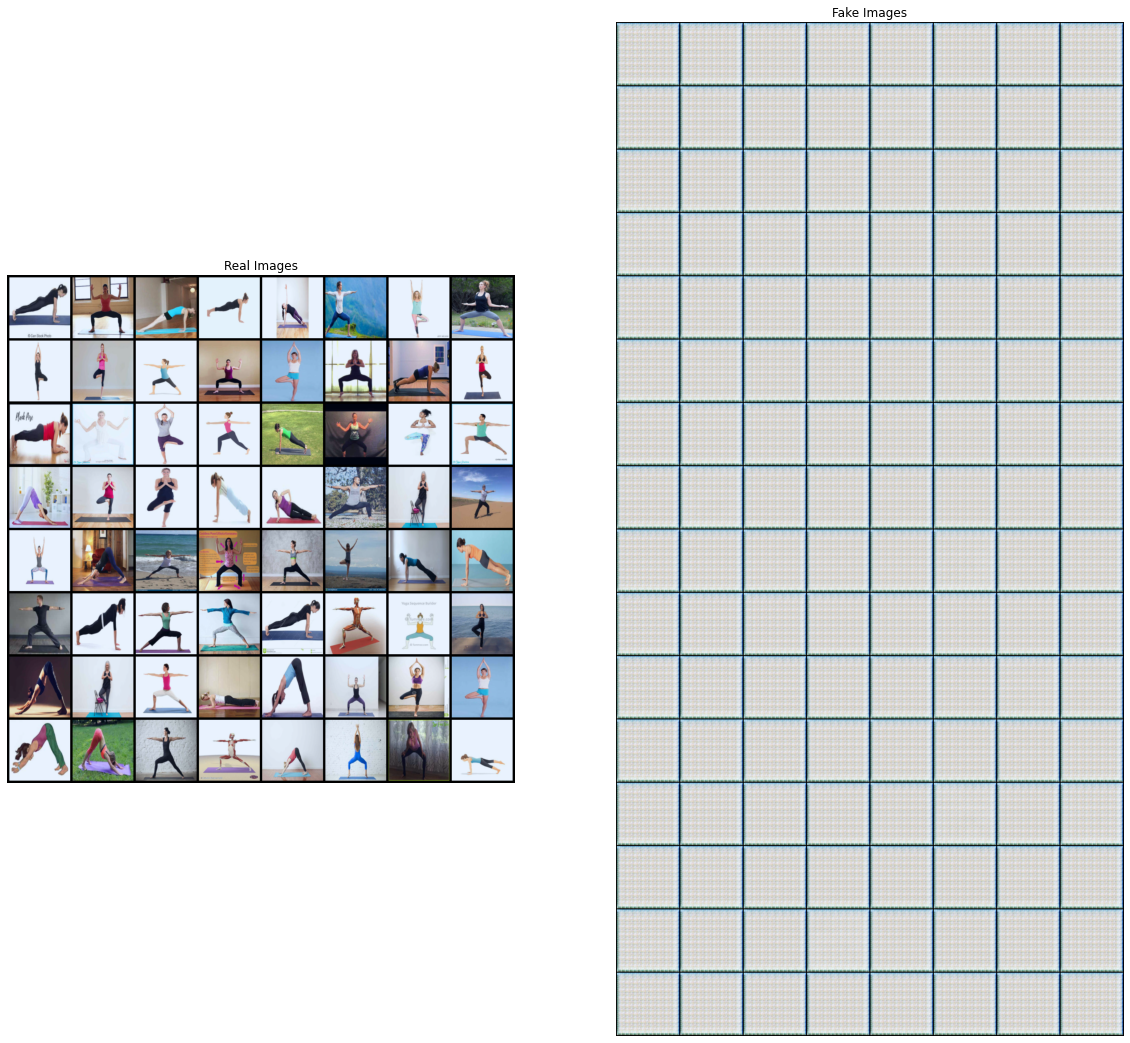

In [13]:
test_gan(acgan)

In [14]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure(figsize=(20, 20))
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H-%M-%S")))

In [15]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/Yoga/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)

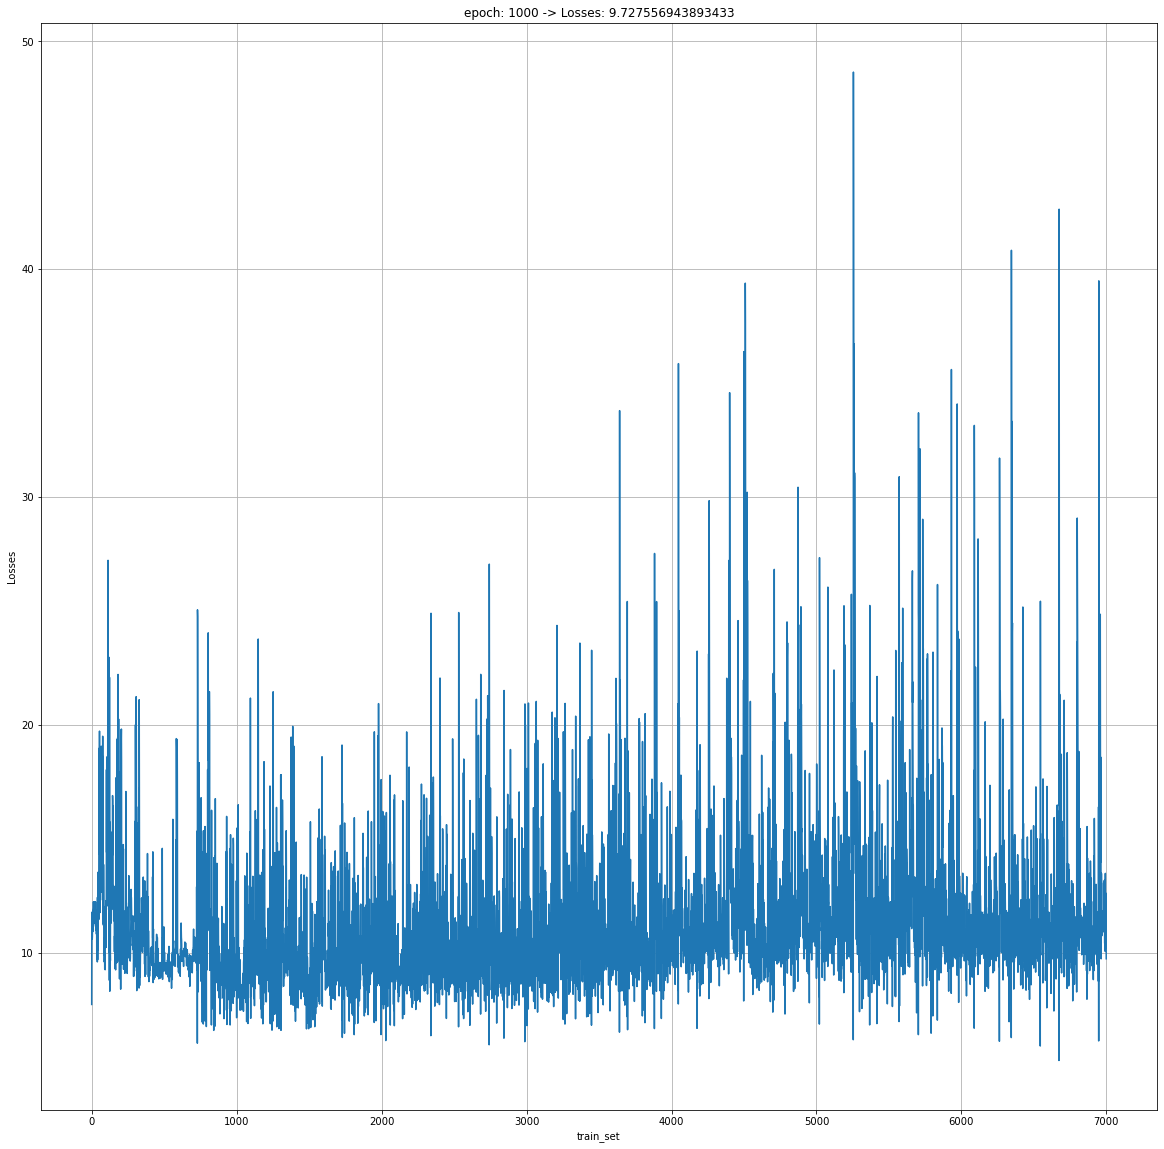

In [16]:
save_model(acgan.generator, acgan.discriminator, acgan.optimizer_g, acgan.optimizer_d, acgan.metrics, acgan.num_epoch)

C:\Users\lebro\AppData\Local\Temp\ipykernel_14460\1081463272.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


Discriminator s tensor([[3.3035e-16],
        [2.1418e-15],
        [1.2860e-16],
        [1.2810e-17],
        [2.8069e-14],
        [2.0538e-16],
        [3.3108e-15],
        [2.2316e-16],
        [1.4303e-15],
        [1.3525e-16],
        [3.5744e-16],
        [3.6192e-16],
        [5.2360e-16],
        [1.6509e-14],
        [1.5656e-16],
        [1.3808e-17],
        [1.1007e-15],
        [6.8036e-16],
        [1.5632e-15],
        [5.6524e-16],
        [6.8445e-16],
        [3.8823e-17],
        [1.2276e-15],
        [4.5315e-16],
        [6.6307e-17],
        [2.8794e-16],
        [9.5993e-17],
        [3.2676e-15],
        [1.0220e-15],
        [3.1635e-16],
        [5.8868e-16],
        [8.4278e-17],
        [2.5331e-15],
        [6.4158e-16],
        [2.3761e-15],
        [1.2908e-16],
        [3.3549e-15],
        [3.4649e-18],
        [3.5426e-16],
        [5.5912e-15],
        [1.0963e-16],
        [6.4105e-15],
        [1.9137e-16],
        [5.8052e-16],
        [7.6139e

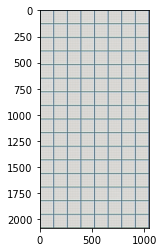

In [17]:
test_img_list = []
test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, device=device)
test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
test_img = acgan.generator(test_noise.resize_(acgan.batch_size, acgan.size_of_z, 1, 1))

s_output, c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
Discriminator s tensor([[0.8940],
        [0.9658],
        [0.9939],
        [0.9998],
        [0.9799],
        [0.9892],
        [0.9989],
        [0.9502],
        [0.9999],
        [0.9995],
        [0.8886],
        [0.9106],
        [1.0000],
        [0.9972],
        [0.0523],
        [0.9996],
        [0.5053],
        [0.7941],
        [0.2800],
        [0.9475],
        [0.9997],
        [0.8518],
        [0.5636],
        [0.7588],
        [0.0896],
        [0.9799],
        [0.3250],
        [0.3996],
        [0.9942],
        [0.9901],
        [0.9998],
        [0.9951],
        [0.7712],
        [0.6689],
        [0.8184]

C:\Users\lebro\AppData\Local\Temp\ipykernel_14460\1081463272.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


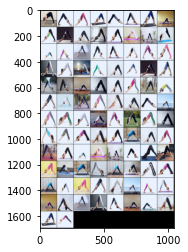

In [18]:
data = next(iter(acgan.test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))